In [1]:
import os
import json
import base64
import numpy as np
import pandas as pd
import geopandas as gpd
from typing import Optional
from pyiceberg.expressions import And, GreaterThanOrEqual, LessThanOrEqual
from pyiceberg.catalog import load_catalog

# Query from Foursquare

In [3]:
import os
import json
import base64
import numpy as np
import geopandas as gpd
from typing import Optional
from pyiceberg.expressions import And, GreaterThanOrEqual, LessThanOrEqual
from pyiceberg.catalog import load_catalog


def read_token(token_path: str) -> str:
    """
    Read and return the Foursquare API token from a local JSON file.

    The function supports two valid JSON formats:
    1) An object with a "token" key: {"token": "xxxxx"}
    2) A plain string containing the token: "xxxxx"

    Parameters
    ----------
    token_path : str
        Local file path to the JSON file containing the token.

    Returns
    -------
    str
        The token string extracted from the file.

    Raises
    ------
    ValueError
        If the JSON file format is invalid or does not contain a valid token.
    """
    with open(token_path, "r") as f:
        data = json.load(f)
    if isinstance(data, dict) and "token" in data:
        return data["token"]
    if isinstance(data, str):
        return data
    raise ValueError("Token JSON must be either a string or an object with a key 'token'.")


def json_str_tr(x):
    """
    Convert non-JSON-serializable Python objects (e.g., lists, dicts, arrays)
    into string representations that can be safely exported or visualized.

    Parameters
    ----------
    x : Any
        The input value to be converted.

    Returns
    -------
    str or None
        The JSON-compatible string representation of the input value.
    """
    if x is None:
        return None
    elif isinstance(x, (str, int, float, bool)):
        return str(x)
    elif isinstance(x, (list, tuple, set, np.ndarray)):
        return str(list(x))
    elif isinstance(x, dict):
        return str({k: json_str_tr(v) for k, v in x.items()})
    elif isinstance(x, (bytes, bytearray)):
        return base64.b64encode(x).decode("ascii")
    else:
        return str(x)


def query_foursquare(
    token_path: str,
    minLon: float,
    maxLon: float,
    minLat: float,
    maxLat: float,
    limit_size: Optional[int] = None,
    table_name: str = "datasets.places_os",
    uri: str = "https://catalog.h3-hub.foursquare.com/iceberg",
    warehouse: str = "places",
):
    """
    Query Points of Interest (POIs) from the Foursquare Iceberg Catalog
    within a given geographic bounding box and return results as a GeoDataFrame.

    This function connects to the Foursquare H3-Hub Iceberg dataset, applies a spatial filter
    (latitude/longitude bounds), retrieves the data as a Pandas DataFrame, converts it into
    a GeoDataFrame (EPSG:4326), and ensures all complex fields are JSON-serializable.

    Parameters
    ----------
    token_path : str
        Path to the local JSON file containing the Foursquare API token.
        The file should follow one of these formats:
        - {"token": "xxxxx"}
        - "xxxxx"
    minLon, maxLon, minLat, maxLat : float
        Geographic bounding box coordinates (in WGS84) for the query.
    limit_size : int, optional
        Maximum number of rows to return. If None (default), returns all available rows.
    table_name : str, default "datasets.places_os"
        Name of the Iceberg table to query.
    uri : str, default "https://catalog.h3-hub.foursquare.com/iceberg"
        Base URI of the Foursquare Iceberg REST catalog.
    warehouse : str, default "places"
        Name of the warehouse used by the Iceberg catalog.

    Returns
    -------
    geopandas.GeoDataFrame
        A GeoDataFrame containing POI records with WGS84 geometry.

    Examples
    --------
    Limit to 5000 rows:
    >>> gdf = query_foursquare(
    ...     token_path="~/foursquare_token.json",
    ...     minLon=-119.8694, maxLon=-119.85346,
    ...     minLat=34.40887, maxLat=34.41727,
    ...     limit_size=5000
    ... )

    Retrieve all available records (no limit):
    >>> gdf = query_foursquare(
    ...     token_path="~/foursquare_token.json",
    ...     minLon=-119.8694, maxLon=-119.85346,
    ...     minLat=34.40887, maxLat=34.41727
    ... )
    """
    # --- Load token ---
    token = read_token(os.path.expanduser(token_path))

    # --- Connect to the Iceberg catalog ---
    catalog = load_catalog(
        "default",
        **{
            "warehouse": warehouse,
            "uri": uri,
            "token": token,
            "header.content-type": "application/vnd.api+json",
            "rest-metrics-reporting-enabled": "false",
        },
    )

    # --- Load target table ---
    table = catalog.load_table(table_name)

    # --- Define spatial filter ---
    expr = And(
        And(GreaterThanOrEqual("longitude", minLon), LessThanOrEqual("longitude", maxLon)),
        And(GreaterThanOrEqual("latitude", minLat), LessThanOrEqual("latitude", maxLat)),
    )

    # --- Run query ---
    df = table.scan(row_filter=expr, limit=limit_size).to_pandas()

    # --- Convert to GeoDataFrame ---
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs="EPSG:4326",
    )

    # --- Clean up non-serializable columns ---
    for col in gdf.columns:
        if col != "geometry":
            if gdf[col].apply(lambda x: isinstance(x, (list, dict, np.ndarray, bytes, bytearray))).any():
                gdf[col] = gdf[col].apply(json_str_tr)

    return gdf


In [18]:
# foursquare_places = query_foursquare(token_path="/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/foursquare_token.json",
#                        minLon=-119.8694, maxLon=-119.85346,
#                        minLat=34.40887, maxLat=34.41727)


In [254]:
us_cbsa = gpd.read_file("/Users/houpuli/Downloads/Core_based_statistical_area_for_the_US_July_2023_4764927935501855778.geojson")
us_msa = us_cbsa[us_cbsa['CBSATYPE'] == 'Metropolitan Statistical Area']
msa_ny = us_msa[us_msa['CBSACODE']=='35620']
msa_ny

,OBJECTID,CBSACODE,CBSANAME,CBSATYPE,ALAND,AWATER,geometry
607,608,35620,"New York-Newark-Jersey City, NY-NJ",Metropolitan Statistical Area,15901418738,6489996005,"POLYGON ((-74.41689 39.82269, -74.41713 39.823..."


# NY MSA region

In [82]:
us_cbsa = gpd.read_file("/Users/houpuli/Downloads/Core_based_statistical_area_for_the_US_July_2023_4764927935501855778.geojson")
us_msa = us_cbsa[us_cbsa['CBSATYPE'] == 'Metropolitan Statistical Area']
us_msa

,OBJECTID,CBSACODE,CBSANAME,CBSATYPE,ALAND,AWATER,geometry
2,3,10180,"Abilene, TX",Metropolitan Statistical Area,7105668291,36756436,"POLYGON ((-99.11755 32.25045, -99.11756 32.250..."
5,6,10380,"Aguadilla, PR",Metropolitan Statistical Area,769374621,354393993,"POLYGON ((-67.12305 18.24282, -67.12308 18.242..."
6,7,10420,"Akron, OH",Metropolitan Statistical Area,2331510400,62132699,"POLYGON ((-81.42037 40.90651, -81.42042 40.906..."
9,10,10500,"Albany, GA",Metropolitan Statistical Area,4120596069,46238444,"POLYGON ((-83.71414 31.31837, -83.71439 31.318..."
10,11,10540,"Albany, OR",Metropolitan Statistical Area,5929809282,50118766,"POLYGON ((-122.89761 44.74495, -122.89749 44.7..."
...,...,...,...,...,...,...,...
927,928,49420,"Yakima, WA",Metropolitan Statistical Area,11122734369,41188782,"POLYGON ((-120.33109 46.04149, -120.34027 46.0..."
929,930,49620,"York-Hanover, PA",Metropolitan Statistical Area,2342295974,16503210,"POLYGON ((-76.46114 39.72131, -76.46188 39.721..."
930,931,49660,"Youngstown-Warren, OH",Metropolitan Statistical Area,2665268781,83270347,"POLYGON ((-81.00244 41.11912, -81.00243 41.119..."
931,932,49700,"Yuba City, CA",Metropolitan Statistical Area,3197863370,45895634,"POLYGON ((-121.48441 38.73460, -121.48459 38.7..."


In [4]:
us_msa = us_msa.to_crs(epsg=3857)
us_msa_union = us_msa.geometry.unary_union
us_msa_union_km2 = us_msa_union.area / 1e6  
us_msa_union_km2

4873805.790968443

In [5]:
pop_cbsa = gpd.read_file("/Users/houpuli/Downloads/ACSDT5Y2021.B01003_2026-02-05T232336.zip", header=0)
pop_cbsa = pop_cbsa.iloc[1:]
pop_cbsa["CBSACODE"] = pop_cbsa["GEO_ID"].str[-5:]
pop_cbsa = pop_cbsa.rename(columns={"B01003_001E": "tot_pop"})
pop_cbsa = pop_cbsa[['CBSACODE','tot_pop']]
pop_cbsa = pop_cbsa.astype({'tot_pop': 'int64'})
pop_cbsa

,CBSACODE,tot_pop
1,20100,1791
2,20200,2010
3,20300,3577
4,20400,3802
5,20501,4381
...,...,...
85391,50501,4757
85392,50502,2871
85393,50503,2010
85394,50601,4927


In [35]:
us_msa = us_msa.merge(pop_cbsa, on='CBSACODE', how='left')
us_msa = us_msa.dropna(subset=['tot_pop'])
us_msa = us_msa.sort_values("tot_pop").reset_index(drop=True)

msa_small_5 = us_msa.iloc[:5]
msa_small_10 = us_msa.iloc[:10]
msa_small_30 = us_msa.iloc[:30]
msa_large_5 = us_msa.iloc[-5:]
msa_large_10 = us_msa.iloc[-10:]
msa_large_30 = us_msa.iloc[-30:]

n = len(us_msa)
mid_start_30 = n // 2 - 15
mid_end_30   = n // 2 + 15
msa_middle_30 = us_msa.iloc[mid_start_30:mid_end_30]

mid_start_10 = n // 2 - 5
mid_end_10   = n // 2 + 5
msa_middle_10 = us_msa.iloc[mid_start_10:mid_end_10]

mid_start_5 = n // 2 - 2
mid_end_5   = n // 2 + 3
msa_middle_5 = us_msa.iloc[mid_start_5:mid_end_5]

msa_filter_30 = pd.concat([msa_small_30, msa_middle_30, msa_large_30], ignore_index=True)
msa_filter_30 = msa_filter_30.reset_index(drop=True)

msa_filter_10 = pd.concat([msa_small_10, msa_middle_10, msa_large_10], ignore_index=True)
msa_filter_10 = msa_filter_10.reset_index(drop=True)

msa_filter_5 = pd.concat([msa_small_5, msa_middle_5, msa_large_5], ignore_index=True)
msa_filter_5 = msa_filter_5.reset_index(drop=True)

In [36]:
msa_filter_union_30 = msa_filter_30.geometry.unary_union
msa_filter_union_30_km2 = msa_filter_union_30.area / 1e6  
msa_filter_union_30_km2

1490706.6565003593

In [37]:
msa_filter_union_10 = msa_filter_10.geometry.unary_union
msa_filter_union_10_km2 = msa_filter_union_10.area / 1e6  
msa_filter_union_10_km2

510887.1811204743

In [41]:
msa_filter_union_5 = msa_filter_5.geometry.unary_union
msa_filter_union_5_km2 = msa_filter_union_5.area / 1e6  
msa_filter_union_5_km2

251650.34412854628

In [42]:
msa_filter_5

,OBJECTID,CBSACODE,CBSANAME,CBSATYPE,ALAND,AWATER,geometry,tot_pop
0,247,20580,"Eagle Pass, TX",Metropolitan Statistical Area,3313819983,31871181,"POLYGON ((-11206239.954 3386380.667, -11206218...",57769.0
1,146,16180,"Carson City, NV",Metropolitan Statistical Area,374341371,32594082,"POLYGON ((-13358818.683 4745421.371, -13358482...",57957.0
2,885,47460,"Walla Walla, WA",Metropolitan Statistical Area,3289370357,74932288,"POLYGON ((-13180654.160 5780474.045, -13180792...",62168.0
3,266,21420,"Enid, OK",Metropolitan Statistical Area,2741521326,4075930,"POLYGON ((-10920934.315 4364647.514, -10920932...",62628.0
4,480,30300,"Lewiston, ID-WA",Metropolitan Statistical Area,3844567744,32544611,"POLYGON ((-12992950.553 5867919.979, -12992947...",64105.0
5,37,11540,"Appleton, WI",Metropolitan Statistical Area,2475529646,222422502,"POLYGON ((-9800974.967 5489228.280, -9800975.6...",241748.0
6,303,22900,"Fort Smith, AR-OK",Metropolitan Statistical Area,4662049165,166503067,"POLYGON ((-10489905.568 4173467.071, -10489917...",245235.0
7,89,13780,"Binghamton, NY",Metropolitan Statistical Area,3171226605,36122815,"POLYGON ((-8431586.708 5160688.163, -8432541.2...",247158.0
8,280,22020,"Fargo, ND-MN",Metropolitan Statistical Area,7278152640,26752493,"POLYGON ((-10719931.917 5882020.348, -10719946...",247967.0
9,928,49420,"Yakima, WA",Metropolitan Statistical Area,11122734369,41188782,"POLYGON ((-13395195.244 5787000.956, -13396217...",255151.0


In [8]:
msa_filter_30.to_csv("/Users/houpuli/Downloads/msa_filter_30.csv")

In [9]:
pop_places = gpd.read_file("/Users/houpuli/Downloads/ACSDT5YSPT2021.B01003_2025-12-16T173152.zip")
pop_places = pop_places.iloc[1:]
pop_places["PLACECODE"] = pop_places["GEO_ID"].str[-7:]
pop_places = pop_places.rename(columns={"B01003_001E": "tot_pop"})
pop_places = pop_places[['PLACECODE','tot_pop']]
pop_places = pop_places.astype({'tot_pop': 'int64'})
pop_places

,PLACECODE,tot_pop
1,0100124,2231
2,0100460,4381
3,0100484,697
4,0100820,33133
5,0100988,22268
...,...,...
24124,7286831,2966
24125,7287863,6466
24126,7288035,15404
24127,7288121,927


In [10]:
us_places = gpd.read_file("/Users/houpuli/Downloads/cb_2024_us_place_500k.zip")
us_places = us_places.rename(columns={'GEOID':'PLACECODE'})
us_places = us_places[['PLACECODE','NAMELSAD','STATE_NAME','geometry']]
us_places = us_places.merge(pop_places, on='PLACECODE', how='left')
us_places = us_places.dropna(subset=['tot_pop'])
us_places = us_places.sort_values("tot_pop").reset_index(drop=True)
us_places

,PLACECODE,NAMELSAD,STATE_NAME,geometry,tot_pop
0,2756698,St. Anthony city,Minnesota,"POLYGON ((-94.62005 45.69417, -94.60968 45.694...",71.0
1,2769880,Whipholt CDP,Minnesota,"POLYGON ((-94.40579 47.05780, -94.40489 47.062...",73.0
2,1950205,Masonville city,Iowa,"POLYGON ((-91.59811 42.48381, -91.58831 42.483...",74.0
3,1984835,Westwood city,Iowa,"POLYGON ((-91.63226 40.96399, -91.62977 40.966...",74.0
4,4017550,Council Hill town,Oklahoma,"POLYGON ((-95.65992 35.55906, -95.64661 35.558...",75.0
...,...,...,...,...,...
24101,4260000,Philadelphia city,Pennsylvania,"POLYGON ((-75.28027 39.97496, -75.27648 39.976...",1596865.0
24102,4835000,Houston city,Texas,"MULTIPOLYGON (((-95.17342 29.80781, -95.16994 ...",2293288.0
24103,1714000,Chicago city,Illinois,"POLYGON ((-87.94010 42.00079, -87.93530 42.000...",2742119.0
24104,0644000,Los Angeles city,California,"POLYGON ((-118.66816 34.18414, -118.66814 34.1...",3902440.0


In [83]:
places_small_10 = us_places.iloc[:10]
places_small_30 = us_places.iloc[:30]
places_large_10 = us_places.iloc[-10:]
places_large_30 = us_places.iloc[-30:]

n = len(us_places)
mid_start_30 = n // 2 - 15
mid_end_30   = n // 2 + 15
places_middle_30 = us_places.iloc[mid_start_30:mid_end_30]

mid_start_10 = n // 2 - 5
mid_end_10   = n // 2 + 5
places_middle_10 = us_places.iloc[mid_start_10:mid_end_10]

places_filter_30 = pd.concat([places_small_30, places_middle_30, places_large_30], ignore_index=True)
places_filter_30 = places_filter_30.reset_index(drop=True)

places_filter_10 = pd.concat([places_small_10, places_middle_10, places_large_10], ignore_index=True)
places_filter_10 = places_filter_10.reset_index(drop=True)

In [85]:
places_filter_30.to_csv("/Users/houpuli/Downloads/places_filter_30.csv")

# Query by Google Place API

In [2]:
import math
import time
import requests
import json
import warnings
from typing import Optional, Iterable, List, Dict, Any, Tuple

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Point
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def read_token(token_path: str) -> str:
    """
    Read and return the token from a local JSON file.

    The function supports two valid JSON formats:
    1) An object with a "token" key: {"token": "xxxxx"}
    2) A plain string containing the token: "xxxxx"

    Parameters
    ----------
    token_path : str
        Local file path to the JSON file containing the token.

    Returns
    -------
    str
        The token string extracted from the file.

    Raises
    ------
    ValueError
        If the JSON file format is invalid or does not contain a valid token.
    """
    with open(token_path, "r") as f:
        data = json.load(f)
    if isinstance(data, dict) and "token" in data:
        return data["token"]
    if isinstance(data, str):
        return data
    raise ValueError("Token JSON must be either a string or an object with a key 'token'.")


def circle_center(
    min_lon: float,
    max_lon: float,
    min_lat: float,
    max_lat: float,
    R: float,
    base: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:
    """
    Generate a grid of circle polygons inside a geographic bounding box.
    Returns circles in EPSG:4326 (lon/lat).

    If `base` is provided, return only circles that intersect `base`
    (via spatial join, predicate='intersects').

    Parameters
    ----------
    min_lon, max_lon, min_lat, max_lat : float
        Bounding box in EPSG:4326.
    R : float
        Grid half-spacing in meters (in EPSG:3857). Spacing is 2R.
        Each circle radius is R * sqrt(2) in meters (in EPSG:3857).
    base : geopandas.GeoDataFrame | None
        A GeoDataFrame used to filter circles by intersection.
        Will be reprojected to EPSG:4326 if needed.

    Returns
    -------
    geopandas.GeoDataFrame
        Circles (filtered if base is provided), in EPSG:4326.
    """
    # -----------------------------
    # 0) Basic input validation
    # -----------------------------
    if not (isinstance(min_lon, (int, float)) and isinstance(max_lon, (int, float))
            and isinstance(min_lat, (int, float)) and isinstance(max_lat, (int, float))):
        raise TypeError("min_lon, max_lon, min_lat, max_lat must be numeric (float or int).")
    if not (max_lon > min_lon and max_lat > min_lat):
        raise ValueError("max_lon must be > min_lon and max_lat must be > min_lat.")
    if not (isinstance(R, (int, float)) and R > 0):
        raise ValueError("R must be a positive number (meters).")

    if base is not None:
        if not isinstance(base, gpd.GeoDataFrame):
            raise TypeError("base must be a GeoDataFrame or None.")
        if base.geometry is None:
            raise ValueError("base must have a valid geometry column.")
        if base.crs is None:
            raise ValueError("base.crs is None. Please set a CRS on base before using it.")

    # -----------------------------
    # 1) Build bbox in EPSG:4326
    # -----------------------------
    poly_4326 = box(min_lon, min_lat, max_lon, max_lat)
    gdf_bbox_4326 = gpd.GeoDataFrame({"name": ["bbox_4326"]}, geometry=[poly_4326], crs="EPSG:4326")

    # -----------------------------
    # 2) Reproject bbox to EPSG:3857 (meters)
    # -----------------------------
    gdf_bbox_3857 = gdf_bbox_4326.to_crs(epsg=3857)
    minx, miny, maxx, maxy = gdf_bbox_3857.total_bounds

    # -----------------------------
    # 3) Grid centers inside bbox
    # -----------------------------
    xs = np.arange(minx + R, maxx + 1e-9, 2 * R)
    ys = np.arange(miny + R, maxy + 1e-9, 2 * R)

    if xs.size == 0 or ys.size == 0:
        warnings.warn("⚠️ No grid centers generated — check if R is too large or bbox too small.")
        centers_xy = np.empty((0, 2))
    else:
        xx, yy = np.meshgrid(xs, ys)
        centers_xy = np.column_stack([xx.ravel(), yy.ravel()])

    # -----------------------------
    # 4) Build circles in 3857 -> back to 4326
    # -----------------------------
    radius_m = R
    circles_3857 = [Point(cx, cy).buffer(radius_m, resolution=64) for (cx, cy) in centers_xy]
    circles = gpd.GeoDataFrame(geometry=circles_3857, crs="EPSG:3857").to_crs(epsg=4326)

    # -----------------------------
    # 5) Optional: filter circles by intersection with base
    # -----------------------------
    base_4326 = base.to_crs("EPSG:4326")
    circles_4326 = (
        gpd.sjoin(circles, base_4326, how="inner", predicate="intersects")
            .reset_index(drop=True)
    )
    circles_4326 = circles_4326[circles.columns]
    circles_m = circles_4326.to_crs(epsg=3857)
    centroids_m = circles_m.geometry.centroid
    centroids_ll = centroids_m.to_crs(epsg=4326)
    circles_4326["center_lon"] = centroids_ll.x
    circles_4326["center_lat"] = centroids_ll.y
    
    return circles_4326

def places_nearby_grid(
    circles: gpd.GeoDataFrame,
    *,
    token: str,
    R: float,
    place_types: List[str],
    field_mask: Iterable[str],
    max_result_count: int = 20,
    sleep_sec: float = 0.1,
) -> gpd.GeoDataFrame:
    """
    Query Google Places Nearby Search for each circle center.

    Parameters
    ----------
    circles : GeoDataFrame
        Must contain columns ['center_lon', 'center_lat'] in EPSG:4326.
    token : str
        Google Places API key.
    R : float
        Search radius in meters (should match circle_center R).
    place_types : list[str]
        includedPrimaryTypes sent to Google Places.
    field_mask : iterable[str]
        Fields requested via X-Goog-FieldMask.
    max_result_count : int, default 20
        Max results per query (Google cap).
    sleep_sec : float, default 0.1
        Sleep time between requests to avoid rate limiting.

    Returns
    -------
    GeoDataFrame
        POIs returned by Google Places Nearby Search (EPSG:4326).
    """

    url = "https://places.googleapis.com/v1/places:searchNearby"

    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": token,
        "X-Goog-FieldMask": ",".join(field_mask),
    }

    rows: List[Dict[str, Any]] = []

    for circle_id, row in circles.iterrows():
        lat = row["center_lat"]
        lon = row["center_lon"]

        payload = {
            "locationRestriction": {
                "circle": {
                    "center": {
                        "latitude": float(lat),
                        "longitude": float(lon),
                    },
                    "radius": float(R),
                }
            },
            "includedPrimaryTypes": place_types,
            "maxResultCount": int(max_result_count),
        }

        resp = requests.post(url, headers=headers, json=payload, timeout=30)
        data = resp.json()

        places = data.get("places", [])

        for p in places:
            rows.append({
                "circle_id": circle_id,
                "id": p.get("id"),
                "name": p.get("displayName", {}).get("text"),
                "address": p.get("formattedAddress"),
                "primary_type": p.get("primaryType"),
                "lat": p.get("location", {}).get("latitude"),
                "lon": p.get("location", {}).get("longitude"),
                "business_status": p.get("businessStatus"),
            })

        time.sleep(sleep_sec)

    df = pd.DataFrame(rows)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["lon"], df["lat"]),
        crs="EPSG:4326",
    )

    return gdf

In [668]:
min_lon, max_lon = -123.038419, -122.427038
min_lat, max_lat = 47.403097, 47.972959

token = read_token("/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/googleplace_token.json")
R = 5000  # meters

circles = circle_center(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_bspo
)
circles

,geometry,center_lon,center_lat
0,"POLYGON ((-122.76892 47.43349, -122.76894 47.4...",-122.813840,47.433489
1,"POLYGON ((-122.67909 47.43349, -122.67911 47.4...",-122.724009,47.433489
2,"POLYGON ((-122.58926 47.43349, -122.58927 47.4...",-122.634177,47.433489
3,"POLYGON ((-122.49943 47.43349, -122.49944 47.4...",-122.544346,47.433489
4,"POLYGON ((-122.94859 47.49422, -122.94860 47.4...",-122.993503,47.494220
5,"POLYGON ((-122.85876 47.49422, -122.85877 47.4...",-122.903672,47.494220
6,"POLYGON ((-122.76892 47.49422, -122.76894 47.4...",-122.813840,47.494220
7,"POLYGON ((-122.67909 47.49422, -122.67911 47.4...",-122.724009,47.494220
8,"POLYGON ((-122.58926 47.49422, -122.58927 47.4...",-122.634177,47.494220
9,"POLYGON ((-122.49943 47.49422, -122.49944 47.4...",-122.544346,47.494220


## 1.shop

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "asian_grocery_store",
    "auto_parts_store",
    "bicycle_store",
    "book_store",
    "butcher_shop",
    "cell_phone_store",
    "clothing_store",
    "convenience_store",
    "department_store",
    "discount_store",
    "electronics_store",
    "food_store",
    "furniture_store",
    "gift_shop",
    "grocery_store",
    "hardware_store",
    "home_goods_store",
    "home_improvement_store",
    "jewelry_store",
    "liquor_store",
    "market",
    "pet_store",
    "shoe_store",
    "shopping_mall",
    "sporting_goods_store",
    "store",
    "supermarket",
    "warehouse_store",
    "wholesaler",
]

google_shop_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_shop_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJ5z0XwWO1kVQRGBYXokWa71k,Safeway,"23961 WA-3, Belfair, WA 98528, USA",grocery_store,47.453974,-122.822669,POINT (-122.82267 47.45397)
1,0,ChIJ-x5cKGO1kVQREsOuXJKJIGk,QFC,"201 WA-300, Belfair, WA 98528, USA",grocery_store,47.453115,-122.828661,POINT (-122.82866 47.45311)
2,0,ChIJx0-dTWO1kVQRIVodFZl8mkI,Scott McLendon's Hardware,"51 WA-300, Belfair, WA 98528, USA",hardware_store,47.451799,-122.828074,POINT (-122.82807 47.45180)
3,0,ChIJbQpH4y41kFQRWdqn59apxAY,Peninsula Topsoil & Landscape Supplies,"50 Peninsula Blvd, Belfair, WA 98528, USA",store,47.463606,-122.812623,POINT (-122.81262 47.46361)
4,0,ChIJt1h9Ome1kVQRITTy2xVuDFk,Tienda Mi Tierra Guatemala,"23781 WA-3 #105, Belfair, WA 98528, USA",grocery_store,47.452707,-122.826051,POINT (-122.82605 47.45271)
...,...,...,...,...,...,...,...,...
611,44,ChIJ17WjhWf9j1QRpr6GK7eV49w,Resonant Botanicals,"7459 Maxwelton Rd, Clinton, WA 98236, USA",store,47.940212,-122.441363,POINT (-122.44136 47.94021)
612,44,ChIJNdt2RVz9j1QRuAaQBKnYXn4,Focii Technology,"7532 Inlet Way, Clinton, WA 98236, USA",store,47.937768,-122.444959,POINT (-122.44496 47.93777)
613,44,ChIJiapST4L9j1QR5_JPzjMm8JM,Sound and Vision Vintage,"7403 Barred Owl Way, Clinton, WA 98236, USA",clothing_store,47.941510,-122.410545,POINT (-122.41055 47.94151)
614,44,ChIJq6rOYBL-j1QR9-6t2ZP8qK4,Marigold and Clover,"7327 Bailey Rd, Clinton, WA 98236, USA",store,47.945581,-122.423404,POINT (-122.42340 47.94558)


In [ ]:
# google_shop_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_shop_5000.geojson', driver="GeoJSON")

## 2.automotive

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "car_dealer",
    "car_rental",
    "car_repair",
    "car_wash",
    "electric_vehicle_charging_station",
    "gas_station",
    "parking",
    "rest_stop",
]

google_automotive_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_automotive_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJaz1Ikne1kVQRq8_ec0XZiEs,Les Schwab Tire Center,"23090 WA-3, Belfair, WA 98528, USA",auto_parts_store,47.441541,-122.832745,POINT (-122.83274 47.44154)
1,0,ChIJwTqOxGO1kVQR3ffcwUqPDTc,Safeway Fuel Station,"23961 WA-3, Belfair, WA 98528, USA",gas_station,47.453613,-122.824365,POINT (-122.82436 47.45361)
2,0,ChIJpZyerHu1kVQRAc6e7nFRTOA,Local Wrench,"23530 WA-3 suite a, Belfair, WA 98528, USA",car_repair,47.447925,-122.828294,POINT (-122.82829 47.44793)
3,0,ChIJN0q6e521kVQR6R5jME-2v9I,O'Reilly Auto Parts,"23030 WA-3, Belfair, WA 98528, USA",auto_parts_store,47.441070,-122.832879,POINT (-122.83288 47.44107)
4,0,ChIJ8SIqjWO1kVQR2blnwrvt0C4,Valvoline Instant Oil Change,"23970 N WA-3, Belfair, WA 98528, USA",car_repair,47.453070,-122.822240,POINT (-122.82224 47.45307)
...,...,...,...,...,...,...,...,...
474,42,ChIJXbwutiHhj1QRoN8VucmEh_E,Tesla Destination Charger,"1 Heron Rd, Port Ludlow, WA 98365, USA",electric_vehicle_charging_station,47.922465,-122.682648,POINT (-122.68265 47.92246)
475,42,ChIJU1R5g_Hgj1QRNcWljvJvlvU,Tesla Destination Charger,"751 Highland Dr, Port Ludlow, WA 98365, USA",electric_vehicle_charging_station,47.904310,-122.692844,POINT (-122.69284 47.90431)
476,43,ChIJ2eokAuTjj1QR05Io4yQ9CG0,Point No Point,"Point No Point Access Area, 8760 NE Point No P...",parking,47.911118,-122.532701,POINT (-122.53270 47.91112)
477,43,ChIJsSupGCfjj1QRQcoUBo_XIRk,Norwegian Point,"39118 Hansville Rd NE, Hansville, WA 98340, USA",parking,47.916989,-122.546253,POINT (-122.54625 47.91699)


In [ ]:
# google_automotive_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_automotive_5000.geojson', driver="GeoJSON")

## 3.business

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "corporate_office",
    "farm",
    "ranch",
]

google_business_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_business_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJEwvMh3i1kVQRvhu8zElFs1c,The Salmon Center,"600 NE Roessel Rd, Belfair, WA 98528, USA",farm,47.445150,-122.837169,POINT (-122.83717 47.44515)
1,0,ChIJv8JdlqlKkFQR8FC9QjrjPDc,Alpine U Cut,"11670-11600 SW Lake Flora Rd, Bremerton, WA 98...",farm,47.469273,-122.781445,POINT (-122.78144 47.46927)
2,0,ChIJhcnx8WK1kVQRp_4B5GHgk0s,Mosquito Fleet Winery,"21 NE Old Belfair Hwy, Belfair, WA 98528, USA",farm,47.454508,-122.827595,POINT (-122.82760 47.45451)
3,0,ChIJt6R0ppS1kVQRQAOK_fLeq-E,Crazy Hill Garden & Botanicals,"23450 WA-3, Belfair, WA 98528, USA",farm,47.447096,-122.829221,POINT (-122.82922 47.44710)
4,0,ChIJQZlo10i0kVQR4A9-YOqgiA4,Washington State Salmon Hatchery,"41 E Coulter Creek Rd, Belfair, WA 98528, USA",ranch,47.406900,-122.818439,POINT (-122.81844 47.40690)
...,...,...,...,...,...,...,...,...
291,43,ChIJicnfUeYfkFQRKS4FF1T0Ctk,Shared Dream Cellars,"34721 Hood Canal Dr NE, Kingston, WA 98346, USA",farm,47.877830,-122.573255,POINT (-122.57325 47.87783)
292,43,ChIJedQlgs4dkFQRkZ3GQW_B0lU,Eaglepoint Potager,"8043 NE Eaglepoint Ln, Kingston, WA 98346, USA",farm,47.884389,-122.540784,POINT (-122.54078 47.88439)
293,44,ChIJZZCCU-H9j1QRL42Z388Vlrg,SkyRoot Farm,"7297 Bailey Rd, Clinton, WA 98236, USA",farm,47.946740,-122.424482,POINT (-122.42448 47.94674)
294,44,ChIJ62yzOgADkFQRT7XcoZ_Ly8A,Woodsong Family Farm Store,"7800 Mortland Dr, Clinton, WA 98236, USA",farm,47.927177,-122.424829,POINT (-122.42483 47.92718)


In [ ]:
# google_business_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_business_5000.geojson', driver="GeoJSON")

## 4.culture

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "art_gallery",
    "art_studio",
    "auditorium",
    "cultural_landmark",
    "historical_place",
    "monument",
    "museum",
    "performing_arts_theater",
    "sculpture",
]

google_culture_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_culture_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,1,ChIJ88tA1QZLkFQRqW9Nfmqdjvo,Thomas Stream Gallery: Streamline Indus. LLC,"13271 Woodside Ln SW, Port Orchard, WA 98367, USA",art_gallery,47.428243,-122.673120,POINT (-122.67312 47.42824)
1,2,ChIJx6QTl6lNkFQREp9EHmXbpvs,Colibri Soul Studio,"14173 Colony Ave SE, Port Orchard, WA 98367, USA",art_studio,47.420252,-122.633669,POINT (-122.63367 47.42025)
2,2,ChIJ88tA1QZLkFQRqW9Nfmqdjvo,Thomas Stream Gallery: Streamline Indus. LLC,"13271 Woodside Ln SW, Port Orchard, WA 98367, USA",art_gallery,47.428243,-122.673120,POINT (-122.67312 47.42824)
3,3,ChIJI6RxoRtRkFQRqF6wVtCVlxk,S. Marotta Pottery,"13710 SW 220th St, Vashon, WA 98070, USA",art_gallery,47.407725,-122.511467,POINT (-122.51147 47.40772)
4,3,ChIJ52bxV-xOkFQRUxKhEfYAN3U,Originals Only Inc,"PO Box 1161, Olalla, WA 98359, USA",art_gallery,47.429120,-122.546267,POINT (-122.54627 47.42912)
...,...,...,...,...,...,...,...,...
223,42,ChIJwcSYoz3hj1QRuXvPu0y0ykc,Port Ludlow Art Gallery,"9500 Oak Bay Rd Suite B, Port Ludlow, WA 98365...",art_gallery,47.921548,-122.700456,POINT (-122.70046 47.92155)
224,43,ChIJjbUFXHzij1QRRuvd2mYBYhs,Point No Point Lighthouse,"9009 NE Point No Point Rd, Hansville, WA 98340...",historical_landmark,47.912158,-122.526893,POINT (-122.52689 47.91216)
225,43,ChIJDXOC3P3hj1QRzXvUjq6XCqo,Issei Pioneer Museum,"36001 Hood Canal Dr NE, Hansville, WA 98340, USA",museum,47.889082,-122.579302,POINT (-122.57930 47.88908)
226,44,ChIJcfoSRpQCkFQRhS2rQbqe49M,Sweetwater Creek Farm Studio,"7960 Scatchet Head Rd, Clinton, WA 98236, USA",art_studio,47.922190,-122.412910,POINT (-122.41291 47.92219)


In [ ]:
# google_culture_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_culture_5000.geojson', driver="GeoJSON")

## 5.education

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "library",
    "preschool",
    "primary_school",
    "school",
    "secondary_school",
    "university",
]

google_education_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_education_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJ6Yx20Mm1kVQRO3oMWf34Uic,North Mason High School,"150 E North Mason School Rd, Belfair, WA 98528...",secondary_school,47.415332,-122.840357,POINT (-122.84036 47.41533)
1,0,ChIJn15pEcm1kVQRdSGmCI6PzqA,Sand Hill Elementary School,"791 NE Sand Hill Rd, Belfair, WA 98528, USA",primary_school,47.458576,-122.846344,POINT (-122.84634 47.45858)
2,0,ChIJh44sqcm1kVQRF7UC6G7C8CY,Hawkins Middle School,"300 E Campus Dr, Belfair, WA 98528, USA",school,47.413351,-122.841264,POINT (-122.84126 47.41335)
3,0,ChIJ3XStYZ21kVQR1OWbgVhZSWU,North Mason Timberland Library,"23081 WA-3, Belfair, WA 98528, USA",library,47.441856,-122.833898,POINT (-122.83390 47.44186)
4,0,ChIJ1ZOStZ21kVQRZIE1TTq3tnc,Belfair Elementary School,"22900 WA-3, Belfair, WA 98528, USA",primary_school,47.438806,-122.834880,POINT (-122.83488 47.43881)
...,...,...,...,...,...,...,...,...
310,39,ChIJQ5r1cVwekFQR8fg85wcdKIs,"Kitsap Regional Library, Little Boston","31980 Little Boston Rd NE, Kingston, WA 98346,...",library,47.852920,-122.569807,POINT (-122.56981 47.85292)
311,39,ChIJZZTTIbQhkFQRAFctiPAeRBE,Tender Leaves Outdoor Preschool,"3160 Wheeler St NE, Poulsbo, WA 98370, USA",preschool,47.855714,-122.607945,POINT (-122.60794 47.85571)
312,40,ChIJQ5r1cVwekFQR8fg85wcdKIs,"Kitsap Regional Library, Little Boston","31980 Little Boston Rd NE, Kingston, WA 98346,...",library,47.852920,-122.569807,POINT (-122.56981 47.85292)
313,40,ChIJvbYu-NYfkFQRnQA6YcN2qtE,Northwest Indian College PGS Site,"Port Gamble Reservation, Kingston, WA 98346, USA",university,47.847080,-122.565134,POINT (-122.56513 47.84708)


In [ ]:
# google_education_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_education_5000.geojson', driver="GeoJSON")

## 6.entertainment

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "adventure_sports_center",
    "amphitheatre",
    "amusement_center",
    "amusement_park",
    "aquarium",
    "banquet_hall",
    "barbecue_area",
    "botanical_garden",
    "bowling_alley",
    "casino",
    "childrens_camp",
    "comedy_club",
    "community_center",
    "concert_hall",
    "convention_center",
    "cultural_center",
    "cycling_park",
    "dance_hall",
    "dog_park",
    "event_venue",
    "ferris_wheel",
    "garden",
    "hiking_area",
    "historical_landmark",
    "internet_cafe",
    "karaoke",
    "marina",
    "movie_rental",
    "movie_theater",
    "national_park",
    "night_club",
    "observation_deck",
    "off_roading_area",
    "opera_house",
    "park",
    "philharmonic_hall",
    "picnic_ground",
    "planetarium",
    "plaza",
    "roller_coaster",
    "skateboard_park",
    "state_park",
    "tourist_attraction",
    "video_arcade",
    "visitor_center",
    "water_park",
    "wedding_venue",
    "wildlife_park",
    "wildlife_refuge",
    "zoo",
]

google_entertainment_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_entertainment_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJw8ir3vq1kVQR93eofgvcWfo,Belfair State Park,"3151 WA-300, Belfair, WA 98528, USA",state_park,47.428981,-122.877859,POINT (-122.87786 47.42898)
1,0,ChIJY0-TV5q1kVQRGXFFfe_fNYk,Theler Wetlands Trail,"22803 WA-33, Belfair, WA 98528, USA",park,47.437908,-122.836232,POINT (-122.83623 47.43791)
2,0,ChIJcc8JBnO1kVQRMJKUb7R16BY,Clamming North Bay WDFW,"Belfair, WA 98528, USA",park,47.390424,-122.812247,POINT (-122.81225 47.39042)
3,0,ChIJG9vSgYXKkVQRvp10yzZIqeo,Sandhill County Park,"1000 NE Sand Hill Rd, Belfair, WA 98528, USA",park,47.461432,-122.845075,POINT (-122.84507 47.46143)
4,0,ChIJeYhslKm1kVQRGBgAoM3fjPE,Belfair Bark Park,"600 NE Roessel Rd, Belfair, WA 98528, USA",park,47.445101,-122.835311,POINT (-122.83531 47.44510)
...,...,...,...,...,...,...,...,...
601,43,ChIJ____w2nij1QRGuMfskNVhIs,Hansville Greenway Alder Wetland,"NE Twin Spits Rd, Hansville, WA 98340, USA",park,47.916884,-122.553490,POINT (-122.55349 47.91688)
602,44,ChIJo6FqzEL9j1QRNjDelM7tQqU,Dave Mackie Park,"7490 Maxwelton Rd, Clinton, WA 98236, USA",park,47.939379,-122.443598,POINT (-122.44360 47.93938)
603,44,ChIJh4YwMO4CkFQRjdJMNpMwC8o,Sandy Hook Yacht Club,"8224 Sandy Hook Dr, Clinton, WA 98236, USA",marina,47.917125,-122.393371,POINT (-122.39337 47.91713)
604,44,ChIJVcxQ5AP9j1QRTBObxwGHmcA,Cascadia Meadows,"7027 Maxwelton Rd, Clinton, WA 98236, USA",wedding_venue,47.955798,-122.437583,POINT (-122.43758 47.95580)


In [ ]:
# google_entertainment_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_entertainment_5000.geojson', driver="GeoJSON")

## 7.facilities

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "public_bath",
    "public_bathroom",
    "stable",
]

google_facilities_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_facilities_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJx6x8IgC1kVQRsRhdhuqjdWw,Public Bathroom,"3270 WA-302, Belfair, WA 98528, USA",public_bathroom,47.390336,-122.812146,POINT (-122.81215 47.39034)
1,2,ChIJmdGJWR5MkFQROu3n7yCdc6g,Pets Galore Horseback Rides,"13659 Cedar Glen Ln SE, Olalla, WA 98359, USA",stable,47.426894,-122.589257,POINT (-122.58926 47.42689)
2,2,ChIJL-ySv65NkFQRNSWXVv2rzt0,Creekside Meadow Farms,"1204 SE Oak Rd, Port Orchard, WA 98367, USA",stable,47.423625,-122.635054,POINT (-122.63505 47.42363)
3,2,ChIJy1Wj-I1OkFQRCq_7LdVKrm0,Marnatha Farms- indoor/outdoor arenas,"off Nelson /Peacock Hill, Olalla, WA 98359, USA",stable,47.410552,-122.589006,POINT (-122.58901 47.41055)
4,3,ChIJmdGJWR5MkFQROu3n7yCdc6g,Pets Galore Horseback Rides,"13659 Cedar Glen Ln SE, Olalla, WA 98359, USA",stable,47.426894,-122.589257,POINT (-122.58926 47.42689)
...,...,...,...,...,...,...,...,...
127,40,ChIJLXwJI70ekFQRpGsnKMX59rs,Woodside Stables,"28700 Hansville Rd NE, Kingston, WA 98346, USA",stable,47.821294,-122.537431,POINT (-122.53743 47.82129)
128,40,ChIJmQ1zDKIfkFQRHS_HNJtv9Ck,Olson Equine,"9368 NE Derby Wy, Kingston, WA 98346, USA",stable,47.837161,-122.523032,POINT (-122.52303 47.83716)
129,40,ChIJcXGUbqUfkFQRUekEEcFC0Vg,Porta Pottie,"28900 WA-104, Poulsbo, WA 98370, USA",public_bathroom,47.840016,-122.587835,POINT (-122.58784 47.84002)
130,43,ChIJD6LZ88fjj1QRUkJ_4h4z3o0,Bathroom,"Point No Point County Park, 9009 NE Point No P...",public_bathroom,47.911710,-122.528354,POINT (-122.52835 47.91171)


In [ ]:
# google_facilities_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_facilities_5000.geojson', driver="GeoJSON")

## 8.finance

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "accounting",
    "atm",
    "bank",
]

google_finance_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_finance_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJTeuCFGG1kVQRo-6mLXNFoeY,Kitsap Bank,"24180 WA-3, Belfair, WA 98528, USA",bank,47.454794,-122.819193,POINT (-122.81919 47.45479)
1,0,ChIJt5aEU2O1kVQRlN4ZNi_vt3w,KeyBank,"23731 WA-3, Belfair, WA 98528, USA",bank,47.450609,-122.828250,POINT (-122.82825 47.45061)
2,0,ChIJ1SMYrXy1kVQRBUGXez-0NPM,Olympia Federal Savings - Belfair,"24081 WA-3, Belfair, WA 98528, USA",bank,47.454053,-122.821681,POINT (-122.82168 47.45405)
3,0,ChIJAQAAABDKkVQRVmEi0yWGq-0,H&R Block,"31 WA-300 Ste 103, Belfair, WA 98528, USA",consultant,47.451085,-122.828082,POINT (-122.82808 47.45108)
4,0,ChIJydkHPGG1kVQREMPZSnO3GD0,"Parker Mooers & Cena Accountants, an Archer Le...","23211 NE, WA-3 Suite B, Belfair, WA 98528, USA",consultant,47.443235,-122.832739,POINT (-122.83274 47.44323)
...,...,...,...,...,...,...,...,...
280,40,ChIJGwHveE8ekFQRQDWXnpErnEg,WestSound Tax and Accounting,"4839 View Dr NE, Port Gamble, WA 98364, USA",consultant,47.855732,-122.584418,POINT (-122.58442 47.85573)
281,40,ChIJrc7LQyQfkFQR2gRKQjvTq-0,Hoggard Bookkeeping,"33527 Hansville Rd NE, Kingston, WA 98346, USA",consultant,47.866290,-122.541998,POINT (-122.54200 47.86629)
282,40,ChIJ4SYlciIfkFQRiQYEvgTY3P8,Lighthouse Accounting Solutions,"33527 Hansville Rd NE, Kingston, WA 98346, USA",consultant,47.866314,-122.542003,POINT (-122.54200 47.86631)
283,42,ChIJax_Rmtvgj1QRLseZdOa5OiU,Sound Community Bank,"9500 Oak Bay Rd # A, Port Ludlow, WA 98365, USA",bank,47.921548,-122.700456,POINT (-122.70046 47.92155)


In [ ]:
# google_finance_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_finance_5000.geojson', driver="GeoJSON")

## 9.food1

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "acai_shop",
    "afghani_restaurant",
    "african_restaurant",
    "american_restaurant",
    "asian_restaurant",
    "bagel_shop",
    "bakery",
    "bar",
    "bar_and_grill",
    "barbecue_restaurant",
    "brazilian_restaurant",
    "breakfast_restaurant",
    "brunch_restaurant",
    "buffet_restaurant",
    "cafe",
    "cafeteria",
    "candy_store",
    "cat_cafe",
    "chinese_restaurant",
    "chocolate_factory",
    "chocolate_shop",
    "coffee_shop",
    "confectionery",
    "deli",
    "dessert_restaurant",
    "dessert_shop",
    "diner",
    "dog_cafe",
    "donut_shop",
    "fast_food_restaurant",
    "fine_dining_restaurant",
    "food_court",
]

google_food1_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_food1_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJE2XkOZy1kVQRf9xuRDzAqBw,The Hideaway,"22540 WA-3, Belfair, WA 98528, USA",american_restaurant,47.435189,-122.838384,POINT (-122.83838 47.43519)
1,0,ChIJPeugXmG1kVQRexW11ukaQ54,McDonald's,"24200 WA-3, Belfair, WA 98528, USA",fast_food_restaurant,47.455346,-122.818758,POINT (-122.81876 47.45535)
2,0,ChIJ30rHmGO1kVQRoJ1v18ONH1M,Starbucks Coffee Company,"23965 WA-3, Belfair, WA 98528, USA",coffee_shop,47.453100,-122.823850,POINT (-122.82385 47.45310)
3,0,ChIJ5YmKdk21kVQRHtfitOXqtz0,Burger Claim & More,"24171 WA-3, Belfair, WA 98528, USA",hamburger_restaurant,47.455112,-122.820336,POINT (-122.82034 47.45511)
4,0,ChIJMR_ndWO1kVQRrwsK0bTt1sc,Taco Bell,"23881 WA-3, Belfair, WA 98528, USA",fast_food_restaurant,47.452813,-122.824501,POINT (-122.82450 47.45281)
...,...,...,...,...,...,...,...,...
379,40,ChIJB8WinigfkFQRkgVACha9P54,Dragon Eighty-Eight,"7989 NE Salish Ln, Kingston, WA 98346, USA",asian_restaurant,47.844786,-122.543180,POINT (-122.54318 47.84479)
380,40,ChIJ-xRqdqMfkFQRlD_48PVQYgo,Summer Sounds BBQ,"7989 NE Salish Ln, Kingston, WA 98346, USA",american_restaurant,47.845163,-122.543476,POINT (-122.54348 47.84516)
381,40,ChIJY1v-NgAfkFQRjKd7IqAaEfY,Center Bar,"7989 NE Salish Ln, Kingston, WA 98346, USA",bar,47.845168,-122.543421,POINT (-122.54342 47.84517)
382,42,ChIJnzGAGiHhj1QRPW7CZzZKioE,The Fireside Restaurant,"1 Heron Rd, Port Ludlow, WA 98365, USA",american_restaurant,47.922608,-122.683150,POINT (-122.68315 47.92261)


In [ ]:
# google_food1_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_food1_5000.geojson', driver="GeoJSON")

## 10.food2

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "french_restaurant",
    "greek_restaurant",
    "hamburger_restaurant",
    "ice_cream_shop",
    "indian_restaurant",
    "indonesian_restaurant",
    "italian_restaurant",
    "japanese_restaurant",
    "juice_shop",
    "korean_restaurant",
    "lebanese_restaurant",
    "meal_delivery",
    "meal_takeaway",
    "mediterranean_restaurant",
    "mexican_restaurant",
    "middle_eastern_restaurant",
    "pizza_restaurant",
    "pub",
    "ramen_restaurant",
    "restaurant",
    "sandwich_shop",
    "seafood_restaurant",
    "spanish_restaurant",
    "steak_house",
    "sushi_restaurant",
    "tea_house",
    "thai_restaurant",
    "turkish_restaurant",
    "vegan_restaurant",
    "vegetarian_restaurant",
    "vietnamese_restaurant",
    "wine_bar",
]

google_food2_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_food2_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJE2XkOZy1kVQRf9xuRDzAqBw,The Hideaway,"22540 WA-3, Belfair, WA 98528, USA",american_restaurant,47.435189,-122.838384,POINT (-122.83838 47.43519)
1,0,ChIJPeugXmG1kVQRexW11ukaQ54,McDonald's,"24200 WA-3, Belfair, WA 98528, USA",fast_food_restaurant,47.455346,-122.818758,POINT (-122.81876 47.45535)
2,0,ChIJ5YmKdk21kVQRHtfitOXqtz0,Burger Claim & More,"24171 WA-3, Belfair, WA 98528, USA",hamburger_restaurant,47.455112,-122.820336,POINT (-122.82034 47.45511)
3,0,ChIJMR_ndWO1kVQRrwsK0bTt1sc,Taco Bell,"23881 WA-3, Belfair, WA 98528, USA",fast_food_restaurant,47.452813,-122.824501,POINT (-122.82450 47.45281)
4,0,ChIJvb4Xqfq1kVQR3Of8WMHm_Cs,Lotus Garden,"23690 WA-3, Belfair, WA 98528, USA",chinese_restaurant,47.449860,-122.827767,POINT (-122.82777 47.44986)
...,...,...,...,...,...,...,...,...
401,40,ChIJB8WinigfkFQRkgVACha9P54,Dragon Eighty-Eight,"7989 NE Salish Ln, Kingston, WA 98346, USA",asian_restaurant,47.844786,-122.543180,POINT (-122.54318 47.84479)
402,40,ChIJ-xRqdqMfkFQRlD_48PVQYgo,Summer Sounds BBQ,"7989 NE Salish Ln, Kingston, WA 98346, USA",american_restaurant,47.845163,-122.543476,POINT (-122.54348 47.84516)
403,40,ChIJfTcUncYfkFQRQCTiYIBZmwk,Whiskey and Waffles,"32420 N Rainier Ave, Port Gamble, WA 98364, USA",restaurant,47.855870,-122.583698,POINT (-122.58370 47.85587)
404,42,ChIJnzGAGiHhj1QRPW7CZzZKioE,The Fireside Restaurant,"1 Heron Rd, Port Ludlow, WA 98365, USA",american_restaurant,47.922608,-122.683150,POINT (-122.68315 47.92261)


In [ ]:
# google_food2_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_food2_5000.geojson', driver="GeoJSON")

## 11.government

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "city_hall",
    "courthouse",
    "embassy",
    "fire_station",
    "government_office",
    "local_government_office",
    "police",
    "post_office",
]

google_government_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_government_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJ76f-kJ7KkVQRx2fN5-frcb4,North Mason Regional Fire,"490 NE Old Belfair Hwy, Belfair, WA 98528, USA",fire_station,47.460239,-122.826923,POINT (-122.82692 47.46024)
1,0,ChIJAQAAABDKkVQRXUxy_v_o7MY,Belfair Licensing,"30 Romance Hill Rd # 103, Belfair, WA 98528, USA",local_government_office,47.445957,-122.830109,POINT (-122.83011 47.44596)
2,0,ChIJc2zpH2G1kVQRq_82zj0RTYg,United States Postal Service,"60 NE Ridgepoint Blvd, Belfair, WA 98528, USA",post_office,47.454770,-122.817962,POINT (-122.81796 47.45477)
3,0,ChIJjavhb4zKkVQRRtT6ndrrwU4,Mason County Transfer Station,"1611 NE Sand Hill Rd, Belfair, WA 98528, USA",local_government_office,47.466498,-122.858230,POINT (-122.85823 47.46650)
4,0,ChIJYyYExHm1kVQR-yQ5eidMR8Q,"Mason County Sheriff, North Precinct","460 NE Old Belfair Hwy, Belfair, WA 98528, USA",local_government_office,47.460307,-122.826779,POINT (-122.82678 47.46031)
...,...,...,...,...,...,...,...,...
305,42,ChIJpR69Ba3hj1QRgwGZoJwmL3Q,East Jefferson Fire Rescue Station 9,"121 W Alder St, Port Ludlow, WA 98365, USA",fire_station,47.899133,-122.654245,POINT (-122.65424 47.89913)
306,43,ChIJy8l6m2jij1QRfMRtoeJWarQ,United States Postal Service,"38937 Hansville Rd NE, Hansville, WA 98340, USA",post_office,47.916456,-122.547034,POINT (-122.54703 47.91646)
307,43,ChIJpYv_Djvij1QRim39PbLYTmA,Hansville Fire Department,"4911 NE Twin Spits Rd, Hansville, WA 98340, USA",fire_station,47.916686,-122.580123,POINT (-122.58012 47.91669)
308,44,ChIJLVHXd3T9j1QR0brWPip2K-U,Maxwelton Fire Station,"3405 French Rd, Clinton, WA 98236, USA",fire_station,47.953617,-122.430152,POINT (-122.43015 47.95362)


In [ ]:
# google_government_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_government_5000.geojson', driver="GeoJSON")

## 12.health

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "chiropractor",
    "dental_clinic",
    "dentist",
    "doctor",
    "drugstore",
    "hospital",
    "massage",
    "medical_lab",
    "pharmacy",
    "physiotherapist",
    "sauna",
    "skin_care_clinic",
    "spa",
    "tanning_studio",
    "wellness_center",
    "yoga_studio",
]

google_health_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_health_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJN-sjtWO1kVQRR_4gFeHeGkg,Studerus Dentistry,"23240 WA-3, Belfair, WA 98528, USA",dentist,47.443762,-122.831632,POINT (-122.83163 47.44376)
1,0,ChIJ5z0XwWO1kVQRbgVkNuS-xW4,Safeway Pharmacy,"23961 WA-3, Belfair, WA 98528, USA",pharmacy,47.453968,-122.822749,POINT (-122.82275 47.45397)
2,0,ChIJ-x5cKGO1kVQRUSrCeNcxJEU,QFC Pharmacy,"201 WA-300, Belfair, WA 98528, USA",pharmacy,47.453086,-122.828672,POINT (-122.82867 47.45309)
3,0,ChIJaVw05bswklQR8c1mCBlX0Ok,Petersen Chiropractic,"151 WA-300, Belfair, WA 98528, USA",chiropractor,47.452674,-122.828223,POINT (-122.82822 47.45267)
4,0,ChIJAQAAABDKkVQR2go1APH-7nQ,Belfair Dental,"21 NE Romance Hill Rd Suite 103, Belfair, WA 9...",dentist,47.446772,-122.829528,POINT (-122.82953 47.44677)
...,...,...,...,...,...,...,...,...
454,42,ChIJ3T755szmj1QRGvvdm3uNWS8,"Marjorie L. Pederson, DC","7470 Oak Bay Rd, Port Ludlow, WA 98365, USA",chiropractor,47.942170,-122.689099,POINT (-122.68910 47.94217)
455,42,ChIJZ_MuiNvgj1QRtgb0ED8rdZE,"Michael A. Haberpointner, DPT","9483 Oak Bay Rd, Port Ludlow, WA 98365, USA",physiotherapist,47.920905,-122.699430,POINT (-122.69943 47.92090)
456,42,ChIJM_8niNvgj1QRHYjgw7tk5HA,"Timothy M. Mansour, DPT","9483 Oak Bay Rd, Port Ludlow, WA 98365, USA",physiotherapist,47.920905,-122.699430,POINT (-122.69943 47.92090)
457,43,ChIJ26hdbFwekFQRQl-c5YI7_U0,"Dr. Scott Lindquist, MD","32014 Little Boston Rd NE, Kingston, WA 98346,...",doctor,47.872773,-122.546099,POINT (-122.54610 47.87277)


In [ ]:
# google_health_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_health_5000.geojson', driver="GeoJSON")

## 13.nature

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "beach",
]

google_nature_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_nature_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,9,ChIJbbVhZGlGkFQRqdNkTp_uBe4,Sylvan Beach,"Sylvan Beach, Vashon, WA 98070, USA",beach,47.498212,-122.477904,POINT (-122.47790 47.49821)
1,10,ChIJbbVhZGlGkFQRqdNkTp_uBe4,Sylvan Beach,"Sylvan Beach, Vashon, WA 98070, USA",beach,47.498212,-122.477904,POINT (-122.47790 47.49821)
2,10,ChIJbbVhZGlGkFQRqdNkTp_uBe4,Sylvan Beach,"Sylvan Beach, Vashon, WA 98070, USA",beach,47.498212,-122.477904,POINT (-122.47790 47.49821)
3,10,ChIJez7WNq1GkFQRBzwCf2KcfIk,98th St Street End,"98th St Street End, Seattle, WA 98136, USA",beach,47.515283,-122.396490,POINT (-122.39649 47.51528)
4,10,ChIJez7WNq1GkFQRBzwCf2KcfIk,98th St Street End,"98th St Street End, Seattle, WA 98136, USA",beach,47.515283,-122.396490,POINT (-122.39649 47.51528)
5,17,ChIJ57TK73lAkFQR5dbpQhEbnF4,Alki Beach,"Alki Beach, Seattle, WA 98116, USA",beach,47.581499,-122.405701,POINT (-122.40570 47.58150)
6,17,ChIJKSddjZFAkFQRFp1PTgaOCUg,Southwest Spokane Street West End,"Southwest Spokane Street West End, Seattle, WA...",beach,47.572346,-122.413881,POINT (-122.41388 47.57235)
7,17,ChIJKSddjZFAkFQRFp1PTgaOCUg,Southwest Spokane Street West End,"Southwest Spokane Street West End, Seattle, WA...",beach,47.572346,-122.413881,POINT (-122.41388 47.57235)
8,17,ChIJe_Y8IO9AkFQRyod99EMzLKI,Southwest Alaska Street West End,"Southwest Alaska Street West End, Seattle, WA ...",beach,47.560973,-122.404167,POINT (-122.40417 47.56097)
9,17,ChIJe_Y8IO9AkFQRyod99EMzLKI,Southwest Alaska Street West End,"Southwest Alaska Street West End, Seattle, WA ...",beach,47.560973,-122.404167,POINT (-122.40417 47.56097)


In [ ]:
# google_nature_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_nature_5000.geojson', driver="GeoJSON")

## 14.worship

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "church",
    "hindu_temple",
    "mosque",
    "synagogue",
]

google_places_worship_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_places_worship_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJpQKXBY_KkVQRlnRrvcnt6k4,Prince of Peace Catholic Church,"1171 NE Sand Hill Rd, Belfair, WA 98528, USA",church,47.462252,-122.848306,POINT (-122.84831 47.46225)
1,0,ChIJpwx124y1kVQRBTuNP05SxqY,Iglesia Agua Viva Internacional,"2221 WA-300, Belfair, WA 98528, USA",church,47.436845,-122.864004,POINT (-122.86400 47.43685)
2,0,ChIJoRwAQ3bLkVQR0kLDr8_1l-M,Sozo Church,"25140 WA-3, Belfair, WA 98528, USA",church,47.464827,-122.808124,POINT (-122.80812 47.46483)
3,0,ChIJ3fKUF521kVQRl6cq4vy5pMI,The Bridge Church,"23001 WA-3, Belfair, WA 98528, USA",church,47.441117,-122.834302,POINT (-122.83430 47.44112)
4,0,ChIJMxdZM3q1kVQRK_kG8PI8vyQ,Belfair Community Church,"23300 WA-3, Belfair, WA 98528, USA",church,47.444875,-122.830911,POINT (-122.83091 47.44488)
...,...,...,...,...,...,...,...,...
276,41,ChIJ8WCgeM4dkFQRcpqPRFKAFZY,Eglon Community Church,"33690 Eglon Rd NE, Kingston, WA 98346, USA",church,47.868192,-122.518955,POINT (-122.51895 47.86819)
277,42,ChIJU-Gt-CPhj1QR17ecqMPHJqg,Grace Christian Center,"200 Olympic Pl, Port Ludlow, WA 98365, USA",church,47.927538,-122.683817,POINT (-122.68382 47.92754)
278,42,ChIJmX-KXSHhj1QRL_JE0e9iY80,Peace Lutheran Fellowship,"121 Marina View Dr, Port Ludlow, WA 98365, USA",church,47.924511,-122.682198,POINT (-122.68220 47.92451)
279,43,ChIJ7eBw32fij1QRk34xXRuBrEU,Hansville Community Church,"7543 NE Twin Spits Rd, Hansville, WA 98340, USA",church,47.917510,-122.547331,POINT (-122.54733 47.91751)


In [ ]:
# google_places_worship_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_places_worship_5000.geojson', driver="GeoJSON")

## 15.services

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "astrologer",
    "barber_shop",
    "beautician",
    "beauty_salon",
    "body_art_service",
    "catering_service",
    "cemetery",
    "child_care_agency",
    "consultant",
    "courier_service",
    "electrician",
    "florist",
    "food_delivery",
    "foot_care",
    "funeral_home",
    "hair_care",
    "hair_salon",
    "insurance_agency",
    "laundry",
    "lawyer",
    "locksmith",
    "makeup_artist",
    "moving_company",
    "nail_salon",
    "painter",
    "plumber",
    "psychic",
    "real_estate_agency",
    "roofing_contractor",
    "storage",
    "summer_camp_organizer",
    "tailor",
    "telecommunications_service_provider",
    "tour_agency",
    "tourist_information_center",
    "travel_agency",
    "veterinary_care",
]

google_services_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_services_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJK4R0I6O1kVQR65M0V2Ank6U,Domino's Pizza,"23969 WA-3 G, Belfair, WA 98528, USA",meal_delivery,47.454197,-122.824026,POINT (-122.82403 47.45420)
1,0,ChIJZfwJb2G1kVQRC6e2_zLtNTM,Belltowne Veterinary Center,"24161 WA-3, Belfair, WA 98528, USA",veterinary_care,47.454834,-122.820768,POINT (-122.82077 47.45483)
2,0,ChIJo7DgP6W1kVQR82SJqZmN-DU,Sherwood Creek Childrens Center & Preschool,"22751 WA-3, Belfair, WA 98528, USA",child_care_agency,47.437609,-122.836784,POINT (-122.83678 47.43761)
3,0,ChIJgZujs5e1kVQRn93hBq7wtUY,Glacier West Self Storage,"19720 WA-106, Belfair, WA 98528, USA",storage,47.430273,-122.843420,POINT (-122.84342 47.43027)
4,0,ChIJqQhKX2G1kVQRV39rkZnpYtY,Belfair Laundry,"24173 WA-3, Belfair, WA 98528, USA",laundry,47.455390,-122.820209,POINT (-122.82021 47.45539)
...,...,...,...,...,...,...,...,...
632,43,ChIJdyQkmZTjj1QRtfVgERQjUA0,Hansville Oasis,"NE Twin Spits Rd, Hansville, WA 98340, USA",travel_agency,47.917680,-122.582945,POINT (-122.58294 47.91768)
633,43,ChIJ6dw5cN8dkFQRoeS2v6FkxHY,"Rosemary A. Hanson, CDR","32014 Little Boston Rd NE, Kingston, WA 98346,...",consultant,47.872773,-122.546099,POINT (-122.54610 47.87277)
634,44,ChIJ4fD09ecDkFQRscRyO0Ww0AA,The Whidbey Cabin,"3769 Periwinkle Rd, Clinton, WA 98236, USA",travel_agency,47.917318,-122.411221,POINT (-122.41122 47.91732)
635,44,ChIJexdaTln9j1QRalyv-FNvoMU,Kate's Cottage at Maxwelton Beach,"7614 South Maxwelton Rd, Clinton, WA 98236, USA",travel_agency,47.934789,-122.445526,POINT (-122.44553 47.93479)


In [ ]:
# google_services_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_services_5000.geojson', driver="GeoJSON")

## 16.sport

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "arena",
    "athletic_field",
    "fishing_charter",
    "fishing_pond",
    "fitness_center",
    "golf_course",
    "gym",
    "ice_skating_rink",
    "playground",
    "ski_resort",
    "sports_activity_location",
    "sports_club",
    "sports_coaching",
    "sports_complex",
    "stadium",
    "swimming_pool",
]

google_sport_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_sport_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJSaa6tIXKkVQR6gerjF5Q_oc,Sandhill Ball Fields,"410-798 NE Sand Hill Rd, Belfair, WA 98528, USA",athletic_field,47.459823,-122.845356,POINT (-122.84536 47.45982)
1,0,ChIJL47NIIe1kVQRV5jLrelqXhQ,Watson Fitness,"121 E Quail Hill Rd, Belfair, WA 98528, USA",gym,47.405421,-122.813127,POINT (-122.81313 47.40542)
2,0,ChIJxfUoLZIUkFQRYPAsaHlrkqY,Northwest Blaze Baseball,"25014 WA-3, Belfair, WA 98528, USA",sports_club,47.462137,-122.810500,POINT (-122.81050 47.46214)
3,0,ChIJdW0DVh21kVQRgl0mutSJHA8,North Mason Community Gym,"Belfair, WA 98528, USA",gym,47.414857,-122.842119,POINT (-122.84212 47.41486)
4,0,ChIJw9-J8YDKkVQRrTMWIvffAKQ,Beard's Cove Community Swimming Pool,"Belfair, WA 98528, USA",swimming_pool,47.453593,-122.846196,POINT (-122.84620 47.45359)
...,...,...,...,...,...,...,...,...
427,42,ChIJAQAABO7gj1QRTxuEyGHFz-c,Golf Driving Range,"Port Ludlow, WA 98365, USA",sports_activity_location,47.906206,-122.695628,POINT (-122.69563 47.90621)
428,42,ChIJ9yxkt6rhj1QR9u8vuW4IPdM,"Port Ludlow Zumba and Zumba Toning, AquaZumba","120 Spinnaker Pl, Port Ludlow, WA 98365, USA",gym,47.915959,-122.700918,POINT (-122.70092 47.91596)
429,43,ChIJaZKu563jj1QRHCfPEGvmobk,Hansville Public Park,"39118 Hansville Rd NE, Hansville, WA 98340, USA",playground,47.916994,-122.546184,POINT (-122.54618 47.91699)
430,44,ChIJA4hCwbkDkFQRPfYp8mBnJrA,Sandy Hook Pool,"Whidbey, Clinton, WA 98236, USA",swimming_pool,47.912348,-122.395946,POINT (-122.39595 47.91235)


In [ ]:
# google_sport_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_sport_5000.geojson', driver="GeoJSON")

## 17.transportation

In [ ]:
field_mask = [
    "places.id",
    "places.displayName",
    "places.formattedAddress",
    "places.location",
    "places.primaryType",
    "places.businessStatus",
]

place_types = [
    "airport",
    "airstrip",
    "bus_station",
    "bus_stop",
    "ferry_terminal",
    "heliport",
    "international_airport",
    "light_rail_station",
    "park_and_ride",
    "subway_station",
    "taxi_stand",
    "train_station",
    "transit_depot",
    "transit_station",
    "truck_stop",
]

google_transportation_5000 = places_nearby_grid(
    circles,
    token=token,
    R=R,
    place_types=place_types,
    field_mask=field_mask,
    sleep_sec=0.1,
)

google_transportation_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry
0,0,ChIJzU4mPQDLkVQRaC2oLWyVD-Q,Belfair Park and Ride,"25200 WA-3, Belfair, WA 98528, USA",park_and_ride,47.465973,-122.803422,POINT (-122.80342 47.46597)
1,0,ChIJRdGU5GK1kVQRpx9Y9dJpOWI,NE Clifton Ln @ Bill Hunter Park,"Belfair, WA 98528, USA",bus_station,47.454018,-122.826520,POINT (-122.82652 47.45402)
2,0,ChIJBfetTajKkVQRwFNdcNEv78c,Belfair Park & Ride,"Washington 98528, USA",bus_stop,47.465916,-122.803458,POINT (-122.80346 47.46592)
3,0,ChIJI9R5ImG1kVQRZCkzNDfPriI,Belfair Post Office,"Belfair, WA 98528, USA",bus_stop,47.455061,-122.818491,POINT (-122.81849 47.45506)
4,0,ChIJnRD_53e1kVQR3-rkbnWlD_g,Belfair Timberland Library,"Belfair, WA 98528, USA",bus_stop,47.442140,-122.833172,POINT (-122.83317 47.44214)
...,...,...,...,...,...,...,...,...
535,42,ChIJLah42szmj1QRZpfU3Vo2xTY,Oak Bay Rd & Opp Olympus Blvd,"Washington 98365, USA",bus_stop,47.941977,-122.688553,POINT (-122.68855 47.94198)
536,42,ChIJvzF6cingj1QRag630qh0DRc,Paradise Bay Rd & Bywater Way Rd,"Washington 98365, USA",bus_stop,47.873000,-122.636240,POINT (-122.63624 47.87300)
537,44,ChIJ0Y_p64MCkFQRyYXYqJflZI8,Scatchet Head Rd at Bailey Rd (SB),"Washington 98236, USA",bus_stop,47.936720,-122.410862,POINT (-122.41086 47.93672)
538,44,ChIJKW2_64MCkFQR4vXk6q4IizQ,Scatchet Head Rd at Bailey Rd (NB),"Washington 98236, USA",bus_stop,47.936706,-122.410775,POINT (-122.41078 47.93671)


In [ ]:
# google_transportation_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_transportation_5000.geojson', driver="GeoJSON")

In [689]:
google_food_5000 = gpd.GeoDataFrame(
    pd.concat(
        [google_food1_5000, google_food2_5000],
        ignore_index=True
    ),
    crs=google_food1_5000.crs
)

datasets = {
    "automotive": google_automotive_5000,
    "business": google_business_5000,
    "culture": google_culture_5000,
    "education": google_education_5000,
    "entertainment": google_entertainment_5000,
    "facilities": google_facilities_5000,
    "finance": google_finance_5000,
    "food": google_food_5000,
    "government": google_government_5000,
    "health": google_health_5000,
    "nature": google_nature_5000,
    "worship": google_places_worship_5000,
    "services": google_services_5000,
    "shop": google_shop_5000,
    "sport": google_sport_5000,
    "transportation": google_transportation_5000,
}

# Add primary_cat to each GeoDataFrame
for cat, gdf in datasets.items():
    gdf["primary_cat"] = cat

google_placescat_5000 = gpd.GeoDataFrame(
    pd.concat(list(datasets.values()), ignore_index=True),
    crs=google_automotive_5000.crs
)
google_placescat_5000

,circle_id,id,name,address,primary_type,lat,lon,geometry,primary_cat
0,0,ChIJaz1Ikne1kVQRq8_ec0XZiEs,Les Schwab Tire Center,"23090 WA-3, Belfair, WA 98528, USA",auto_parts_store,47.441541,-122.832745,POINT (-122.83274 47.44154),automotive
1,0,ChIJwTqOxGO1kVQR3ffcwUqPDTc,Safeway Fuel Station,"23961 WA-3, Belfair, WA 98528, USA",gas_station,47.453613,-122.824365,POINT (-122.82436 47.45361),automotive
2,0,ChIJpZyerHu1kVQRAc6e7nFRTOA,Local Wrench,"23530 WA-3 suite a, Belfair, WA 98528, USA",car_repair,47.447925,-122.828294,POINT (-122.82829 47.44793),automotive
3,0,ChIJN0q6e521kVQR6R5jME-2v9I,O'Reilly Auto Parts,"23030 WA-3, Belfair, WA 98528, USA",auto_parts_store,47.441070,-122.832879,POINT (-122.83288 47.44107),automotive
4,0,ChIJ8SIqjWO1kVQR2blnwrvt0C4,Valvoline Instant Oil Change,"23970 N WA-3, Belfair, WA 98528, USA",car_repair,47.453070,-122.822240,POINT (-122.82224 47.45307),automotive
...,...,...,...,...,...,...,...,...,...
6437,42,ChIJLah42szmj1QRZpfU3Vo2xTY,Oak Bay Rd & Opp Olympus Blvd,"Washington 98365, USA",bus_stop,47.941977,-122.688553,POINT (-122.68855 47.94198),transportation
6438,42,ChIJvzF6cingj1QRag630qh0DRc,Paradise Bay Rd & Bywater Way Rd,"Washington 98365, USA",bus_stop,47.873000,-122.636240,POINT (-122.63624 47.87300),transportation
6439,44,ChIJ0Y_p64MCkFQRyYXYqJflZI8,Scatchet Head Rd at Bailey Rd (SB),"Washington 98236, USA",bus_stop,47.936720,-122.410862,POINT (-122.41086 47.93672),transportation
6440,44,ChIJKW2_64MCkFQR4vXk6q4IizQ,Scatchet Head Rd at Bailey Rd (NB),"Washington 98236, USA",bus_stop,47.936706,-122.410775,POINT (-122.41078 47.93671),transportation


In [690]:
google_placescat_5000.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/bspo_google_place_5000/bspo_google_placescat_5000.geojson', driver="GeoJSON")

In [123]:
google_placescat_5000 = gpd.read_file('/Users/houpuli/Downloads/google_place_5000_bycat/google_placescat_5000.geojson', driver="GeoJSON")

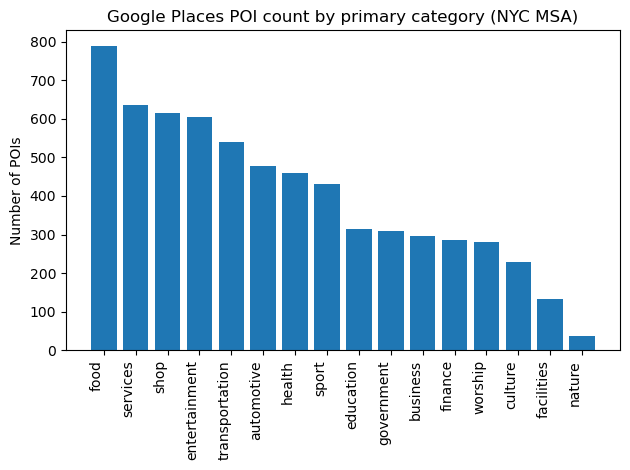

In [691]:
import matplotlib.pyplot as plt

counts = (
    google_placescat_5000
    .groupby("primary_cat")
    .size()
    .sort_values(ascending=False)
)

plt.figure()
plt.bar(counts.index, counts.values)
plt.xticks(rotation=90, ha="right")
plt.ylabel("Number of POIs")
plt.title("Google Places POI count by primary category (NYC MSA)")
plt.tight_layout()
plt.show()


In [693]:
import pandas as pd

# 每个 (primary_cat, circle_id) 对应的 POI 数
cat_circle_counts = (
    google_placescat_5000
    .groupby(["primary_cat", "circle_id"])
    .size()
    .reset_index(name="n")
)
cat_circle_counts

,primary_cat,circle_id,n
0,automotive,0,20
1,automotive,1,2
2,automotive,2,20
3,automotive,3,8
4,automotive,5,1
...,...,...,...
575,worship,40,4
576,worship,41,1
577,worship,42,2
578,worship,43,1


In [9]:
us_cbsa = gpd.read_file("/Users/houpuli/Downloads/Core_based_statistical_area_for_the_US_July_2023_4764927935501855778.geojson")
us_msa = us_cbsa[us_cbsa['CBSATYPE'] == 'Metropolitan Statistical Area']
msa_ny = us_msa[us_msa['CBSACODE']=='35620']

In [10]:
min_lon, max_lon = -75.195498, -71.777492
min_lat, max_lat = 39.475206, 41.527202
R = 5000  # meters

circles = circle_center(
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
    R=R,
    base=msa_ny
)

circles

,geometry,center_lon,center_lat
0,"POLYGON ((-74.38701 39.50987, -74.38703 39.509...",-74.431930,39.509868
1,"POLYGON ((-74.29718 39.50987, -74.29720 39.509...",-74.342098,39.509868
2,"POLYGON ((-74.20735 39.50987, -74.20736 39.509...",-74.252267,39.509868
3,"POLYGON ((-74.11752 39.50987, -74.11753 39.509...",-74.162435,39.509868
4,"POLYGON ((-74.38701 39.57914, -74.38703 39.578...",-74.431930,39.579140
...,...,...,...
452,"POLYGON ((-73.84803 41.49056, -73.84804 41.489...",-73.892941,41.490563
453,"POLYGON ((-73.75819 41.49056, -73.75821 41.489...",-73.803109,41.490563
454,"POLYGON ((-73.66836 41.49056, -73.66838 41.489...",-73.713278,41.490563
455,"POLYGON ((-73.57853 41.49056, -73.57854 41.489...",-73.623446,41.490563


In [11]:
def classify_circle(n):
    if n == 20:
        return "20"
    elif n < 15:
        return "1-15"
    else:
        return "15-19"
    
cat_circle_counts["bin"] = cat_circle_counts["n"].apply(classify_circle)
summary = (
    cat_circle_counts
    .groupby(["primary_cat", "bin"])
    .size()
    .unstack(fill_value=0)
)
summary['per_0'] = (len(circles)-(summary['1-15'] + summary['15-19'] + summary['20'])) / (len(circles))
summary['per_1_15'] = summary['1-15'] / (len(circles))
summary['per_15_19'] = summary['15-19'] / (len(circles))
summary['per_20'] = summary['20'] / (len(circles))
summary

bin,1-15,15-19,20,per_0,per_1_15,per_15_19,per_20
primary_cat,,,,,,,
automotive,96,18,267,0.166302,0.210066,0.039387,0.584245
business,166,41,152,0.214442,0.363239,0.089716,0.332604
culture,232,34,110,0.177243,0.507659,0.074398,0.240700
education,154,24,175,0.227571,0.336980,0.052516,0.382932
entertainment,54,33,318,0.113786,0.118162,0.072210,0.695842
facilities,272,10,35,0.306346,0.595186,0.021882,0.076586
finance,105,23,225,0.227571,0.229759,0.050328,0.492341
food,75,307,1,0.161926,0.164114,0.671772,0.002188
government,128,30,222,0.168490,0.280088,0.065646,0.485777


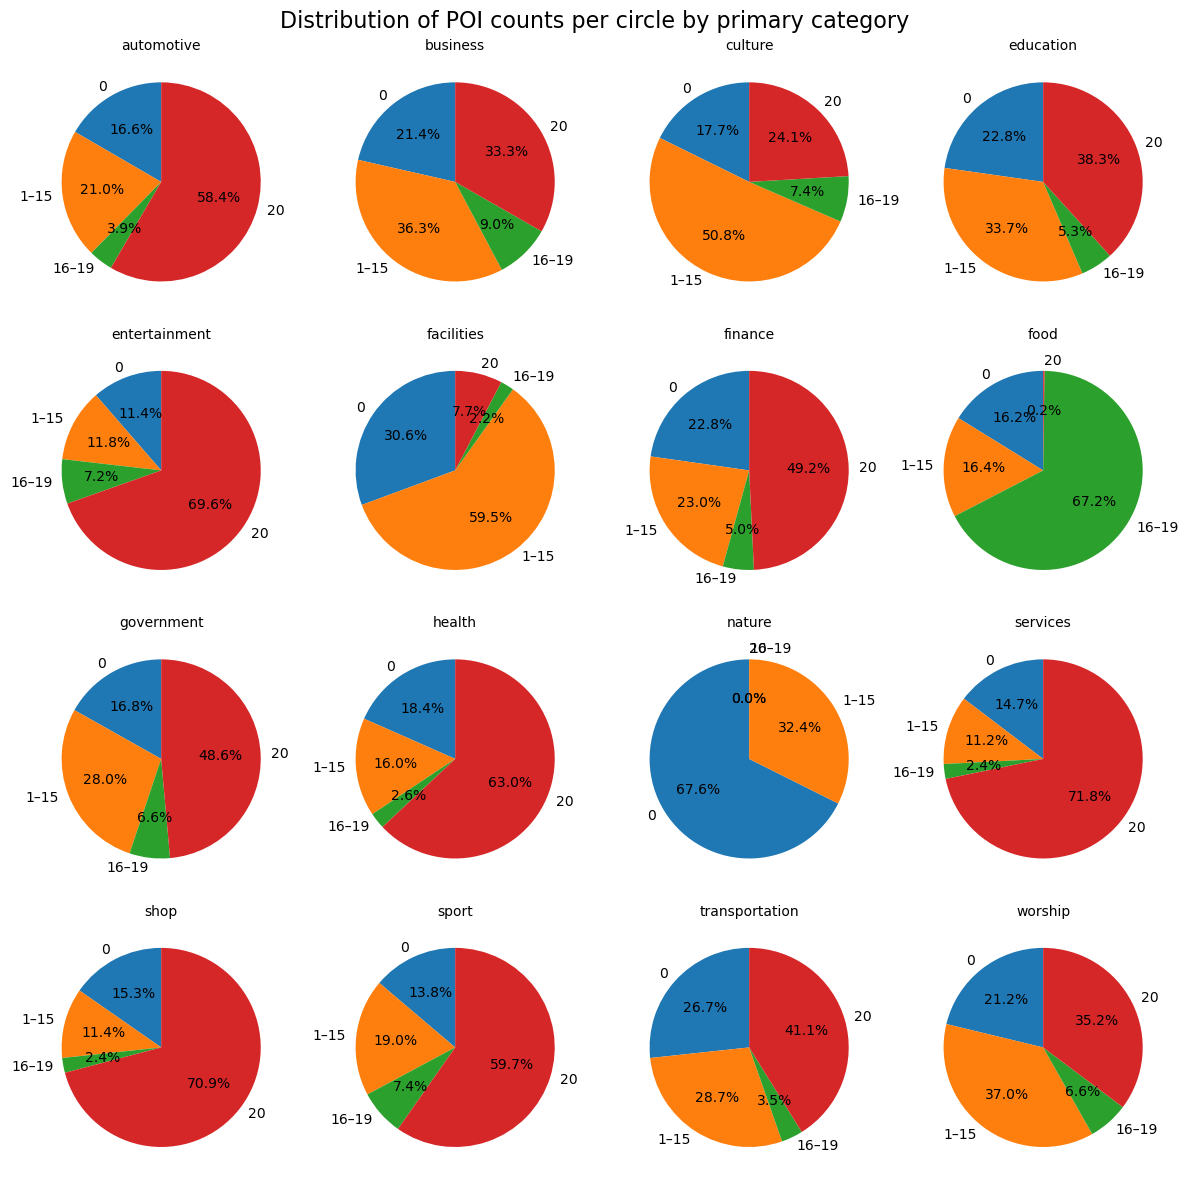

In [ ]:
import matplotlib.pyplot as plt

cols = ['per_0', 'per_1_15', 'per_15_19', 'per_20']
labels = ['0', '1–15', '16–19', '20']

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for ax, (cat, row) in zip(axes, summary[cols].iterrows()):
    ax.pie(
        row.values,
        labels=labels,
        autopct='%.1f%%',
        startangle=90
    )
    ax.set_title(cat, fontsize=10)
    ax.axis('equal')

for ax in axes[len(summary):]:
    ax.axis('off')

plt.suptitle("Distribution of POI counts per circle by primary category", fontsize=16)
plt.tight_layout()
plt.show()

# Filter the duplicated points in google place

In [130]:
table_blist = ["administrative_area_level_3", "administrative_area_level_4", "administrative_area_level_5", "administrative_area_level_6", "administrative_area_level_7", "archipelago", "colloquial_area", "continent", "establishment", "finance", "food", "general_contractor",
"geocode", "health", "intersection", "landmark", "natural_feature", "neighborhood", "place_of_worship", "plus_code"	, "point_of_interest", "political", "postal_code_prefix", "postal_code_suffix", "postal_town", "premise", "route", "street_address", "sublocality", "sublocality_level_1",
"sublocality_level_2", "sublocality_level_3", "sublocality_level_4", "sublocality_level_5", "subpremise", "town_square"]

In [131]:
CAT_TO_TYPES = {
    "automotive": ["car_dealer", "car_rental", "car_repair", "car_wash","electric_vehicle_charging_station", "gas_station","parking", "rest_stop"],
    "business": ["corporate_office", "farm", "ranch"],
    "culture": ["art_gallery", "art_studio", "auditorium", "cultural_landmark","historical_place", "monument", "museum","performing_arts_theater", "sculpture"],
    "education": ["library", "preschool", "primary_school","school", "secondary_school", "university"],
    "entertainment": ["adventure_sports_center", "amphitheatre", "amusement_center","amusement_park", "aquarium", "banquet_hall", "barbecue_area","botanical_garden", "bowling_alley", "casino", "childrens_camp","comedy_club", "community_center", "concert_hall","convention_center", "cultural_center", "cycling_park","dance_hall", "dog_park", "event_venue", "ferris_wheel","garden", "hiking_area", "historical_landmark","internet_cafe", "karaoke", "marina", "movie_rental","movie_theater", "national_park", "night_club","observation_deck", "off_roading_area", "opera_house","park", "philharmonic_hall", "picnic_ground","planetarium", "plaza", "roller_coaster","skateboard_park", "state_park", "tourist_attraction","video_arcade", "visitor_center", "water_park","wedding_venue", "wildlife_park", "wildlife_refuge", "zoo"],
    "facilities": ["public_bath", "public_bathroom", "stable"],
    "finance": ["accounting", "atm", "bank"],
    "food": ["acai_shop","afghani_restaurant","african_restaurant","american_restaurant","asian_restaurant","bagel_shop","bakery","bar","bar_and_grill","barbecue_restaurant","brazilian_restaurant","breakfast_restaurant","brunch_restaurant","buffet_restaurant","cafe","cafeteria","candy_store","cat_cafe","chinese_restaurant","chocolate_factory","chocolate_shop","coffee_shop","confectionery","deli","dessert_restaurant","dessert_shop","diner","dog_cafe","donut_shop","fast_food_restaurant","fine_dining_restaurant","food_court",],         
    "government": ["city_hall","courthouse","embassy","fire_station","government_office","local_government_office","police","post_office"],
    "health": ["chiropractor","dental_clinic","dentist","doctor","drugstore","hospital", "massage","medical_lab","pharmacy", "physiotherapist","sauna","skin_care_clinic","spa","tanning_studio","wellness_center","yoga_studio"],
    "nature": ["beach"],
    "worship": ["church", "hindu_temple", "mosque", "synagogue"],
    "services": ["astrologer","barber_shop","beautician","beauty_salon","body_art_service","catering_service","cemetery","child_care_agency","consultant","courier_service","electrician","florist","food_delivery","foot_care","funeral_home","hair_care","hair_salon","insurance_agency","laundry","lawyer","locksmith","makeup_artist","moving_company","nail_salon","painter","plumber","psychic","real_estate_agency","roofing_contractor","storage","summer_camp_organizer","tailor","telecommunications_service_provider","tour_agency","tourist_information_center","travel_agency","veterinary_care"],
    "shop": ["asian_grocery_store","auto_parts_store","bicycle_store","book_store","butcher_shop","cell_phone_store","clothing_store","convenience_store","department_store","discount_store","electronics_store","food_store","furniture_store","gift_shop","grocery_store","hardware_store","home_goods_store","home_improvement_store","jewelry_store","liquor_store","market","pet_store","shoe_store","shopping_mall","sporting_goods_store","store","supermarket","warehouse_store","wholesaler"],
    "sport": ["arena","athletic_field","fishing_charter","fishing_pond","fitness_center","golf_course","gym","ice_skating_rink","playground","ski_resort","sports_activity_location","sports_club","sports_coaching","sports_complex","stadium","swimming_pool",],
    "transportation": ["airport","airstrip","bus_station","bus_stop","ferry_terminal","heliport","international_airport","light_rail_station","park_and_ride","subway_station","taxi_stand","train_station","transit_depot","transit_station","truck_stop",]
}

df = google_placescat_5000.copy()
dup_mask = df.duplicated(subset="id", keep=False)

def is_valid_type(row, cat_to_types):
    cat = row["primary_cat"]
    ptype = row["primary_type"]
    if cat not in cat_to_types:
        return False
    return ptype in cat_to_types[cat]

df["valid_type"] = True
df.loc[dup_mask, "valid_type"] = df.loc[dup_mask].apply(is_valid_type, axis=1, cat_to_types=CAT_TO_TYPES)
df_clean = df[(~dup_mask) | (df["valid_type"])].drop(columns="valid_type")

df_clean = df_clean.drop_duplicates(subset="id", keep="first")
df_clean = df_clean[~df_clean["primary_type"].isin(table_blist)].reset_index(drop=True)

In [138]:
ny_gplc = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/google_placescat_5000_clean.geojson')

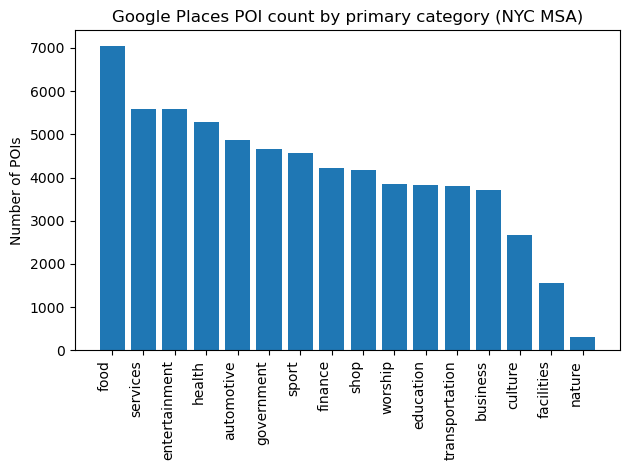

In [34]:
import matplotlib.pyplot as plt

counts = (
    ny_gplc
    .groupby("primary_cat")
    .size()
    .sort_values(ascending=False)
)

plt.figure()
plt.bar(counts.index, counts.values)
plt.xticks(rotation=90, ha="right")
plt.ylabel("Number of POIs")
plt.title("Google Places POI count by primary category (NYC MSA)")
plt.tight_layout()
plt.show()


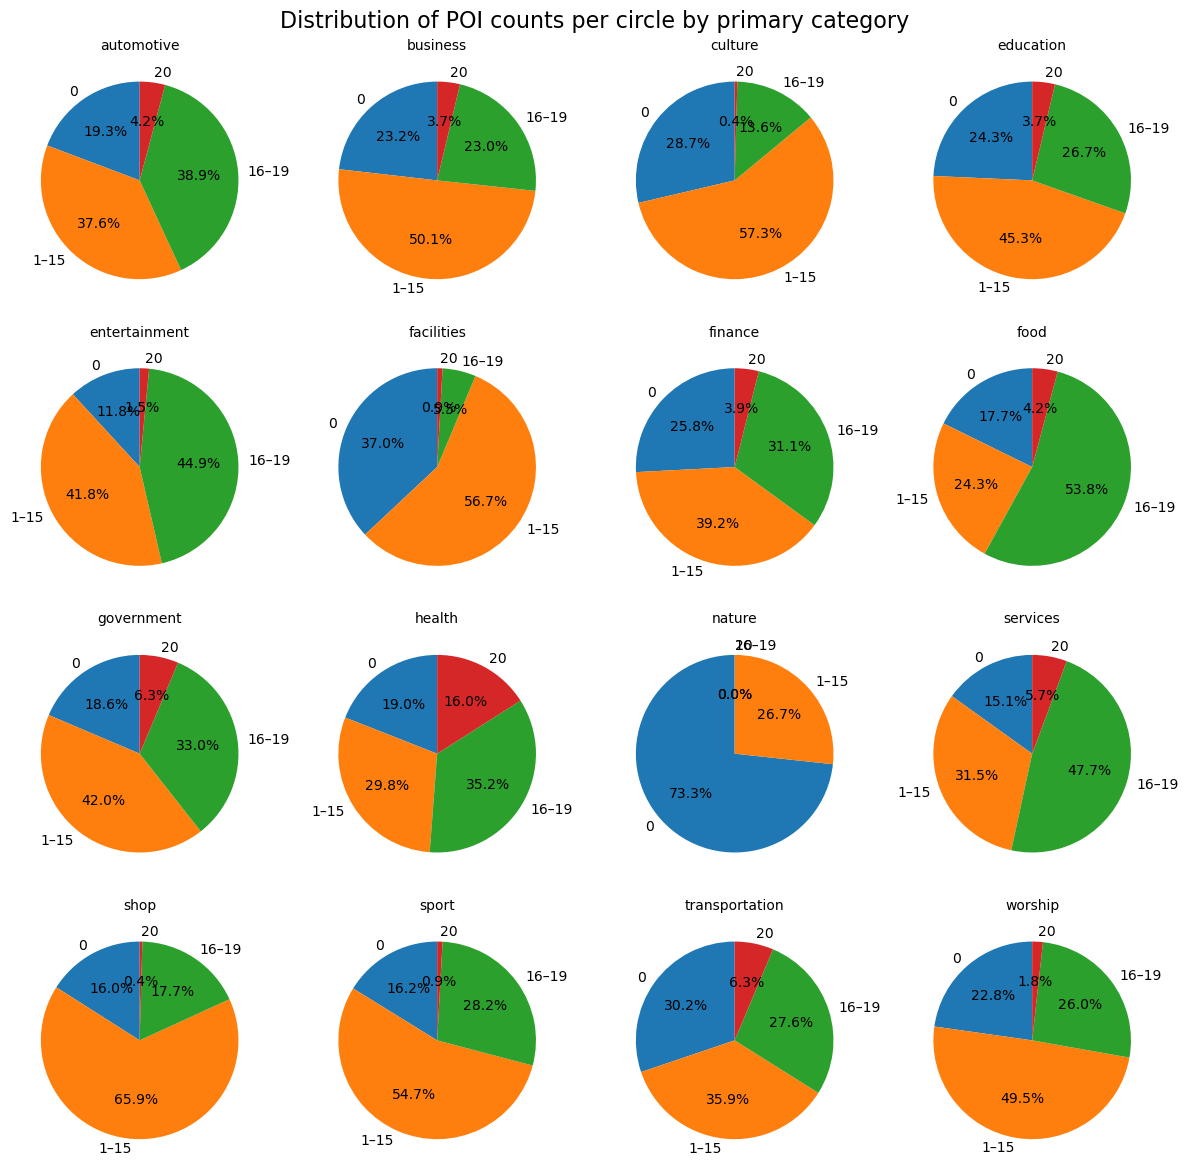

In [36]:
import pandas as pd

# 每个 (primary_cat, circle_id) 对应的 POI 数
cat_circle_counts = (
    ny_gplc
    .groupby(["primary_cat", "circle_id"])
    .size()
    .reset_index(name="n")
)

def classify_circle(n):
    if n == 20:
        return "20"
    elif n < 15:
        return "1-15"
    else:
        return "15-19"
    
cat_circle_counts["bin"] = cat_circle_counts["n"].apply(classify_circle)
summary = (
    cat_circle_counts
    .groupby(["primary_cat", "bin"])
    .size()
    .unstack(fill_value=0)
)
summary['per_0'] = (len(circles)-(summary['1-15'] + summary['15-19'] + summary['20'])) / (len(circles))
summary['per_1_15'] = summary['1-15'] / (len(circles))
summary['per_15_19'] = summary['15-19'] / (len(circles))
summary['per_20'] = summary['20'] / (len(circles))

import matplotlib.pyplot as plt

cols = ['per_0', 'per_1_15', 'per_15_19', 'per_20']
labels = ['0', '1–15', '16–19', '20']

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for ax, (cat, row) in zip(axes, summary[cols].iterrows()):
    ax.pie(
        row.values,
        labels=labels,
        autopct='%.1f%%',
        startangle=90
    )
    ax.set_title(cat, fontsize=10)
    ax.axis('equal')

for ax in axes[len(summary):]:
    ax.axis('off')

plt.suptitle("Distribution of POI counts per circle by primary category", fontsize=16)
plt.tight_layout()
plt.show()

## crosswalk

### Input Dataset

In [12]:
ny_gplc = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/google_placescat_5000_clean.geojson')
ny_gplc['addr_simple'] = ny_gplc['address'].str.split(',', n=1).str[0]
ny_gplc

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,addr_simple
0,0,ChIJz2WoQWPkwIkRBJ3miPA5ahs,Spirit,"14 S New York Rd, Absecon, NJ 08205, USA",gas_station,39.491219,-74.457829,automotive,POINT (-74.45783 39.49122),14 S New York Rd
1,0,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,"167 S New York Rd, Absecon, NJ 08205, USA",car_repair,39.472252,-74.460912,automotive,POINT (-74.46091 39.47225),167 S New York Rd
2,0,ChIJybcilkTkwIkREudTyhAsa5Q,Frank Dean Automotive,"145 Old Port Republic Rd, Galloway, NJ 08205, USA",car_repair,39.476918,-74.465489,automotive,POINT (-74.46549 39.47692),145 Old Port Republic Rd
3,2,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,"5500-5598 S Long Beach Blvd, Long Beach, NJ 08...",parking,39.532222,-74.262475,automotive,POINT (-74.26248 39.53222),5500-5598 S Long Beach Blvd
4,2,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,"6805 S Long Beach Blvd, Long Beach, NJ 08008, USA",parking,39.531471,-74.262935,automotive,POINT (-74.26293 39.53147),6805 S Long Beach Blvd
...,...,...,...,...,...,...,...,...,...,...
65675,452,ChIJexEE0P823YkR-27f_ozfLw0,Route 9 N & Schuyler Blvd Hotels,"Fishkill, NY 12524, USA",bus_stop,41.526371,-73.891182,transportation,POINT (-73.89118 41.52637),Fishkill
65676,454,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,"Unnamed Road, Holmes, NY 12531, USA",park_and_ride,41.507060,-73.679592,transportation,POINT (-73.67959 41.50706),Unnamed Road
65677,455,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,"Patterson, NY 12563, USA",train_station,41.511741,-73.604266,transportation,POINT (-73.60427 41.51174),Patterson
65678,455,ChIJP6Yh70tQ3YkROQ_4xOEmIRY,Park & Ride,"NY-311, Patterson, NY 12563, USA",park_and_ride,41.474254,-73.643322,transportation,POINT (-73.64332 41.47425),NY-311


In [30]:
ny_fsq_msa = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_fsq.geojson')
ny_fsq_msa

,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,facebook_id,instagram,twitter,fsq_category_ids,fsq_category_labels,placemaker_url,unresolved_flags,geom,bbox,geometry
0,4a6e1308f964a520d8d31fe3,Taan Thai Cuisine,40.746072,-73.984882,17 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d149941735],[Dining and Drinking > Restaurant > Asian Rest...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8IUJc9mkBEX39LQHHp,"{'xmin': '-73.98488249559014', 'ymin': '40.746...",POINT (-73.98488 40.74607)
1,4fc8bb8de4b0936e6f5fb166,Maxifier,40.745854,-73.984607,130 Madison Ave,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8DzxzYSEBEX3ghkfAx,"{'xmin': '-73.98460748497848', 'ymin': '40.745...",POINT (-73.98461 40.74585)
2,4ba7b867f964a520e8ac39e3,Sunshine Sachs,40.745991,-73.984504,136 Madison Ave,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,"[4bf58dd8d48988d124941735, 4bf58dd8d48988d1309...","[Business and Professional Services > Office, ...",https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8CHyD2ZUBEX3yhssiK,"{'xmin': '-73.98450449198715', 'ymin': '40.745...",POINT (-73.98450 40.74599)
3,529ba9b411d2c184dc1c79c2,Bella Minds HQ,40.746021,-73.984396,"136 Madison, 5th Floor Suite 548",New York,NY,10016,NaN,NaN,...,NaN,NaN,bellaminds,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8AVrlW9EBEX32fXDVl,"{'xmin': '-73.98439567660881', 'ymin': '40.746...",POINT (-73.98440 40.74602)
4,530b7c6d11d200e77d5f16c3,The Bakery Design Lab at Smartling,40.746021,-73.984396,136 Madison Ave,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8AVrlW9EBEX32fXDVl,"{'xmin': '-73.98439567660881', 'ymin': '40.746...",POINT (-73.98440 40.74602)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080296,13fc496dea484e814cf87de8,Lim's Graphic Co.,40.745899,-73.984915,20 E 31st St,New York,NY,10016,NaN,NaN,...,1.566488e+14,NaN,NaN,[63be6904847c3692a84b9b90],[Business and Professional Services > Technolo...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8I2OTJakBEX3mgcgmy,"{'xmin': '-73.98491499273737', 'ymin': '40.745...",POINT (-73.98491 40.74590)
2080297,51d4e35c498e004fa7874cd6,Korean Restaurant Bar,40.745983,-73.985278,NaN,New York,NY,NaN,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d116941735],[Dining and Drinking > Bar],https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8Oy3Td+EBEX3xe9i+d,"{'xmin': '-73.985278', 'ymin': '40.745983', 'x...",POINT (-73.98528 40.74598)
2080298,4f3282f819836c91c7def820,Blimpie,40.746005,-73.985006,17 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d16e941735],[Dining and Drinking > Restaurant > Fast Food ...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8KWJWXrEBEX30U42ls,"{'xmin': '-73.9850064717163', 'ymin': '40.7460...",POINT (-73.98501 40.74600)
2080299,4dfa9a851f6eeef806a85783,Manhattan Sikh Association,40.746005,-73.985006,18 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,NaN,[4bf58dd8d48988d171941735],[Business and Professional Services > Event Sp...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8KWJWXrEBEX30U42ls,"{'xmin': '-73.9850064717163', 'ymin': '40.7460...",POINT (-73.98501 40.74600)


In [31]:
ny_ove_msa = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_ove.geojson')
ny_ove_msa = ny_ove_msa.rename(columns={'names':'name'})
ny_ove_msa

,id,name,confidence,cat_main,cat_alt,address,operating_status,version,sources,geometry
0,06e0f3c1-b654-425f-9588-a1bd8943534a,EasyGenie,0.570194,genealogists,NaN,,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
1,0d8bbca1-0a0e-4b7a-b3d7-2fe74be2ecfb,Bible Nook,0.570194,religious_organization,bookstore,,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
2,e529a474-ed71-4462-a5da-0d30e5494ad4,Hitched Hiking marriage ministry,0.570194,community_services_non_profits,life_coach,,open,2,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
3,cea6de5f-6543-4690-8f19-786d8e95a8fb,TICA Northeast Region,0.570194,community_services_non_profits,public_and_government_association,,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.42188 39.90974)
4,afb616d6-e780-4539-9009-d7880a767c0f,Indigo Studio,0.570194,cosmetic_and_beauty_supplies,social_media_agency,"Roselle Park Environmental Commission, 110 E W...",open,1,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-72.66357 39.92238)
...,...,...,...,...,...,...,...,...,...,...
1083610,102b252e-5737-4b6d-91db-08849ece5da3,Sure Design,0.950063,printing_services,professional_services,5027 Industrial Rd,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-74.12314 40.18954)
1083611,09351d28-ba24-4a4c-9284-f0d912ab112a,ITAK Heating & Cooling,0.950063,hvac_services,"contractor, plumbing",5027 Industrial Rd,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-74.12321 40.18954)
1083612,414bafb2-51a1-4b9d-84d8-6320f26bd42b,J. McGinley Company,0.950063,industrial_equipment,"iron_and_steel_industry, automotive",5023 Industrial Rd,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-74.12221 40.18989)
1083613,2c9b4e95-a646-4147-b44b-9aebf0568930,ITAK Heating & Cooling,0.770000,hvac_services,NaN,"Lower Level, 5027 Industrial Rd Unit 6",open,4,"[ { ""property"": """", ""dataset"": ""Microsoft"", ""l...",POINT (-74.12312 40.18928)


### Filered in NYC

In [397]:
nyc_ct = gpd.read_file('/Users/houpuli/Downloads/Borough_Boundaries_20260103.geojson')
nyc_ct_geom = nyc_ct.dissolve()
nyc_ct_geom = nyc_ct_geom[['geometry']]
nyc_ct_geom

,geometry
0,"MULTIPOLYGON (((-74.04924 40.56536, -74.05003 ..."


In [398]:
nyc_gplc = ny_gplc.sjoin(nyc_ct_geom, how='inner', predicate='intersects')
nyc_gplc

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,index_right,addr_simple
1218,123,ChIJ8w3NDia1w4kRhnVZl5tAfqg,Car Craft Truck Works,"528 Industrial Loop W, Staten Island, NY 10309...",car_repair,40.547628,-74.230630,automotive,POINT (-74.23063 40.54763),0,528 Industrial Loop W
1225,123,ChIJVwCAH0S1w4kRqKJCEATkz8Y,AutoZone Auto Parts,"3011 Veterans Rd W, Staten Island, NY 10309, USA",auto_parts_store,40.527591,-74.235349,automotive,POINT (-74.23535 40.52759),0,3011 Veterans Rd W
1228,124,ChIJxdAZJZ1LwokRy1SwkOtk1Is,Costco Gas Station,"HRFJ+4FG, 2975 Richmond Ave #316b, Staten Isla...",gas_station,40.571419,-74.169387,automotive,POINT (-74.16939 40.57142),0,HRFJ+4FG
1229,124,ChIJvTY4iqBLwokRfl0Mr6nRX-c,Mobil,"868 Arthur Kill Rd, Staten Island, NY 10312, USA",gas_station,40.560717,-74.169261,automotive,POINT (-74.16926 40.56072),0,868 Arthur Kill Rd
1230,124,ChIJG-MSV-hKwokRGFs4POFn3e8,Huguenot Parking,"Parking lot, Staten Island, NY 10312, USA",parking,40.535025,-74.191758,automotive,POINT (-74.19176 40.53502),0,Parking lot
...,...,...,...,...,...,...,...,...,...,...,...
63217,254,ChIJo1zn59nywokR52Wq9marZZU,Nereid Av,"Bronx, NY, USA",transit_station,40.898478,-73.854491,transportation,POINT (-73.85449 40.89848),0,Bronx
63219,254,ChIJQyN45tnywokR7Q-tc0gr1vU,Nereid Av/White Plains Rd,"Bronx, NY 10466, USA",bus_stop,40.898503,-73.854704,transportation,POINT (-73.85470 40.89850),0,Bronx
63220,254,ChIJnfbCa9eMwokRTX34bq9FfLg,Light St @ Dyre Ave,"Bronx, NY 10466, USA",bus_stop,40.887862,-73.831040,transportation,POINT (-73.83104 40.88786),0,Bronx
63221,254,ChIJlYs-ZgCNwokRDXrhiCmjpi4,Gun Hill Bus Depot,"1910 Bartow Ave, Bronx, NY 10469, USA",transit_depot,40.867312,-73.833205,transportation,POINT (-73.83320 40.86731),0,1910 Bartow Ave


In [ ]:
nyc_ove = ny_ove_msa.sjoin(nyc_ct_geom, how='inner', predicate='intersects')
nyc_ove = nyc_ove.rename(columns={'names':'name'})
nyc_ove


,id,name,confidence,cat_main,cat_alt,address,operating_status,version,sources,geometry,index_right
90306,f162e5c4-4331-487a-9abe-e6e87dc92e63,National Black Theatre of Harlem,0.323479,cinema,"theatre, topic_concert_venue",2031 5th Ave,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.94190 40.80653),0
90307,4db2e985-ccc9-4c26-b88e-92b75e69d994,Western Union,0.770000,money_transfer_services,NaN,3 E 125th St,open,4,"[ { ""property"": """", ""dataset"": ""Microsoft"", ""l...",POINT (-73.94185 40.80652),0
90308,44119d59-a57a-4da9-8db7-31d905744691,Holy Ghost Pentecostal Faith Church,0.988514,church_cathedral,religious_organization,13 E 125th St,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.94178 40.80634),0
90309,e40bbd9f-aa72-4287-8321-28ef65724e07,Bonny Nails Spa,0.639236,nail_salon,NaN,11 E 125th St,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.94170 40.80637),0
90310,f747282f-4997-4c7a-85a3-17cb2fa5e73a,Parents at The Gathering Harlem,0.323479,church_cathedral,NaN,2031 5th Ave,open,6,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.94167 40.80646),0
...,...,...,...,...,...,...,...,...,...,...,...
852983,b6fb6000-bd4a-4a9d-9694-a535df93d0d0,Green Rush Daily,0.950063,media_news_company,"topic_publisher, print_media",119 W 24th St,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.99321 40.74419),0
852984,6c5f2d6f-7cf8-4cae-8971-9ed768d61da2,Stacklist,0.570194,software_development,"construction_services, professional_services",119 W 24th St,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.99321 40.74419),0
852985,d39fce50-2fd1-4d3b-b753-2ea132a59991,University Beyond,0.323479,college_university,"education, professional_services",119 W 24th St,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.99321 40.74419),0
852986,03904f78-7347-4c95-b2a6-5252a9e788fa,Nomad Financial,0.770000,financial_service,NaN,119 W 24th St,open,2,"[ { ""property"": """", ""dataset"": ""Foursquare"", ""...",POINT (-73.99320 40.74419),0


In [400]:
nyc_fsq = ny_fsq_msa.sjoin(nyc_ct_geom, how='inner', predicate='intersects')
nyc_fsq

,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,instagram,twitter,fsq_category_ids,fsq_category_labels,placemaker_url,unresolved_flags,geom,bbox,geometry,index_right
0,4a6e1308f964a520d8d31fe3,Taan Thai Cuisine,40.746072,-73.984882,17 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,[4bf58dd8d48988d149941735],[Dining and Drinking > Restaurant > Asian Rest...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8IUJc9mkBEX39LQHHp,"{'xmin': '-73.98488249559014', 'ymin': '40.746...",POINT (-73.98488 40.74607),0
1,4fc8bb8de4b0936e6f5fb166,Maxifier,40.745854,-73.984607,130 Madison Ave,New York,NY,10016,NaN,NaN,...,NaN,NaN,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8DzxzYSEBEX3ghkfAx,"{'xmin': '-73.98460748497848', 'ymin': '40.745...",POINT (-73.98461 40.74585),0
2,4ba7b867f964a520e8ac39e3,Sunshine Sachs,40.745991,-73.984504,136 Madison Ave,New York,NY,10016,NaN,NaN,...,NaN,NaN,"[4bf58dd8d48988d124941735, 4bf58dd8d48988d1309...","[Business and Professional Services > Office, ...",https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8CHyD2ZUBEX3yhssiK,"{'xmin': '-73.98450449198715', 'ymin': '40.745...",POINT (-73.98450 40.74599),0
3,529ba9b411d2c184dc1c79c2,Bella Minds HQ,40.746021,-73.984396,"136 Madison, 5th Floor Suite 548",New York,NY,10016,NaN,NaN,...,NaN,bellaminds,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8AVrlW9EBEX32fXDVl,"{'xmin': '-73.98439567660881', 'ymin': '40.746...",POINT (-73.98440 40.74602),0
4,530b7c6d11d200e77d5f16c3,The Bakery Design Lab at Smartling,40.746021,-73.984396,136 Madison Ave,New York,NY,10016,NaN,NaN,...,NaN,NaN,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8AVrlW9EBEX32fXDVl,"{'xmin': '-73.98439567660881', 'ymin': '40.746...",POINT (-73.98440 40.74602),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080296,13fc496dea484e814cf87de8,Lim's Graphic Co.,40.745899,-73.984915,20 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,[63be6904847c3692a84b9b90],[Business and Professional Services > Technolo...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8I2OTJakBEX3mgcgmy,"{'xmin': '-73.98491499273737', 'ymin': '40.745...",POINT (-73.98491 40.74590),0
2080297,51d4e35c498e004fa7874cd6,Korean Restaurant Bar,40.745983,-73.985278,NaN,New York,NY,NaN,NaN,NaN,...,NaN,NaN,[4bf58dd8d48988d116941735],[Dining and Drinking > Bar],https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8Oy3Td+EBEX3xe9i+d,"{'xmin': '-73.985278', 'ymin': '40.745983', 'x...",POINT (-73.98528 40.74598),0
2080298,4f3282f819836c91c7def820,Blimpie,40.746005,-73.985006,17 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,[4bf58dd8d48988d16e941735],[Dining and Drinking > Restaurant > Fast Food ...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8KWJWXrEBEX30U42ls,"{'xmin': '-73.9850064717163', 'ymin': '40.7460...",POINT (-73.98501 40.74600),0
2080299,4dfa9a851f6eeef806a85783,Manhattan Sikh Association,40.746005,-73.985006,18 E 31st St,New York,NY,10016,NaN,NaN,...,NaN,NaN,[4bf58dd8d48988d171941735],[Business and Professional Services > Event Sp...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8KWJWXrEBEX30U42ls,"{'xmin': '-73.9850064717163', 'ymin': '40.7460...",POINT (-73.98501 40.74600),0


### Spatial index searching

In [ ]:
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree


def search_spatial_candidates(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    k: int = 100,
    id_col: str = "id",
    crs_for_distance: int = 3857,
):
    """
    Attach k nearest compared POI ids & distances to reference_gdf.

    Returns
    -------
    GeoDataFrame with two new columns:
    - cand_ids   : list of compared ids
    - cand_dist_m: list of distances (meters)
    """

    ref_proj = reference_gdf.to_crs(crs_for_distance)
    cmp_proj = compared_gdf.to_crs(crs_for_distance)

    ref_xy = np.column_stack([ref_proj.geometry.x, ref_proj.geometry.y])
    cmp_xy = np.column_stack([cmp_proj.geometry.x, cmp_proj.geometry.y])

    tree = cKDTree(cmp_xy)
    k_eff = min(k, len(compared_gdf))

    dist, idx = tree.query(ref_xy, k=k_eff)

    if k_eff == 1:
        dist = dist.reshape(-1, 1)
        idx = idx.reshape(-1, 1)

    cmp_ids = compared_gdf[id_col].to_numpy()

    result = reference_gdf.copy()
    result["cand_ids"] = [[cmp_ids[j] for j in row] for row in idx]
    result["cand_dist_m"] = dist.tolist()

    return result

In [ ]:
nyc_gplc_ove = search_spatial_candidates(nyc_gplc,nyc_ove,k=100)

In [ ]:
nyc_gplc_fsq = search_spatial_candidates(nyc_gplc,nyc_fsq,k=100,id_col='fsq_place_id')

### name_matching

In [23]:

from rapidfuzz import process, fuzz
import pandas as pd

def match_by_name(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    re_name_col: str = "name",
    com_name_col: str = "name",
    id_col: str = "id",
    threshold: int = 80,
):
    """
    Perform WRatio name matching within spatial candidates.

    Returns
    -------
    GeoDataFrame with:
    - matched_id_name
    - name_score
    """

    id_to_name = compared_gdf.set_index(id_col)[com_name_col].to_dict()

    matched_ids = []
    scores = []
    loc_dists = []
    matched_names = []

    for _, row in reference_gdf.iterrows():
        query = row.get(re_name_col)

        if not isinstance(query, str) or not row["cand_ids"]:
            matched_ids.append(pd.NA)
            scores.append(pd.NA)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)
            continue

        cand_names = [id_to_name.get(cid, "") for cid in row["cand_ids"]]

        match, score, pos = process.extractOne(
            query,
            cand_names,
            scorer=fuzz.WRatio
        )

        if score >= threshold:
            matched_ids.append(row["cand_ids"][pos])
            scores.append(score)
            loc_dists.append(row["cand_dist_m"][pos])
            matched_names.append(cand_names[pos])
        else:
            matched_ids.append(pd.NA)
            scores.append(score)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)

    result = reference_gdf.copy()
    result["matched_id"] = matched_ids
    result["name_score"] = scores
    result["location_distance"] = loc_dists
    result["matched_name"] = matched_names

    return result

### name_matching_debugging

In [706]:
FOOD_WORDS = {
    "RESTAURANT","RESTURANT","RESTARAUNT",
    "CAFE","CAFÉ","COFFEE","BAR","BISTRO","GRILL",
    "KITCHEN","DINER","EATERY","STEAKHOUSE",
    "SEAFOOD","BUFFET","BBQ","PIZZA","SUSHI","RAMEN",
    "NOODLE","NOODLES","BURGER","BURGERS","TACO","TACOS",
    "CHICKEN","WINGS","BAKERY","DELI","DELICATESSEN",
    "COURT","FOOD","EXPRESS","HOUSE","SHOP"
}

PLACE_WORDS = {
    "HALL","CENTER","CENTRE","PLAZA","MARKET","MALL",
    "GARDEN","GARDENS","PARK","SQUARE","TOWER","TOWERS",
    "STATION","TERMINAL","BUILDING","GALLERY","THEATER","SCHOOL","COURT","INN",
    "HOTEL","MOTEL","INN","SUITES","SUITE",
    "SPA","SALON","STUDIO","CENTER","CENTRE",
    "CLUB","LOUNGE","STATION","STOP"
}

LEGAL_WORDS = {
    "LLC","INC","CORP","CORPORATION","CO","COMPANY",
    "LTD","LIMITED","GROUP","HOLDINGS","OFFICE"
}

GRAMMAR = {
    "THE","OF","AT","AND","FOR","IN","ON","BY","WITH","TO","FROM"
}

NON_PRIMARY_TOKENS = FOOD_WORDS | PLACE_WORDS | LEGAL_WORDS | GRAMMAR
NON_PRIMARY_TOKENS

{'AND',
 'AT',
 'BAKERY',
 'BAR',
 'BBQ',
 'BISTRO',
 'BUFFET',
 'BUILDING',
 'BURGER',
 'BURGERS',
 'BY',
 'CAFE',
 'CAFÉ',
 'CENTER',
 'CENTRE',
 'CHICKEN',
 'CLUB',
 'CO',
 'COFFEE',
 'COMPANY',
 'CORP',
 'CORPORATION',
 'COURT',
 'DELI',
 'DELICATESSEN',
 'DINER',
 'EATERY',
 'EXPRESS',
 'FOOD',
 'FOR',
 'FROM',
 'GALLERY',
 'GARDEN',
 'GARDENS',
 'GRILL',
 'GROUP',
 'HALL',
 'HOLDINGS',
 'HOTEL',
 'HOUSE',
 'IN',
 'INC',
 'INN',
 'KITCHEN',
 'LIMITED',
 'LLC',
 'LOUNGE',
 'LTD',
 'MALL',
 'MARKET',
 'MOTEL',
 'NOODLE',
 'NOODLES',
 'OF',
 'OFFICE',
 'ON',
 'PARK',
 'PIZZA',
 'PLAZA',
 'RAMEN',
 'RESTARAUNT',
 'RESTAURANT',
 'RESTURANT',
 'SALON',
 'SCHOOL',
 'SEAFOOD',
 'SHOP',
 'SPA',
 'SQUARE',
 'STATION',
 'STEAKHOUSE',
 'STOP',
 'STUDIO',
 'SUITE',
 'SUITES',
 'SUSHI',
 'TACO',
 'TACOS',
 'TERMINAL',
 'THE',
 'THEATER',
 'TO',
 'TOWER',
 'TOWERS',
 'WINGS',
 'WITH'}

In [ ]:

from rapidfuzz import process, fuzz
import pandas as pd
import re
import unicodedata


def clean_name(s):
    if not isinstance(s, str):
        return ""

    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c)) # 1. unicode normalize (remove accents)
    s = s.upper() # 2. uppercase
    s = re.sub(r"\([^)]*\)", "", s) 
    s = s.encode("ascii", errors="ignore").decode() # 4. remove emoji / non ascii
    s = re.sub(r"[^\w\s]", " ", s) # 5. replace special chars with space
    s = re.sub(r"\s+", " ", s) # 6. collapse spaces

    return s.strip()

def extract_prinmary_str(name):

    tokens = name.split()
    core = [t for t in tokens if t not in NON_PRIMARY_TOKENS]
    if len(core) == 1 and len(core[0]) < 3:
        return name
    if core:
        return " ".join(core)
    return name

def match_by_name(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    re_name_col: str = "name",
    comp_name_col: str = "name",
    id_col: str = "id",
    threshold: int = 80,
):
    """
    Perform WRatio name matching within spatial candidates.

    Returns
    -------
    GeoDataFrame with:
    - matched_id_name
    - name_score
    """

    id_to_name = compared_gdf.set_index(id_col)[comp_name_col].apply(clean_name).apply(extract_prinmary_str).to_dict()

    matched_ids = []
    scores = []
    loc_dists = []
    matched_names = []

    for _, row in reference_gdf.iterrows():
        query = extract_prinmary_str(clean_name(row.get(re_name_col)))

        if not isinstance(query, str) or not row["cand_ids"]:
            matched_ids.append(pd.NA)
            scores.append(pd.NA)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)
            continue

        cand_names = [id_to_name.get(cid, "") for cid in row["cand_ids"]]

        match, wr, pos = process.extractOne(
            query,
            cand_names,
            scorer=fuzz.WRatio
        )

        name = cand_names[pos]
        pr = fuzz.partial_ratio(query, name) 
        ts = fuzz.token_sort_ratio(query, name)
        tset = fuzz.token_set_ratio(query, name)

        score = max(wr, pr, ts, tset) # updates score

        if score >= threshold:
            matched_ids.append(row["cand_ids"][pos])
            scores.append(score)
            loc_dists.append(row["cand_dist_m"][pos])
            matched_names.append(cand_names[pos])
        else:
            matched_ids.append(pd.NA)
            scores.append(score)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)

    result = reference_gdf.copy()
    result["matched_id"] = matched_ids
    result["name_score"] = scores
    result["location_distance"] = loc_dists
    result["matched_name"] = matched_names

    return result

In [239]:
nyc_gplc_ove = match_by_name(nyc_gplc_ove,nyc_ove,threshold=90)

In [254]:
nyc_gplc_fsq = match_by_name(nyc_gplc_fsq,nyc_fsq,threshold=90,id_col='fsq_place_id')

### address_checking

In [7]:
import pandas as pd
import geopandas as gpd
from rapidfuzz import fuzz

def address_score_check(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    addr_col_ref: str = "addr_simple",
    addr_col_cmp: str = "address",
    matched_id_col: str = "matched_id",
    id_col: str = "id",
    out_col: str = "address_score",
    out_addr_col: str = "matched_address", 
    scorer=fuzz.WRatio,
):
    """
    Compute address similarity score (0-100) for already-matched rows.

    Only rows with non-null `matched_id_col` will be scored.
    Others will have NaN.

    Returns
    -------
    GeoDataFrame with a new column `out_col`.
    """

    # map: compared id -> compared address
    id_to_addr = compared_gdf.set_index(id_col)[addr_col_cmp].to_dict()

    scores = []
    matched_addrs = []

    for _, row in reference_gdf.iterrows():
        matched_id = row.get(matched_id_col)

        # no matched id -> no score
        if pd.isna(matched_id):
            scores.append(pd.NA)
            matched_addrs.append(pd.NA)
            continue

        addr_ref = row.get(addr_col_ref)
        addr_cmp = id_to_addr.get(matched_id)

        if isinstance(addr_cmp, str) and addr_cmp.strip():
            matched_addrs.append(addr_cmp)
        else:
            matched_addrs.append(pd.NA)

        # missing address on either side -> no score
        if not isinstance(addr_ref, str) or not addr_ref.strip():
            scores.append(pd.NA)
            continue
        if not isinstance(addr_cmp, str) or not addr_cmp.strip():
            scores.append(pd.NA)
            continue

        scores.append(int(scorer(addr_ref, addr_cmp)))

    result = reference_gdf.copy()
    result[out_col] = scores
    result[out_addr_col] = matched_addrs
    return result

In [242]:
nyc_gplc_ove = address_score_check(nyc_gplc_ove,nyc_ove)

In [256]:
nyc_gplc_fsq = address_score_check(nyc_gplc_fsq,nyc_fsq,id_col='fsq_place_id')

### Aggregating id together

In [259]:
nyc_gplc_ove = nyc_gplc_ove.rename(columns={'cand_ids':'cand_ids_ove',
                                            'cand_dist_m':'cand_dist_m_ove',
                                            'matched_id':'matched_id_ove',
                                            'name_score':'name_score_ove',
                                            'address_score':'address_score_ove',
                                            })

In [261]:
nyc_gplc_fsq = nyc_gplc_fsq.rename(columns={'cand_ids':'cand_ids_fsq',
                                            'cand_dist_m':'cand_dist_m_fsq',
                                            'matched_id':'matched_id_fsq',
                                            'name_score':'name_score_fsq',
                                            'address_score':'address_score_fsq',
                                            })

In [267]:
nyc_gplc_aggr = nyc_gplc.merge(nyc_gplc_ove[['id','matched_id_ove','name_score_ove','address_score_ove']], on='id', how='left').merge(nyc_gplc_fsq[['id','matched_id_fsq','name_score_fsq','address_score_fsq']], on='id', how='left')

In [270]:
nyc_gplc_aggr['matched_id_fsq'].notnull().sum()

3019

In [269]:
nyc_gplc_aggr['matched_id_ove'].notnull().sum()

3546

In [287]:
nyc_gplc_aggr

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,index_right,addr_simple,matched_id_ove,name_score_ove,address_score_ove,matched_id_fsq,name_score_fsq,address_score_fsq,fsq_m,ove_m
0,123,ChIJ8w3NDia1w4kRhnVZl5tAfqg,Car Craft Truck Works,"528 Industrial Loop W, Staten Island, NY 10309...",car_repair,40.547628,-74.230630,automotive,POINT (-74.23063 40.54763),0,528 Industrial Loop W,b96c2df5-1a48-4566-9e6e-ebe9b4273d03,100.000000,95,4c791be397028cfa90ced9fe,100.0,95,True,True
1,123,ChIJVwCAH0S1w4kRqKJCEATkz8Y,AutoZone Auto Parts,"3011 Veterans Rd W, Staten Island, NY 10309, USA",auto_parts_store,40.527591,-74.235349,automotive,POINT (-74.23535 40.52759),0,3011 Veterans Rd W,3d21be84-cde6-4db8-b8b8-79a8a9f2f7f5,90.000000,100,55fc3886498e303de732b723,90.0,100,True,True
2,124,ChIJxdAZJZ1LwokRy1SwkOtk1Is,Costco Gas Station,"HRFJ+4FG, 2975 Richmond Ave #316b, Staten Isla...",gas_station,40.571419,-74.169387,automotive,POINT (-74.16939 40.57142),0,HRFJ+4FG,34e2916c-1062-42f5-b3b4-e80f98e3c227,90.000000,12,4b06cae7f964a52055f022e3,90.0,12,True,True
3,124,ChIJvTY4iqBLwokRfl0Mr6nRX-c,Mobil,"868 Arthur Kill Rd, Staten Island, NY 10312, USA",gas_station,40.560717,-74.169261,automotive,POINT (-74.16926 40.56072),0,868 Arthur Kill Rd,88939c28-0fac-4206-a87e-d0c2841fd801,100.000000,100,4b8c5c85f964a520c4cc32e3,100.0,100,True,True
4,124,ChIJG-MSV-hKwokRGFs4POFn3e8,Huguenot Parking,"Parking lot, Staten Island, NY 10312, USA",parking,40.535025,-74.191758,automotive,POINT (-74.19176 40.53502),0,Parking lot,<NA>,85.500000,<NA>,<NA>,85.5,<NA>,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5165,254,ChIJo1zn59nywokR52Wq9marZZU,Nereid Av,"Bronx, NY, USA",transit_station,40.898478,-73.854491,transportation,POINT (-73.85449 40.89848),0,Bronx,25ddadf3-bb93-4881-a381-8d19984f9ba5,90.000000,22,4bbb88fee4529521d6d054a4,90.0,22,True,True
5166,254,ChIJQyN45tnywokR7Q-tc0gr1vU,Nereid Av/White Plains Rd,"Bronx, NY 10466, USA",bus_stop,40.898503,-73.854704,transportation,POINT (-73.85470 40.89850),0,Bronx,<NA>,85.500000,<NA>,<NA>,85.5,<NA>,False,False
5167,254,ChIJnfbCa9eMwokRTX34bq9FfLg,Light St @ Dyre Ave,"Bronx, NY 10466, USA",bus_stop,40.887862,-73.831040,transportation,POINT (-73.83104 40.88786),0,Bronx,<NA>,85.500000,<NA>,<NA>,85.5,<NA>,False,False
5168,254,ChIJlYs-ZgCNwokRDXrhiCmjpi4,Gun Hill Bus Depot,"1910 Bartow Ave, Bronx, NY 10469, USA",transit_depot,40.867312,-73.833205,transportation,POINT (-73.83320 40.86731),0,1910 Bartow Ave,864afc67-cdae-4348-8f4a-4549c1505049,91.428571,100,51aafa04498e816694277937,95.0,<NA>,True,True


### Matching Coverage Analysis

In [276]:
ove_m = nyc_gplc_aggr[nyc_gplc_aggr['matched_id_ove'].notnull()]['matched_id_ove'].to_list()
fsq_m = nyc_gplc_aggr[nyc_gplc_aggr['matched_id_fsq'].notnull()]['matched_id_fsq'].to_list()

In [283]:
nyc_gplc_aggr['fsq_m'] = nyc_gplc_aggr['matched_id_fsq'].notnull()
nyc_gplc_aggr['ove_m'] = nyc_gplc_aggr['matched_id_ove'].notnull()

In [311]:
nyc_gplc_cat = nyc_gplc_aggr['primary_cat'].value_counts()
nyc_gplc_cat = pd.DataFrame(nyc_gplc_cat)
nyc_gplc_cat = nyc_gplc_cat.rename(columns={'count':'google_count'})

fsq_m_cat = nyc_gplc_aggr[nyc_gplc_aggr['fsq_m'] == True]['primary_cat'].value_counts()
fsq_m_cat = pd.DataFrame(fsq_m_cat)
fsq_m_cat = fsq_m_cat.rename(columns={'count':'fsq_count'})

ove_m_cat = nyc_gplc_aggr[nyc_gplc_aggr['ove_m'] == True]['primary_cat'].value_counts()
ove_m_cat = pd.DataFrame(ove_m_cat)
ove_m_cat = ove_m_cat.rename(columns={'count':'ove_count'})

fsq_sta = fsq_m_cat.merge(nyc_gplc_cat, left_index=True, right_index=True, how='left')
fsq_sta['fsq_per'] =  fsq_sta['fsq_count'] / fsq_sta['google_count']

ove_sta = ove_m_cat.merge(nyc_gplc_cat, left_index=True, right_index=True, how='left')
ove_sta['ove_per'] =  ove_sta['ove_count'] / ove_sta['google_count']

df = fsq_sta.merge(ove_sta, left_index=True, right_index=True, how="inner").drop(columns={'google_count_x'}).rename(columns={'google_count_y':'google_count'})
df = df[['google_count','fsq_count','fsq_per','ove_count','ove_per']]
df = df.sort_values('google_count', ascending=False).reset_index(drop=False)

In [315]:
df

,primary_cat,google_count,fsq_count,fsq_per,ove_count,ove_per
0,transportation,390,154,0.394872,173,0.443590
1,food,380,317,0.834211,329,0.865789
2,health,369,249,0.674797,297,0.804878
3,automotive,359,198,0.551532,253,0.704735
4,sport,356,245,0.688202,278,0.780899
5,education,352,215,0.610795,300,0.852273
6,services,351,206,0.586895,253,0.720798
7,worship,351,186,0.529915,252,0.717949
8,government,346,131,0.378613,206,0.595376
9,entertainment,342,254,0.742690,292,0.853801


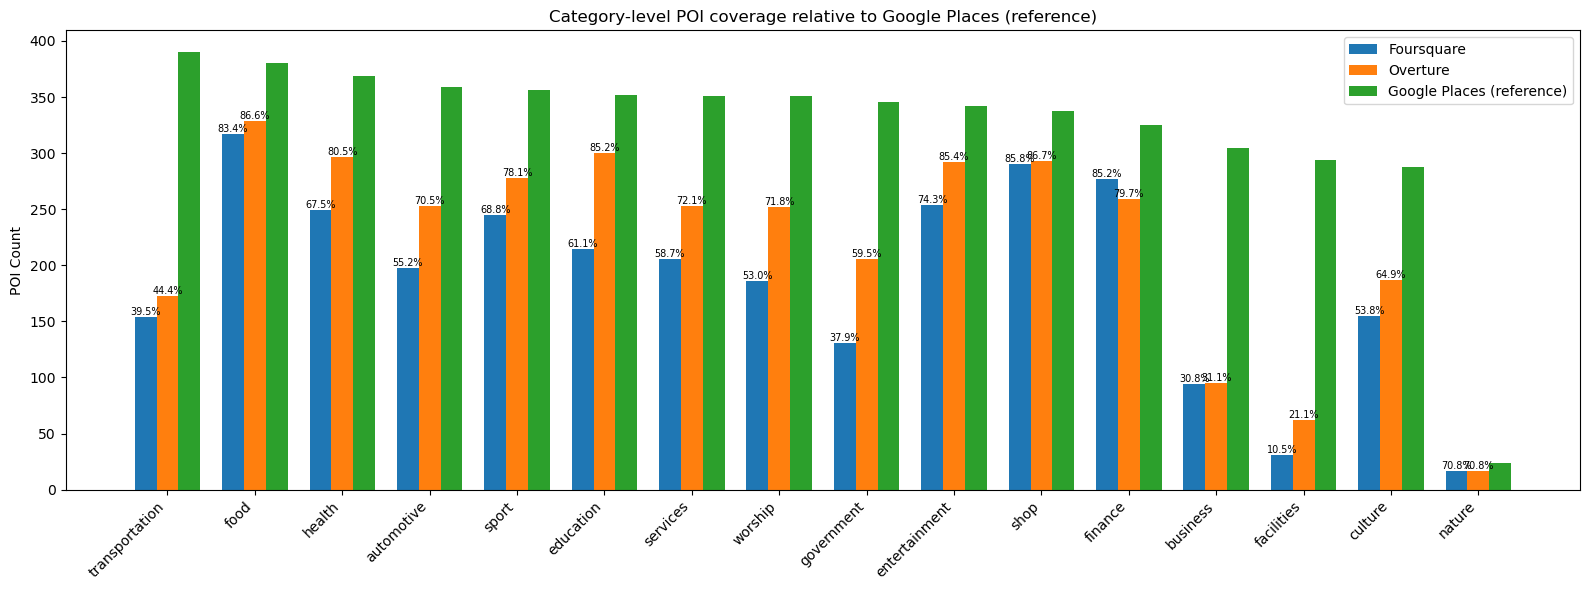

In [318]:
import matplotlib.pyplot as plt

x = np.arange(len(df))
width = 0.25

plt.figure(figsize=(16, 6))

bars_fsq = plt.bar(x - width, df["fsq_count"], width, label="Foursquare")
bars_ove = plt.bar(x, df["ove_count"], width, label="Overture")
bars_g = plt.bar(x + width, df["google_count"], width, label="Google Places (reference)")

plt.xticks(x, df["primary_cat"], rotation=45, ha="right")
plt.ylabel("POI Count")
plt.title("Category-level POI coverage relative to Google Places (reference)")
plt.legend()

# =====================
# 5. 在 fsq / ove 柱子上标注 coverage (%)
# =====================
for i, bar in enumerate(bars_fsq):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{df.loc[i, 'fsq_per']*100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=7
    )

for i, bar in enumerate(bars_ove):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{df.loc[i, 'ove_per']*100:.1f}%",
        ha="center",
        va="bottom",
        fontsize=7
    )

plt.tight_layout()
plt.show()

### Location Accuracy

In [325]:
nyc_gplc_p = nyc_gplc_aggr.to_crs(epsg=3857)
nyc_ove_p  = nyc_ove.to_crs(epsg=3857)
nyc_fsq_p  = nyc_fsq.to_crs(epsg=3857)

ove_geom = nyc_ove_p[['id', 'geometry']].rename(columns={'geometry': 'ove_geometry'})
gplc_ove = nyc_gplc_p.merge(ove_geom, left_on='matched_id_ove',right_on='id',how='left')
gplc_ove['dist_ove_m'] = gplc_ove.geometry.distance(gplc_ove['ove_geometry'])

fsq_geom = nyc_fsq_p[['fsq_place_id', 'geometry']].rename(columns={'geometry': 'fsq_geometry'})
gplc_fsq = nyc_gplc_p.merge(fsq_geom, left_on='matched_id_fsq',right_on='fsq_place_id', how='left')
gplc_fsq['dist_fsq_m'] = gplc_fsq.geometry.distance(gplc_fsq['fsq_geometry'])

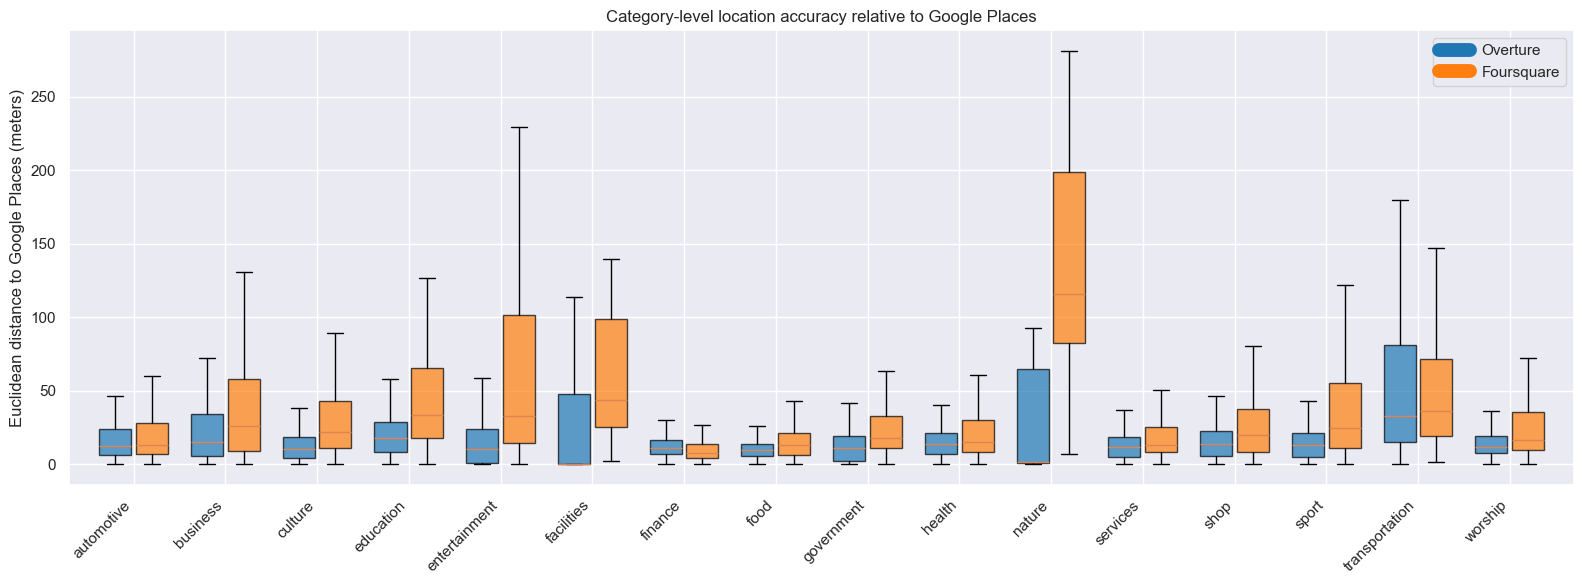

In [336]:
import numpy as np
import matplotlib.pyplot as plt

MAX_DIST = 500  # meters
ove_vis = gplc_ove.query("dist_ove_m <= @MAX_DIST")
fsq_vis = gplc_fsq.query("dist_fsq_m <= @MAX_DIST")

cats = sorted(ove_vis['primary_cat'].unique())

data_ove = [ove_vis.loc[ove_vis.primary_cat == c, 'dist_ove_m'] for c in cats]
data_fsq = [fsq_vis.loc[fsq_vis.primary_cat == c, 'dist_fsq_m'] for c in cats]

plt.figure(figsize=(16, 6))

# ---------- Overture ----------
bp_ove = plt.boxplot(
    data_ove,
    positions=np.arange(len(cats)) - 0.2,
    widths=0.35,
    showfliers=False,
    patch_artist=True
)

for box in bp_ove['boxes']:
    box.set_facecolor('#1f77b4')  # 蓝色
    box.set_alpha(0.7)

# ---------- Foursquare ----------
bp_fsq = plt.boxplot(
    data_fsq,
    positions=np.arange(len(cats)) + 0.2,
    widths=0.35,
    showfliers=False,
    patch_artist=True
)

for box in bp_fsq['boxes']:
    box.set_facecolor('#ff7f0e')  # 橙色
    box.set_alpha(0.7)

plt.xticks(np.arange(len(cats)), cats, rotation=45, ha='right')
plt.ylabel("Euclidean distance to Google Places (meters)")
plt.title("Category-level location accuracy relative to Google Places(reference)")

# ---------- 正确的 legend ----------
plt.legend(
    handles=[
        plt.Line2D([0], [0], color='#1f77b4', lw=10, label='Overture'),
        plt.Line2D([0], [0], color='#ff7f0e', lw=10, label='Foursquare')
    ],
    loc='upper right'
)

plt.tight_layout()
plt.show()


### Sptail Correlation bettween population with location and category bias

In [ ]:
tot_pop_nybg_2023_5yrs = pd.read_csv('/Users/houpuli/Downloads/ACSDT5Y2023.B01003_2026-01-04T203026/ACSDT5Y2023.B01003-Data.csv')
tot_pop_nybg_2023_5yrs = tot_pop_nybg_2023_5yrs.rename(columns={'B01003_001E':'pop'}).drop(columns={'B01003_001M','NAME','Unnamed: 4'})
tot_pop_nybg_2023_5yrs = tot_pop_nybg_2023_5yrs.loc[1:]

ny_gdf = gpd.read_file('/Users/houpuli/Downloads/tl_2023_36_bg.zip')
ny_gdf = ny_gdf[['GEOIDFQ','geometry']].merge(tot_pop_nybg_2023_5yrs, left_on='GEOIDFQ', right_on='GEO_ID', how='left')
ny_gdf = ny_gdf.to_crs(epsg=4326)
pop_2023_5yrs_nyc = ny_gdf.sjoin(nyc_ct_geom, how='inner', predicate='intersects')
pop_2023_5yrs_nyc = pop_2023_5yrs_nyc.drop(columns={'index_right','GEOIDFQ'})

In [367]:
pop_2023_5yrs_nyc

,geometry,GEO_ID,pop
0,"POLYGON ((-73.91570 40.83054, -73.91485 40.830...",1500000US360050175002,718
1,"POLYGON ((-73.91661 40.82499, -73.91592 40.825...",1500000US360050141001,1892
2,"POLYGON ((-73.90584 40.83106, -73.90503 40.832...",1500000US360050145001,1946
3,"POLYGON ((-73.91051 40.81950, -73.91035 40.819...",1500000US360050075002,3359
4,"POLYGON ((-73.86287 40.89515, -73.86146 40.897...",1500000US360050418001,603
...,...,...,...
16064,"POLYGON ((-73.86925 40.86793, -73.86829 40.867...",1500000US360050336012,946
16065,"POLYGON ((-73.86719 40.87060, -73.86716 40.871...",1500000US360050338021,1809
16066,"POLYGON ((-73.86722 40.86969, -73.86649 40.869...",1500000US360050338011,923
16067,"POLYGON ((-73.86732 40.86658, -73.86727 40.867...",1500000US360050338012,1196


## Machine leanring test

prepare training dataset

In [410]:
# ny_gplc
# ny_ove_msa
# ny_fsq_msa

In [538]:
ny_gplc_ove = search_spatial_candidates(ny_gplc,ny_ove_msa,k=20)

In [539]:
ny_gplc_ove = match_by_name(ny_gplc_ove,ny_ove_msa,threshold=80)

In [540]:
ny_gplc_ove = address_score_check(ny_gplc_ove,ny_ove_msa)

In [ ]:
# ny_gplc_ove["location_distance"] = pd.to_numeric(
#     ny_gplc_ove["location_distance"], errors="coerce"
# )

# ny_gplc_ove["address_score"] = pd.to_numeric(
#     ny_gplc_ove["address_score"], errors="coerce"
# )
# ny_gplc_ove['is_true_match'] = True

In [599]:
ny_gplc_ove

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,addr_simple,cand_ids,cand_dist_m,matched_id,name_score,location_distance,matched_name,address_score,matched_address,is_true_match
0,0,ChIJz2WoQWPkwIkRBJ3miPA5ahs,Spirit,"14 S New York Rd, Absecon, NJ 08205, USA",gas_station,39.491219,-74.457829,automotive,POINT (-74.45783 39.49122),14 S New York Rd,"[632360ec-195b-4917-b0c8-66d5e2bf69c2, 98523f6...","[17.929753732590136, 151.06555514188716, 152.1...",632360ec-195b-4917-b0c8-66d5e2bf69c2,100.000000,17.929754,Spirit,100.0,14 S New York Rd,True
1,0,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,"167 S New York Rd, Absecon, NJ 08205, USA",car_repair,39.472252,-74.460912,automotive,POINT (-74.46091 39.47225),167 S New York Rd,"[c1e19193-4a2e-486f-9087-4bac69faae1d, 891910e...","[632.1054608119546, 632.2407330490911, 635.639...",<NA>,41.707317,NaN,<NA>,NaN,<NA>,True
2,0,ChIJybcilkTkwIkREudTyhAsa5Q,Frank Dean Automotive,"145 Old Port Republic Rd, Galloway, NJ 08205, USA",car_repair,39.476918,-74.465489,automotive,POINT (-74.46549 39.47692),145 Old Port Republic Rd,"[e1386ee1-ce61-4cc0-a84a-8378acf213e5, 2b39956...","[2.7532383098075672, 72.7082976804537, 167.186...",e1386ee1-ce61-4cc0-a84a-8378acf213e5,100.000000,2.753238,Frank Dean Automotive,100.0,145 Old Port Republic Rd,True
3,2,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,"5500-5598 S Long Beach Blvd, Long Beach, NJ 08...",parking,39.532222,-74.262475,automotive,POINT (-74.26248 39.53222),5500-5598 S Long Beach Blvd,"[dd5ff343-3d50-4b03-8f83-f4a4eaf3194b, 384c5d6...","[14.012164822653558, 41.55033548765407, 57.599...",caa0127b-cc11-4b31-b33a-abcbee874386,90.000000,122.987078,Wooden Jetty,NaN,<NA>,True
4,2,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,"6805 S Long Beach Blvd, Long Beach, NJ 08008, USA",parking,39.531471,-74.262935,automotive,POINT (-74.26293 39.53147),6805 S Long Beach Blvd,"[caa0127b-cc11-4b31-b33a-abcbee874386, f74b1bf...","[13.063859874424766, 24.308057503283795, 120.2...",81a5f23e-3622-4fa6-9a57-ec6477b7796f,85.500000,312.705359,Edwin B. Forsythe National Wildlife Refuge,39.0,11 Lincoln Ave,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64591,452,ChIJexEE0P823YkR-27f_ozfLw0,Route 9 N & Schuyler Blvd Hotels,"Fishkill, NY 12524, USA",bus_stop,41.526371,-73.891182,transportation,POINT (-73.89118 41.52637),Fishkill,"[f5b53f7f-2490-4e03-9f7d-e4e6cffd1756, b3c73bd...","[55.53784520943986, 68.14525593648864, 111.044...",b2bd0d7c-ad90-409a-90f4-e5309d118f60,85.500000,383.605235,Swim & Play Fishkill,0.0,544 Route 9,True
64592,454,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,"Unnamed Road, Holmes, NY 12531, USA",park_and_ride,41.507060,-73.679592,transportation,POINT (-73.67959 41.50706),Unnamed Road,"[c15ad8be-d80a-48d0-aeb1-e188aea8f5f1, 281a3c5...","[167.13038029869975, 205.47078370162959, 237.9...",281a3c55-9da3-4976-ab7e-55a4eaeb3c29,85.500000,205.470784,Pine Bush Equipment Co Inc. and PBE NAPA Auto ...,8.0,24 Sybil Ct,True
64593,455,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,"Patterson, NY 12563, USA",train_station,41.511741,-73.604266,transportation,POINT (-73.60427 41.51174),Patterson,"[5c95b5fa-59a3-455b-bce9-a3fef615fb87, 5976fdf...","[39.29237323263206, 89.52690053130242, 90.4862...",5c95b5fa-59a3-455b-bce9-a3fef615fb87,90.000000,39.292373,MTA Metro-North Railroad-Patterson,30.0,25 Front St,True
64594,455,ChIJP6Yh70tQ3YkROQ_4xOEmIRY,Park & Ride,"NY-311, Patterson, NY 12563, USA",park_and_ride,41.474254,-73.643322,transportation,POINT (-73.64332 41.47425),NY-311,"[652fd95b-e511-475b-91a5-3962ae9f9fb8, 58c1087...","[707.3880279362838, 829.8435646997425, 1011.74...",a5ec3fa6-c83a-4438-8a01-70535db9df53,85.500000,1034.280831,Kent Countryside Nursery & Landscaping,22.0,61 Ludington Ct,True


<Axes: >

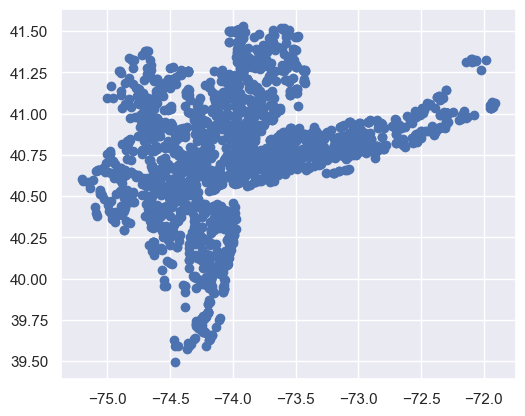

In [545]:
sampled = ny_gplc_ove[ny_gplc_ove["matched_id"].notna()].sample(
    n=2000,
    random_state=42
)
sampled.plot()

In [546]:
sampled[['id','name','address','addr_simple','name_score','location_distance','address_score','matched_address','matched_name','is_true_match']].to_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ml_set.csv', index=False)

In [ ]:
ceshi = sampled['primary_cat'].value_counts()

primary_cat
food              199
entertainment     191
services          185
government        169
health            162
shop              159
automotive        144
sport             144
finance           132
education         127
worship           125
culture            88
business           83
transportation     75
facilities          9
nature              8
Name: count, dtype: int64

In [560]:
sampled_data = sampled['primary_cat'].value_counts()
sampled_data = pd.DataFrame(sampled_data)
sampled_data = sampled_data.rename(columns={'count':'sample_count'})
sampled_data['per'] = sampled_data['sample_count'] / len(sampled)

ny_gplc_ove_data = ny_gplc_ove['primary_cat'].value_counts()
ny_gplc_ove_data = pd.DataFrame(ny_gplc_ove_data)
ny_gplc_ove_data = ny_gplc_ove_data.rename(columns={'count':'msa_count'})
ny_gplc_ove_data['per'] = ny_gplc_ove_data['msa_count'] / len(ny_gplc_ove)


In [561]:
sampled_data

,sample_count,per
primary_cat,,
food,199,0.0995
entertainment,191,0.0955
services,185,0.0925
government,169,0.0845
health,162,0.0810
shop,159,0.0795
automotive,144,0.0720
sport,144,0.0720
finance,132,0.0660


In [562]:
ny_gplc_ove_data

,msa_count,per
primary_cat,,
services,5594,0.086600
entertainment,5588,0.086507
health,5287,0.081847
food,5098,0.078921
shop,4970,0.076940
automotive,4864,0.075299
government,4664,0.072203
sport,4579,0.070887
finance,4225,0.065407


In [589]:
sample_check = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ml_set_up.csv')
sample_check['is_true_match'] = sample_check['is_true_match'].fillna(False)
sampled_finished = sampled.drop(columns=['is_true_match','cand_ids','cand_dist_m'], errors='ignore').merge(sample_check[['id','is_true_match']], on = 'id', how='left')

In [327]:
sampled_finished = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_ove_2000_sample_c.geojson')

In [328]:
sampled_finished[['name_score','location_distance','address_score','is_true_match']].describe()

,name_score,location_distance,address_score
count,2000.000000,2000.000000,1928.000000
mean,95.710869,83.887069,86.725622
std,5.856569,283.433687,23.195541
min,80.000000,0.000000,0.000000
25%,90.000000,6.816054,85.000000
50%,100.000000,15.722139,100.000000
75%,100.000000,35.036833,100.000000
max,100.000000,5312.975430,100.000000


### Data engenering

In [329]:
df = sampled_finished[sampled_finished['location_distance'] <= 500].copy()

In [330]:
df['address_score'] = df['address_score'].fillna(0)

In [331]:
from sklearn.preprocessing import StandardScaler

X = df[['name_score', 'location_distance', 'address_score']]
y = df['is_true_match']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [332]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y  # keep the same proportion of True vs False in training set and test set
)

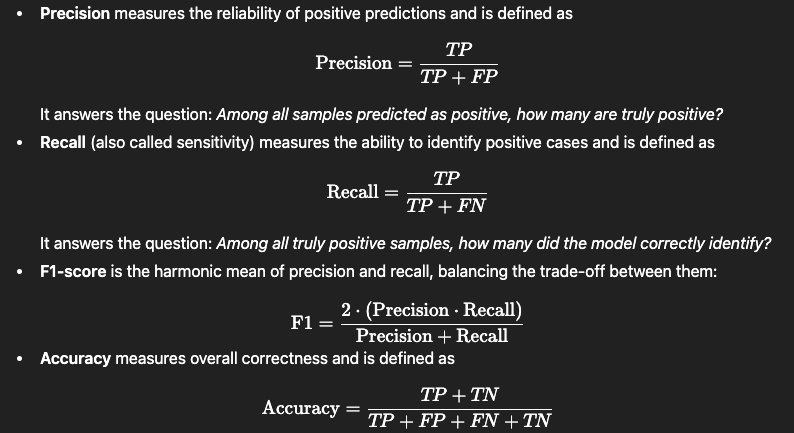
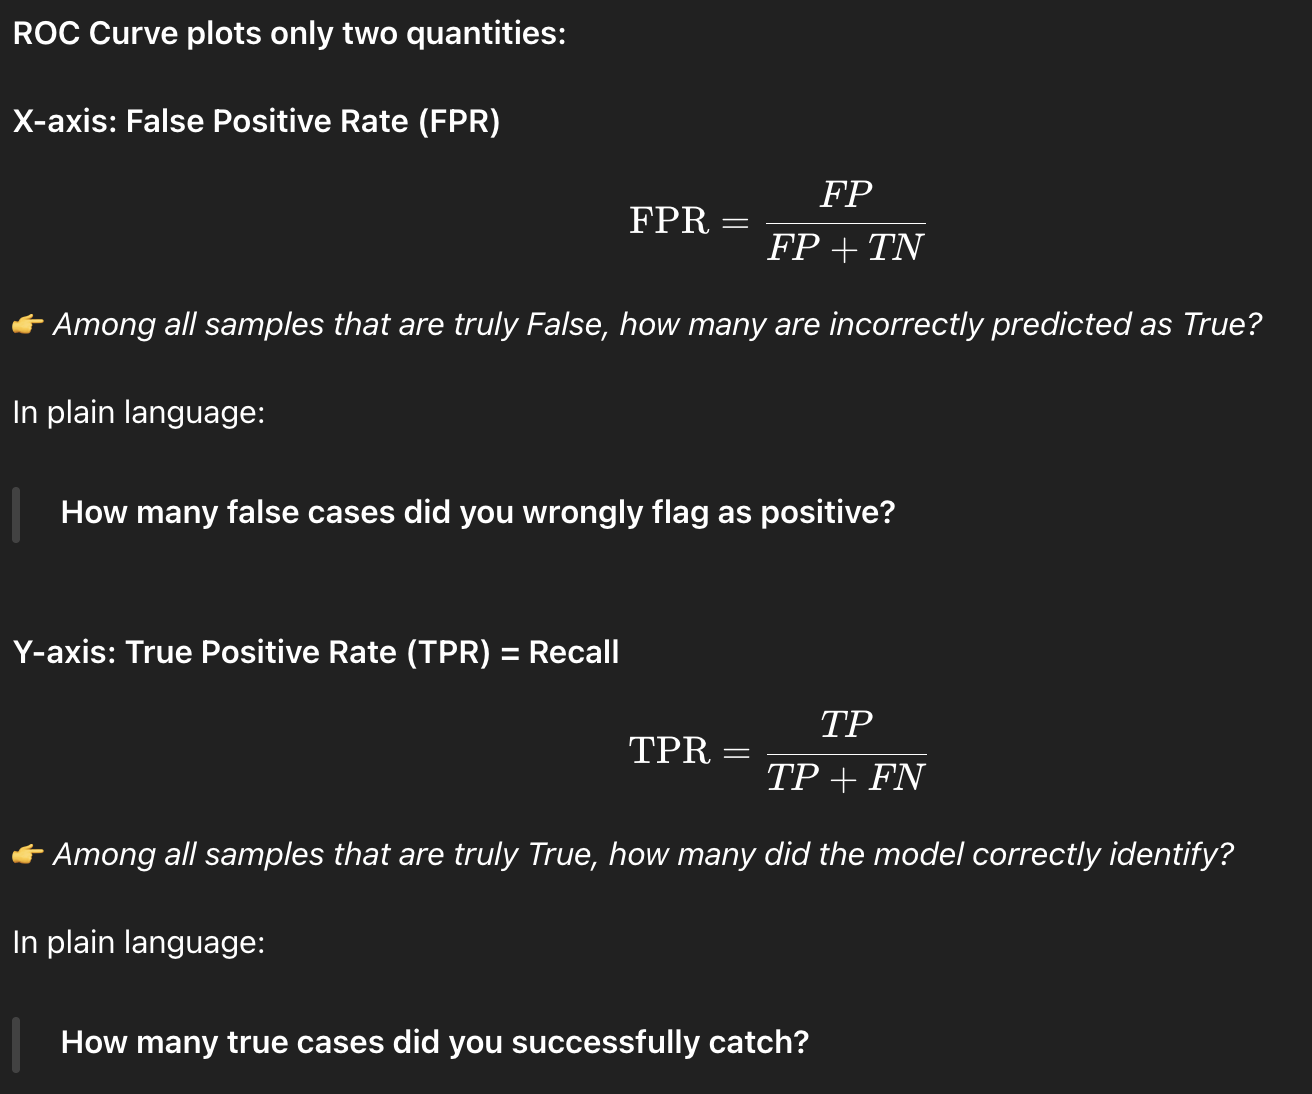

### Classfication method

#### LogisticRegression

In [637]:
from sklearn.linear_model import LogisticRegression

lg_clf = LogisticRegression()
lg_clf.fit(X_train, y_train)

LogisticRegression()

In [638]:
from sklearn.metrics import classification_report, roc_auc_score

lg_y_pred = lg_clf.predict(X_test)
lg_y_prob = lg_clf.predict_proba(X_test)[:, 1]

lg_cr = classification_report(y_test, lg_y_pred)
lg_auc = roc_auc_score(y_test, lg_y_prob)

print(lg_cr)
print("Logistic regression of AUC:", lg_auc)

              precision    recall  f1-score   support

       False       0.90      0.71      0.80        63
        True       0.96      0.99      0.97       415

    accuracy                           0.95       478
   macro avg       0.93      0.85      0.88       478
weighted avg       0.95      0.95      0.95       478

Logistic regression of AUC: 0.9891375023905145


#### RandomForestClassifier

In [640]:
from sklearn.ensemble import RandomForestClassifier

rforest_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rforest_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [641]:
from sklearn.metrics import classification_report, roc_auc_score

rforest_y_pred = rforest_clf.predict(X_test)
rforest_y_prob = rforest_clf.predict_proba(X_test)[:, 1]

rforest_cr = classification_report(y_test, rforest_y_pred)
rforest_auc = roc_auc_score(y_test, rforest_y_prob)

print(rforest_cr)
print("Radomforest of AUC:", rforest_auc)

              precision    recall  f1-score   support

       False       0.82      0.78      0.80        63
        True       0.97      0.97      0.97       415

    accuracy                           0.95       478
   macro avg       0.89      0.88      0.88       478
weighted avg       0.95      0.95      0.95       478

Radomforest of AUC: 0.9570472365653089


#### GradientBoostingClassifier

In [644]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)


GradientBoostingClassifier()

In [645]:
from sklearn.metrics import classification_report, roc_auc_score

gb_y_pred = gb_clf.predict(X_test)
gb_y_prob = gb_clf.predict_proba(X_test)[:, 1]

gb_cr = classification_report(y_test, gb_y_pred)
gb_auc = roc_auc_score(y_test, gb_y_prob)

print(gb_cr)
print("GradientBoosting of AUC:", gb_auc)

              precision    recall  f1-score   support

       False       0.91      0.81      0.86        63
        True       0.97      0.99      0.98       415

    accuracy                           0.96       478
   macro avg       0.94      0.90      0.92       478
weighted avg       0.96      0.96      0.96       478

GradientBoosting of AUC: 0.9896156052782559


#### SVM

In [646]:
from sklearn.svm import SVC

svm_clf = SVC(probability=True)
svm_clf.fit(X_train, y_train)

SVC(probability=True)

In [647]:
from sklearn.metrics import classification_report, roc_auc_score

svm_y_pred = svm_clf.predict(X_test)
svm_y_prob = svm_clf.predict_proba(X_test)[:, 1]

svm_cr = classification_report(y_test, svm_y_pred)
svm_auc = roc_auc_score(y_test, svm_y_prob)

print(svm_cr)
print("Support Vector Machine of AUC:", svm_auc)

              precision    recall  f1-score   support

       False       0.91      0.76      0.83        63
        True       0.96      0.99      0.98       415

    accuracy                           0.96       478
   macro avg       0.94      0.87      0.90       478
weighted avg       0.96      0.96      0.96       478

Support Vector Machine of AUC: 0.9682539682539683


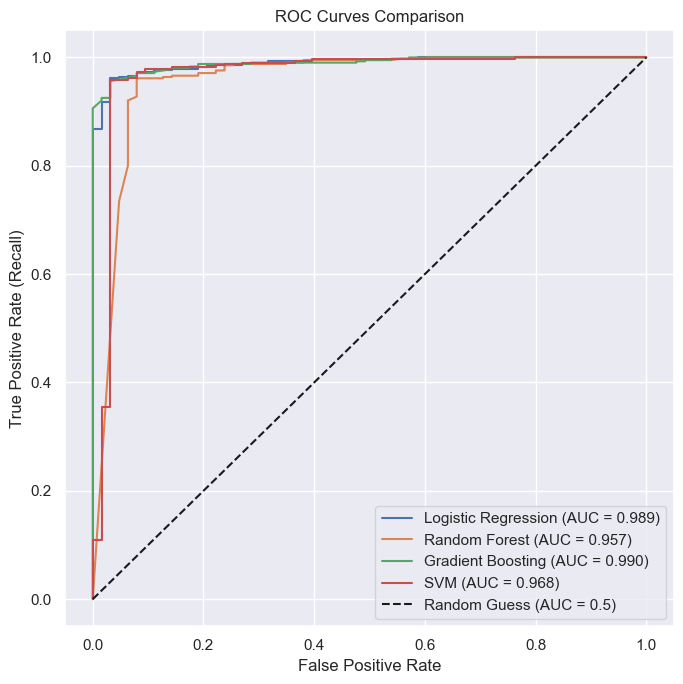

In [648]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(7, 7))

# Logistic Regression
fpr_lg, tpr_lg, _ = roc_curve(y_test, lg_y_prob)
plt.plot(fpr_lg, tpr_lg, label=f"Logistic Regression (AUC = {lg_auc:.3f})")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rforest_y_prob)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rforest_auc:.3f})")

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_y_prob)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {gb_auc:.3f})")

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_y_prob)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {svm_auc:.3f})")

# Random guess baseline
plt.plot([0, 1], [0, 1], "k--", label="Random Guess (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Clustering Method

In [649]:
X_train_true = X_train[y_train == True]

In [650]:
from sklearn.ensemble import IsolationForest

iso_clf = IsolationForest(
    contamination="auto",
    random_state=42
)

iso_clf.fit(X_train_true)

IsolationForest(random_state=42)

In [651]:
iso_score = iso_clf.decision_function(X_test)

iso_y_pred = iso_clf.predict(X_test)
iso_y_pred = (iso_y_pred == 1)  # transfer 1,-1 into True / False

iso_cr = classification_report(y_test, iso_y_pred)
iso_auc = roc_auc_score(y_test, iso_score)

print(iso_cr)
print("Isolation Forest AUC:", iso_auc)

              precision    recall  f1-score   support

       False       0.50      0.94      0.65        63
        True       0.99      0.86      0.92       415

    accuracy                           0.87       478
   macro avg       0.74      0.90      0.78       478
weighted avg       0.92      0.87      0.88       478

Isolation Forest AUC: 0.9646586345381527


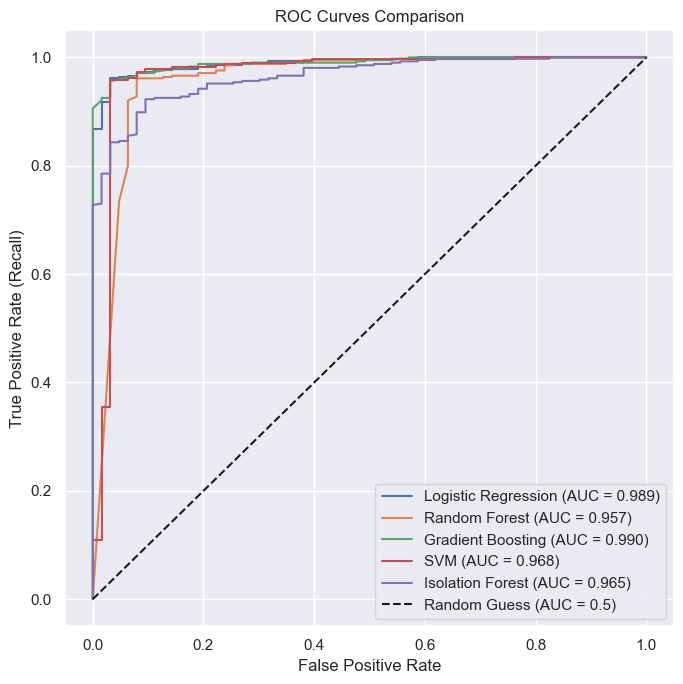

In [652]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(7, 7))

# Logistic Regression
fpr_lg, tpr_lg, _ = roc_curve(y_test, lg_y_prob)
plt.plot(fpr_lg, tpr_lg, label=f"Logistic Regression (AUC = {lg_auc:.3f})")

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rforest_y_prob)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rforest_auc:.3f})")

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_y_prob)
plt.plot(fpr_gb, tpr_gb, label=f"Gradient Boosting (AUC = {gb_auc:.3f})")

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_y_prob)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {svm_auc:.3f})")

# Iso Forest
fpr_iso, tpr_iso, _ = roc_curve(y_test, iso_score)
plt.plot(fpr_iso, tpr_iso, label=f"Isolation Forest (AUC = {iso_auc:.3f})")

# Random guess baseline
plt.plot([0, 1], [0, 1], "k--", label="Random Guess (AUC = 0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Google VS Overture

In [206]:
import os
import json
import base64
import numpy as np
import pandas as pd
import geopandas as gpd
from typing import Optional
from pyiceberg.expressions import And, GreaterThanOrEqual, LessThanOrEqual
from pyiceberg.catalog import load_catalog

In [205]:
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree

def search_spatial_candidates(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    k: int = 100,
    max_dist: float = 1000, 
    id_col: str = "id",
    crs_for_distance: int = 3857,
):
    """
    Attach k nearest compared POI ids & distances to reference_gdf.

    Returns
    -------
    GeoDataFrame with two new columns:
    - cand_ids   : list of compared ids
    - cand_dist_m: list of distances (meters)
    """

    ref_proj = reference_gdf.to_crs(crs_for_distance)
    cmp_proj = compared_gdf.to_crs(crs_for_distance)

    ref_xy = np.column_stack([ref_proj.geometry.x, ref_proj.geometry.y])
    cmp_xy = np.column_stack([cmp_proj.geometry.x, cmp_proj.geometry.y])

    tree = cKDTree(cmp_xy)
    k_eff = min(k, len(compared_gdf))

    dist, idx = tree.query(ref_xy, k=k_eff)

    if k_eff == 1:
        dist = dist.reshape(-1, 1)
        idx = idx.reshape(-1, 1)

    cmp_ids = compared_gdf[id_col].to_numpy()

    cand_ids = []
    cand_dists = []

    for row_idx, row_dist in zip(idx, dist):
        ids = []
        dists = []

        for j, d in zip(row_idx, row_dist):
            if d <= max_dist:
                ids.append(cmp_ids[j])
                dists.append(d)

        cand_ids.append(ids)
        cand_dists.append(dists)

    result = reference_gdf.copy()
    result["cand_ids"] = cand_ids
    result["cand_dist_m"] = cand_dists

    return result

In [207]:
FOOD_WORDS = {
    "RESTAURANT","RESTURANT","RESTARAUNT",
    "CAFE","CAFÉ","COFFEE","BAR","BISTRO","GRILL",
    "KITCHEN","DINER","EATERY","STEAKHOUSE",
    "SEAFOOD","BUFFET","BBQ","PIZZA","SUSHI","RAMEN",
    "NOODLE","NOODLES","BURGER","BURGERS","TACO","TACOS",
    "CHICKEN","WINGS","BAKERY","DELI","DELICATESSEN",
    "COURT","FOOD","EXPRESS","HOUSE","SHOP"
}

PLACE_WORDS = {
    "HALL","CENTER","CENTRE","PLAZA","MARKET","MALL",
    "GARDEN","GARDENS","PARK","SQUARE","TOWER","TOWERS",
    "STATION","TERMINAL","BUILDING","GALLERY","THEATER","SCHOOL","COURT","INN",
    "HOTEL","MOTEL","INN","SUITES","SUITE",
    "SPA","SALON","STUDIO","CENTER","CENTRE",
    "CLUB","LOUNGE","STATION","STOP"
}

LEGAL_WORDS = {
    "LLC","INC","CORP","CORPORATION","CO","COMPANY",
    "LTD","LIMITED","GROUP","HOLDINGS","OFFICE"
}

GRAMMAR = {
    "THE","OF","AT","AND","FOR","IN","ON","BY","WITH","TO","FROM"
}

NON_PRIMARY_TOKENS = FOOD_WORDS | PLACE_WORDS | LEGAL_WORDS | GRAMMAR

In [208]:
from rapidfuzz import process, fuzz
import pandas as pd
import re
import unicodedata


def clean_name(s):
    if not isinstance(s, str):
        return ""

    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c)) # 1. unicode normalize (remove accents)
    s = s.upper() # 2. uppercase
    s = re.sub(r"\([^)]*\)", "", s) 
    s = re.sub(r"\b'S\b", "", s) # new change
    s = re.sub(r"\bS\b", "", s) # new change
    s = s.encode("ascii", errors="ignore").decode() # 4. remove emoji / non ascii
    s = re.sub(r"[^\w\s]", " ", s) # 5. replace special chars with space
    s = re.sub(r"\s+", " ", s) # 6. collapse spaces

    return s.strip()

def extract_prinmary_str(name):

    tokens = name.split()
    core = [t for t in tokens if t not in NON_PRIMARY_TOKENS]
    if len(core) == 1 and len(core[0]) < 3:
        return name
    if core:
        return " ".join(core)
    return name

def match_by_name(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    re_name_col: str = "name",
    comp_name_col: str = "name",
    comp_id: str = "id",
    comp_id_col: str="cat_main",
    threshold: int = 80,
):
    """
    Perform WRatio name matching within spatial candidates.

    Returns
    -------
    GeoDataFrame with:
    - matched_id_name
    - name_score
    """

    # clean names for matching
    id_to_name_clean = compared_gdf.set_index(comp_id)[comp_name_col].apply(clean_name).apply(extract_prinmary_str).to_dict()
    # raw names for storage
    id_to_name_raw = compared_gdf.set_index(comp_id)[comp_name_col].to_dict()
    # raw compared df category
    id_to_cat = compared_gdf.set_index(comp_id)[comp_id_col].to_dict()

    matched_ids = []
    scores = []
    loc_dists = []
    matched_names = []
    matched_cats = []

    for _, row in reference_gdf.iterrows():
        query = extract_prinmary_str(clean_name(row.get(re_name_col)))

        if not isinstance(query, str) or not row["cand_ids"]:
            matched_ids.append(pd.NA)
            scores.append(pd.NA)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)
            matched_cats.append(pd.NA)
            continue

        cand_names = [id_to_name_clean.get(cid, "") for cid in row["cand_ids"]]

        top_matches = process.extract(
            query,
            cand_names,
            scorer=fuzz.WRatio,
            limit=5
        )

        best_score = -1
        best_pos = None

        for name, wr, pos in top_matches:

            pr = fuzz.partial_ratio(query, name)
            ts = fuzz.token_sort_ratio(query, name)
            tset = fuzz.token_set_ratio(query, name)

            combined = max(wr, pr, ts, tset)

            if combined > best_score:
                best_score = combined
                best_pos = pos

        score = best_score

        if score >= threshold:
            matched_ids.append(row["cand_ids"][best_pos])
            scores.append(score)
            loc_dists.append(row["cand_dist_m"][best_pos])
            matched_names.append(id_to_name_raw.get(row["cand_ids"][best_pos]))
            matched_cats.append(id_to_cat.get(row["cand_ids"][best_pos]))
        else:
            matched_ids.append(pd.NA)
            scores.append(score)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)
            matched_cats.append(pd.NA)


    result = reference_gdf.copy()
    result["matched_id"] = matched_ids
    result["name_score"] = scores
    result["location_distance"] = loc_dists
    result["matched_name"] = matched_names
    result["matched_cat_main"] = matched_cats

    return result

In [209]:
import pandas as pd
import geopandas as gpd
from rapidfuzz import fuzz
import re
import unicodedata

def clean_name(s):
    if not isinstance(s, str):
        return ""

    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c)) # 1. unicode normalize (remove accents)
    s = s.upper() # 2. uppercase
    s = re.sub(r"\([^)]*\)", "", s) 
    s = s.encode("ascii", errors="ignore").decode() # 4. remove emoji / non ascii
    s = re.sub(r"[^\w\s]", " ", s) # 5. replace special chars with space
    s = re.sub(r"\s+", " ", s) # 6. collapse spaces

    return s.strip()

def address_score_check(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    addr_col_ref: str = "addr_simple",
    addr_col_cmp: str = "address",
    matched_id_col: str = "matched_id",
    id_col: str = "id",
    out_col: str = "address_score",
    out_addr_col: str = "matched_address", 
):
    """
    Compute address similarity score (0-100) for already-matched rows.

    Only rows with non-null `matched_id_col` will be scored.
    Others will have NaN.

    Returns
    -------
    GeoDataFrame with a new column `out_col`.
    """

    # map: compared id -> compared address
    id_to_addr_clean = compared_gdf.set_index(id_col)[addr_col_cmp].apply(clean_name).to_dict()
    id_to_addr_raw = compared_gdf.set_index(id_col)[addr_col_cmp].to_dict()

    scores = []
    matched_addrs = []

    for _, row in reference_gdf.iterrows():
        matched_id = row.get(matched_id_col)

        # no matched id -> no score
        if pd.isna(matched_id):
            scores.append(pd.NA)
            matched_addrs.append(pd.NA)
            continue

        addr_ref = clean_name(row.get(addr_col_ref))
        addr_cmp = id_to_addr_clean.get(matched_id)

        if isinstance(addr_cmp, str) and addr_cmp.strip():
            matched_addrs.append(id_to_addr_raw.get(matched_id))
        else:
            matched_addrs.append(pd.NA)

        # missing address on either side -> no score
        if not isinstance(addr_ref, str) or not addr_ref.strip():
            scores.append(pd.NA)
            continue
        if not isinstance(addr_cmp, str) or not addr_cmp.strip():
            scores.append(pd.NA)
            continue

        wr = fuzz.WRatio(addr_ref, addr_cmp)
        pr = fuzz.partial_ratio(addr_ref, addr_cmp)
        ts = fuzz.token_sort_ratio(addr_ref, addr_cmp)
        tset = fuzz.token_set_ratio(addr_ref, addr_cmp)

        scores.append(int(max(wr, pr, ts, tset)))

    result = reference_gdf.copy()
    result[out_col] = scores
    result[out_addr_col] = matched_addrs
    return result

In [210]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

def calculate_similarity_check(
    df, 
    cat_col_ref: str = "primary_type", 
    cat_col_cmp: str = "matched_cat_main", 
    id_col: str = "matched_id", 
    result_col: str =  "category_sim",
):

    # 1. Setup Device
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
    
    # 2. Primary Gatekeeper: matched_id must be present
    mask = df[id_col].notna() & (df[id_col].astype(str).str.strip() != "")
    
    # 3. Create a helper to handle potential Nulls in text columns
    temp_df = df[mask].copy()
    
    # Identify where text is actually missing within the masked rows
    text_missing_mask = temp_df[cat_col_ref].isna() | temp_df[cat_col_cmp].isna()
    
    # Fill NaNs with empty strings just for the encoding step
    texts_1 = temp_df[cat_col_ref].fillna("").astype(str).tolist()
    texts_2 = temp_df[cat_col_cmp].fillna("").astype(str).tolist()

    print(f"Encoding {len(temp_df)} rows...")

    # 4. Batch Encoding
    emb1 = model.encode(texts_1, batch_size=256, show_progress_bar=True, convert_to_tensor=True)
    emb2 = model.encode(texts_2, batch_size=256, show_progress_bar=True, convert_to_tensor=True)

    # 5. Calculate Similarity
    scores = torch.nn.functional.cosine_similarity(emb1, emb2, dim=1).cpu().numpy()
    
    # 6. Apply NaN to rows where text was missing
    # Even if we encoded an empty string, the result isn't "real" if data was missing
    scores[text_missing_mask.values] = np.nan

    # 7. Map back to original dataframe
    df[result_col] = np.nan
    df.loc[mask, result_col] = scores
    
    return df

In [26]:
ny_gplc = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/google_placescat_5000_clean.geojson')
google_naics_mapping = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/mapping_google_naics.csv')
ny_gplc = ny_gplc.merge(google_naics_mapping[['SubCategory','naics_code','naics_definition']], left_on = 'primary_type', right_on='SubCategory', how="left")
ny_gplc['addr_simple'] = ny_gplc['address'].str.split(',', n=1).str[0]
ny_gplc = ny_gplc.drop(columns=['SubCategory'])
ny_gplc

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,naics_code,naics_definition,addr_simple
0,0,ChIJz2WoQWPkwIkRBJ3miPA5ahs,Spirit,"14 S New York Rd, Absecon, NJ 08205, USA",gas_station,39.491219,-74.457829,automotive,POINT (-74.45783 39.49122),44.0,Retail Trade,14 S New York Rd
1,0,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,"167 S New York Rd, Absecon, NJ 08205, USA",car_repair,39.472252,-74.460912,automotive,POINT (-74.46091 39.47225),81.0,Other Services (except Public Administration),167 S New York Rd
2,0,ChIJybcilkTkwIkREudTyhAsa5Q,Frank Dean Automotive,"145 Old Port Republic Rd, Galloway, NJ 08205, USA",car_repair,39.476918,-74.465489,automotive,POINT (-74.46549 39.47692),81.0,Other Services (except Public Administration),145 Old Port Republic Rd
3,2,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,"5500-5598 S Long Beach Blvd, Long Beach, NJ 08...",parking,39.532222,-74.262475,automotive,POINT (-74.26248 39.53222),81.0,Other Services (except Public Administration),5500-5598 S Long Beach Blvd
4,2,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,"6805 S Long Beach Blvd, Long Beach, NJ 08008, USA",parking,39.531471,-74.262935,automotive,POINT (-74.26293 39.53147),81.0,Other Services (except Public Administration),6805 S Long Beach Blvd
...,...,...,...,...,...,...,...,...,...,...,...,...
65675,452,ChIJexEE0P823YkR-27f_ozfLw0,Route 9 N & Schuyler Blvd Hotels,"Fishkill, NY 12524, USA",bus_stop,41.526371,-73.891182,transportation,POINT (-73.89118 41.52637),48.0,Transportation and Warehousing,Fishkill
65676,454,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,"Unnamed Road, Holmes, NY 12531, USA",park_and_ride,41.507060,-73.679592,transportation,POINT (-73.67959 41.50706),48.0,Transportation and Warehousing,Unnamed Road
65677,455,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,"Patterson, NY 12563, USA",train_station,41.511741,-73.604266,transportation,POINT (-73.60427 41.51174),48.0,Transportation and Warehousing,Patterson
65678,455,ChIJP6Yh70tQ3YkROQ_4xOEmIRY,Park & Ride,"NY-311, Patterson, NY 12563, USA",park_and_ride,41.474254,-73.643322,transportation,POINT (-73.64332 41.47425),48.0,Transportation and Warehousing,NY-311


In [157]:
import json
import pandas as pd

def safe_json_load(x):
    try:
        return json.loads(x) if isinstance(x, str) else x
    except:
        return None

def extract_categories(x):
    data = safe_json_load(x)
    if isinstance(data, dict):
        primary = data.get('primary')
        alternate_list = data.get('alternate', [])
        alternate_str = ", ".join(alternate_list) if alternate_list else None
        return primary, alternate_str
    return None, None

def extract_name(x):
    data = safe_json_load(x)
    if isinstance(data, dict):
        return data.get('primary')
    return None

def extract_address(x):
    data = safe_json_load(x)
    if isinstance(data, list) and len(data) > 0:
        return data[0].get('freeform')
    return None

def extract_sources(x):
    data = safe_json_load(x)
    if isinstance(data, list) and len(data) > 0:
        first = data[0] 
        return first.get('dataset'), first.get('record_id'), first.get('update_time')
    return None, None, None


ny_ove = pd.read_csv('/Users/houpuli/Downloads/ove_raw.csv')

ny_ove[['cat_main', 'cat_alt']] = ny_ove['categories'].apply(
    lambda x: pd.Series(extract_categories(x))
)

ny_ove['name'] = ny_ove['names'].apply(extract_name)
ny_ove['address'] = ny_ove['addresses'].apply(extract_address)
ny_ove[['src_dataset', 'src_record_id', 'src_update_time']] = ny_ove['sources'].apply(lambda x: pd.Series(extract_sources(x)))


ny_ove['WKB'] = ny_ove['geometry'].apply(lambda x: x[2:])
geometry = gpd.GeoSeries.from_wkb(ny_ove['WKB'], crs=4326)

ny_ove = gpd.GeoDataFrame(ny_ove, geometry=geometry)
ny_ove = ny_ove[['id','name','address','cat_main','cat_alt','confidence','operating_status','version','src_dataset','src_update_time','geometry']]
ny_ove

,id,name,address,cat_main,cat_alt,confidence,operating_status,version,src_dataset,src_update_time,geometry
0,618b4e7f-f0a8-4a6d-99f3-f5f4275e34a0,Psychic Boutique,53 E Main St,psychic,"naturopathic_holistic, religious_organization",0.950063,open,5,meta,2025-12-01T08:00:00.000Z,POINT (-74.14052 41.05746)
1,de785cb9-7bec-4e36-8e85-8fbcf1fecc10,Allstate Personal Financial Representative: Na...,55 E Main St,insurance_agency,financial_service,0.950063,open,5,meta,2025-12-01T08:00:00.000Z,POINT (-74.14047 41.05749)
2,7e8d11cc-2949-4df3-b996-31f58e7cf608,Andrea DeBenedetto: Allstate Insurance,55 E Main St,insurance_agency,financial_advising,0.988514,open,5,meta,2025-12-01T08:00:00.000Z,POINT (-74.14044 41.05752)
3,d1c244fa-46ab-4456-93f5-49eb951c3bca,Bici,61 E Main St,italian_restaurant,"restaurant, diner",0.997577,open,5,meta,2025-12-01T08:00:00.000Z,POINT (-74.14033 41.05750)
4,e6ecc884-ae27-4957-bf41-833d099d8a23,Apolo Jewelers,63 E Main St,jewelry_store,None,0.988514,open,4,meta,2025-12-01T08:00:00.000Z,POINT (-74.14025 41.05747)
...,...,...,...,...,...,...,...,...,...,...,...
1083610,a0fb5bfe-880d-47d3-924f-441b1cfd8ef7,Brian Mc Kenna Plumbing & Heating,2041 River Rd,hvac_services,plumbing,0.770000,open,4,Microsoft,2013-01-28T23:20:45.670Z,POINT (-75.19196 40.75356)
1083611,6cfec3d3-bd0f-4fe1-bce6-e68b331ff293,Laspada Audio,68 Harmony Sta,electronics,audio_visual_equipment_store,0.323479,open,4,meta,2025-12-01T08:00:00.000Z,POINT (-75.19547 40.75091)
1083612,c075082e-7300-4f4c-b19b-8f8de5f7ad74,Lehigh Valley Site Contractors,5143 Lower Mud Run Rd,contractor,"paving_contractor, excavation_service",0.950063,open,4,meta,2025-12-01T08:00:00.000Z,POINT (-75.19385 40.76376)
1083613,1c2e9784-9c03-45be-96bf-d64f1c8002f0,Easton Block & Supply,5135 Lower Mud Run Rd,building_supply_store,construction_services,0.950063,open,5,meta,2025-12-01T08:00:00.000Z,POINT (-75.19464 40.76469)


In [261]:
ny_gplc_ove = search_spatial_candidates(reference_gdf=ny_gplc, compared_gdf=ny_ove, k=100)

In [262]:
ny_gplc_ove = match_by_name(reference_gdf=ny_gplc_ove, compared_gdf=ny_ove, re_name_col = "name", comp_name_col = "name", threshold=80)

In [263]:
ny_gplc_ove = address_score_check(reference_gdf=ny_gplc_ove, compared_gdf=ny_ove)

In [264]:
ny_gplc_ove = calculate_similarity_check(ny_gplc_ove, cat_col_ref = "primary_type", cat_col_cmp = "matched_cat_main", id_col = "matched_id", result_col =  "category_sim")

Encoding 53638 rows...


Batches:   0%|          | 0/210 [00:00<?, ?it/s]

Batches:   0%|          | 0/210 [00:00<?, ?it/s]

In [ ]:
# transfer the X and Y into float type and deal with the address score
cols_to_fix = ['name_score', 'location_distance', 'address_score', 'category_sim']
for col in cols_to_fix:
    ny_gplc_ove[col] = pd.to_numeric(ny_gplc_ove[col], errors='coerce')
ny_gplc_ove['address_score'] = ny_gplc_ove['address_score'].fillna(0)

In [170]:
df = ny_gplc_ove[ny_gplc_ove["matched_id"].notna()].copy()

N = 2000

weights = df["primary_cat"].map(
    df["primary_cat"].value_counts(normalize=True)
)

df_sample = df.sample(
    n=N,
    weights=weights,
    random_state=42
)
# df_sample[['id','name','addr_simple','naics_definition','matched_id','matched_name','matched_address','matched_cat_main','location_distance']].to_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_ove_2000_sample.csv', index=False)

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,naics_code,...,addr_simple,cand_ids,cand_dist_m,matched_id,name_score,location_distance,matched_name,matched_cat_main,address_score,matched_address
28202,176,ChIJfcmFQFt7wokRpSwaeU6rPB0,Wild Ginger,"424 Sunrise Hwy, Rockville Centre, NY 11570, USA",chinese_restaurant,40.657149,-73.637455,food,POINT (-73.63746 40.65715),72.0,...,424 Sunrise Hwy,"[7dc25087-2d59-4900-97e8-86a42452577d, 92b69b0...","[13.168819958857478, 49.404626548849244, 52.72...",7dc25087-2d59-4900-97e8-86a42452577d,100.0,13.16882,Wild Ginger,asian_restaurant,100,424 Sunrise Hwy
60484,277,ChIJj2eeYpwJw4kRQuRn6L_LcpY,The Body Shoppe NJ,"135a Hawkins Pl, Boonton, NJ 07005, USA",fitness_center,40.907327,-74.425808,sport,POINT (-74.42581 40.90733),71.0,...,135a Hawkins Pl,"[92fbf4b1-e0b4-4f0c-9f32-215b590d9d45, 7bd1ef9...","[8.443790909234695, 12.956364357330303, 14.369...",7bd1ef9f-6473-4437-bfca-9c2918a2f0a7,100.0,12.956364,The Body Shoppe NJ,gym,96,135 Hawkins Pl
46644,294,ChIJDX1-W6FC6IkRd7Z9RENii_4,Community of Christ Healing Center,"Business District, Jefferson St, Rocky Point, ...",church,40.948537,-72.917522,worship,POINT (-72.91752 40.94854),81.0,...,Business District,"[a51058e0-c105-4aa2-b09e-9213c1bc18bc, 4ba52ea...","[5.4685108342285424, 51.43434018792975, 65.036...",a51058e0-c105-4aa2-b09e-9213c1bc18bc,100.0,5.468511,Community of Christ Healing Center,church_cathedral,100,"Business District, Jefferson St"
37980,443,ChIJr58GCuRS3YkRmh2LVAVGW0E,Putnam County Records Center,"66 Marvin Ave, Brewster, NY 10509, USA",local_government_office,41.395143,-73.613239,government,POINT (-73.61324 41.39514),92.0,...,66 Marvin Ave,"[c0d94aa7-c8a2-4076-a018-48e4bedfd121, 26659f6...","[8.797845106381638, 9.316039878367244, 45.5304...",0a891187-f8c4-4d82-b22d-e7d75205f867,80.0,409.954789,Amoco,gas_station,57,174 Main St
14004,280,ChIJP4wv4Ib8wokR5ZOcXzPZaVY,Maurice M. Pine Free Public Library,"10-01 Fair Lawn Ave, Fair Lawn, NJ 07410, USA",library,40.936567,-74.131442,education,POINT (-74.13144 40.93657),61.0,...,10-01 Fair Lawn Ave,"[72717a61-7bb6-414f-adfe-cdbbeb54339e, 58d4f4d...","[7.378791397405137, 8.735097123361077, 11.0937...",547bdf15-cc3e-42b7-989a-83809de1e24b,100.0,13.387282,Maurice M. Pine Free Public Library,library,100,10-01 Fair Lawn Ave
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27271,90,ChIJV0_BGJDdw4kRxX7FugLyTrg,Dunkin',"4071 US-1 S, Monmouth Junction, NJ 08852, USA",coffee_shop,40.394688,-74.561899,food,POINT (-74.56190 40.39469),72.0,...,4071 US-1 S,"[5affd6de-dbb1-4937-8c14-84ca18633ade, 03eefb5...","[22.152510176010644, 32.831262122815474, 123.3...",03eefb54-7141-4bde-9430-8b2c733b3cb4,100.0,32.831262,Dunkin',coffee_shop,100,4071 US Highway 1
11012,404,ChIJ8eMvMgAlw4kRlArfZbOxXgI,The Azariah Ketchum House - The Warwick Histor...,"26 Church St, Warwick, NY 10990, USA",historical_landmark,41.258573,-74.356127,culture,POINT (-74.35613 41.25857),71.0,...,26 Church St,"[b60e946c-166a-4666-acb9-a5eb5f44658d, d4be64e...","[83.63372168826885, 86.19686087627059, 87.2532...",01d7671a-6cdc-4224-8168-01378629eaa2,100.0,148.502142,WARWICK,post_office,42,108 MAIN ST
13626,247,ChIJYbBOtH2nw4kRBAUezsSxNio,Littleton Elementary School,"51 Brooklawn Dr, Morris Plains, NJ 07950, USA",primary_school,40.859047,-74.460099,education,POINT (-74.46010 40.85905),61.0,...,51 Brooklawn Dr,"[285f6ce8-ba7b-44f9-bd8b-1d2b11d0eb6a, d18978d...","[0.4815313018449989, 267.99360999153276, 558.0...",285f6ce8-ba7b-44f9-bd8b-1d2b11d0eb6a,100.0,0.481531,Littleton Elementary School,elementary_school,100,51 Brooklawn Dr
18338,252,ChIJCTV_OVDxwokRNSLBWbiJo60,Englewood Picnic Area,"Henry Hudson Dr, Englewood Cliffs, NJ 07632, USA",state_park,40.876516,-73.946952,entertainment,POINT (-73.94695 40.87652),71.0,...,Henry Hudson Dr,"[8fb6eb83-1dda-4de5-86de-03f7a65d393d, f5a95ce...","[0.5594042949112634, 70.39095888865586, 72.132...",8fb6eb83-1dda-4de5-86de-03f7a65d393d,100.0,0.559404

In [266]:
ny_gplc_ove['matched_id'].notna().sum() / len(ny_gplc_ove)

0.8166565164433618

In [267]:
df_sample_check = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_ove_2000_sample.csv')
df_sample_check = df_sample_check.drop(columns='location_distance')
df_sample_check['is_true'] = df_sample_check['is_true'].fillna(df_sample_check['claude_true'])
df_sample_check = df_sample_check.merge(ny_gplc_ove[['id','name_score','location_distance','address_score','category_sim']], left_on="id", right_on="id", how="left")


In [268]:
df_sample_check['is_true'].value_counts()

is_true
1.0    1760
0.0     240
Name: count, dtype: int64

In [270]:
df = df_sample_check.copy()

In [273]:
from sklearn.preprocessing import StandardScaler

X = df[['name_score', 'location_distance', 'address_score', 'category_sim']]
y = df['is_true']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [276]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y  # keep the same proportion of True vs False in training set and test set
)

In [277]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

gb_y_pred = gb_clf.predict(X_test)
gb_y_prob = gb_clf.predict_proba(X_test)[:, 1]

gb_cr = classification_report(y_test, gb_y_pred)
gb_auc = roc_auc_score(y_test, gb_y_prob)

print(gb_cr)
print("GradientBoosting of AUC:", gb_auc)

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83        60
         1.0       0.97      0.98      0.98       440

    accuracy                           0.96       500
   macro avg       0.92      0.89      0.91       500
weighted avg       0.96      0.96      0.96       500

GradientBoosting of AUC: 0.9865530303030303


In [280]:
mask = ny_gplc_ove['matched_id'].notnull()
df_pred = ny_gplc_ove.loc[mask].copy()

feature_cols = ['name_score', 'location_distance', 'address_score', 'category_sim']

X_new = scaler.transform(df_pred[feature_cols])
df_pred['true_match_prob'] = gb_clf.predict_proba(X_new)[:, 1]
df_pred['is_true_match'] = df_pred['true_match_prob'] >= 0.5

ny_gplc_ove.loc[mask, 'is_true_match'] = df_pred['is_true_match']
ny_gplc_ove.loc[mask, 'true_match_prob'] = df_pred['true_match_prob']

In [284]:
ny_gplc_ove['is_true_match'].value_counts()

is_true_match
True     46493
False     7145
Name: count, dtype: int64

In [340]:
ny_gplc_ove.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 65680 entries, 0 to 65679
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   circle_id          65680 non-null  int64   
 1   id                 65680 non-null  object  
 2   name               65680 non-null  object  
 3   address            65680 non-null  object  
 4   primary_type       65680 non-null  object  
 5   lat                65680 non-null  float64 
 6   lon                65680 non-null  float64 
 7   primary_cat        65680 non-null  object  
 8   geometry           65680 non-null  geometry
 9   naics_code         65680 non-null  float64 
 10  naics_definition   65680 non-null  object  
 11  addr_simple        65680 non-null  object  
 12  cand_ids           65680 non-null  object  
 13  cand_dist_m        65680 non-null  object  
 14  matched_id         53638 non-null  object  
 15  name_score         65290 non-null  float64 
 

# Google VS Safegraph

In [255]:
import pandas as pd
from glob import glob

folder = "/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/safegraph"
files = glob(folder + "/*.csv.gz")

# print(len(files))  

dfs = []

for f in files:
    print("reading:", f)
    dfs.append(pd.read_csv(f))

ny_pa_nj_pt_sf = pd.concat(dfs, ignore_index=True)
ny_pa_nj_pt_sf = ny_pa_nj_pt_sf[['PLACEKEY','PARENT_PLACEKEY','LOCATION_NAME', 'TRACKING_CLOSED_SINCE', 'LATITUDE','LONGITUDE','TOP_CATEGORY','SUB_CATEGORY','CATEGORY_TAGS','NAICS_CODE','STREET_ADDRESS']]
ny_pa_nj_pt_sf = gpd.GeoDataFrame(ny_pa_nj_pt_sf, geometry=gpd.points_from_xy(ny_pa_nj_pt_sf["LONGITUDE"], ny_pa_nj_pt_sf["LATITUDE"]), crs="EPSG:4326")
ny_pa_nj_pt_sf = ny_pa_nj_pt_sf.drop(columns=['LATITUDE','LONGITUDE'])

msa_ny = msa_ny.to_crs(ny_pa_nj_pt_sf.crs)
ny_sf = gpd.sjoin(ny_pa_nj_pt_sf, msa_ny, how='inner',predicate="within").reset_index(drop=True)
ny_sf = ny_sf.drop(columns=['index_right','OBJECTID','CBSACODE','CBSANAME','CBSATYPE','ALAND','AWATER'])

reading: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/safegraph/global-places-poi-geometry_0_4_0.csv.gz
reading: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/safegraph/global-places-poi-geometry_0_5_0.csv.gz
reading: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/safegraph/global-places-poi-geometry_1_6_0.csv.gz
reading: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/safegraph/global-places-poi-geometry_1_7_0.csv.gz
reading: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/safegraph/global-places-poi-geometry_2_2_0.csv.gz
reading: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/safegraph/global-places-poi-geometry_2_3_0.csv.gz
reading: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/safegraph/global-places-poi-geometry_3_0_0.csv.gz
reading: /Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/safegraph/global-places-poi-geometry_3_1_0.csv.gz


In [ ]:
# ny_sf.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/ny_sf.geojson',driver="GeoJSON")

In [65]:
ny_gplc_sf = search_spatial_candidates(reference_gdf=ny_gplc, compared_gdf=ny_sf, id_col = "PLACEKEY", k=100)

In [66]:
ny_gplc_sf = match_by_name(reference_gdf=ny_gplc_sf, compared_gdf=ny_sf, re_name_col = "name", comp_name_col = "LOCATION_NAME", comp_id = "PLACEKEY",comp_id_col ="TOP_CATEGORY",  threshold=80)

In [67]:
ny_gplc_sf = address_score_check(reference_gdf=ny_gplc_sf, compared_gdf=ny_sf, addr_col_ref = "addr_simple", addr_col_cmp = "STREET_ADDRESS", id_col = "PLACEKEY",)

In [68]:
ny_gplc_sf = calculate_similarity_check(ny_gplc_sf, cat_col_ref = "naics_definition", cat_col_cmp = "matched_cat_main", id_col = "matched_id", result_col =  "category_sim")

Encoding 51706 rows...


Batches:   0%|          | 0/202 [00:00<?, ?it/s]

Batches:   0%|          | 0/202 [00:00<?, ?it/s]

In [51]:
ny_gplc_sf['matched_id'].notnull().sum() / len(ny_gplc_sf)

0.7872411693057247

In [69]:
# transfer the X and Y into float type and deal with the address score
cols_to_fix = ['name_score', 'location_distance', 'address_score', 'category_sim']
for col in cols_to_fix:
    ny_gplc_sf[col] = pd.to_numeric(ny_gplc_sf[col], errors='coerce')
ny_gplc_sf['address_score'] = ny_gplc_sf['address_score'].fillna(0)

In [71]:
df = ny_gplc_sf[ny_gplc_sf["matched_id"].notna()].copy()

N = 2000

weights = df["primary_cat"].map(
    df["primary_cat"].value_counts(normalize=True)
)

df_sample = df.sample(
    n=N,
    weights=weights,
    random_state=42
)
df_sample[['id','name','addr_simple','naics_definition', 'matched_id','matched_name','matched_address','matched_cat_main','location_distance']].to_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_sf_2000_sample.csv', index=False)

In [76]:
df_sample_check = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_sf_2000_sample.csv')
df_sample_check = df_sample_check.drop(columns='location_distance')
df_sample_check = df_sample_check.merge(ny_gplc_sf[['id','name_score','location_distance','address_score','category_sim']], left_on="id", right_on="id", how="left")

In [78]:
df_sample_check['is_true'].value_counts()

is_true
1    1840
0     160
Name: count, dtype: int64

In [80]:
df = df_sample_check.copy()
from sklearn.preprocessing import StandardScaler

X = df[['name_score', 'location_distance', 'address_score', 'category_sim']]
y = df['is_true']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y  # keep the same proportion of True vs False in training set and test set
)

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

gb_y_pred = gb_clf.predict(X_test)
gb_y_prob = gb_clf.predict_proba(X_test)[:, 1]

gb_cr = classification_report(y_test, gb_y_pred)
gb_auc = roc_auc_score(y_test, gb_y_prob)

print(gb_cr)
print("GradientBoosting of AUC:", gb_auc)

              precision    recall  f1-score   support

           0       0.74      0.72      0.73        40
           1       0.98      0.98      0.98       460

    accuracy                           0.96       500
   macro avg       0.86      0.85      0.86       500
weighted avg       0.96      0.96      0.96       500

GradientBoosting of AUC: 0.9745652173913044


In [83]:
mask = ny_gplc_sf['matched_id'].notnull()
df_pred = ny_gplc_sf.loc[mask].copy()

feature_cols = ['name_score', 'location_distance', 'address_score', 'category_sim']

X_new = scaler.transform(df_pred[feature_cols])
df_pred['true_match_prob'] = gb_clf.predict_proba(X_new)[:, 1]
df_pred['is_true_match'] = df_pred['true_match_prob'] >= 0.5

ny_gplc_sf.loc[mask, 'is_true_match'] = df_pred['is_true_match']
ny_gplc_sf.loc[mask, 'true_match_prob'] = df_pred['true_match_prob']

In [84]:
ny_gplc_sf['is_true_match'].value_counts()

is_true_match
True     46717
False     4989
Name: count, dtype: int64

In [91]:
ny_gplc_sf.drop(columns=['cand_ids','cand_dist_m']).to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_sf.geojson')

# Google VS Foursquare

In [112]:
ny_fsq_msa = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny msa/ny_fsq.geojson')
ny_fsq_msa["cat_str"] = ny_fsq_msa["fsq_category_labels"].str[0]
cats = ny_fsq_msa["cat_str"].str.split(" > ", expand=True)
ny_fsq_msa["cat_main"] = cats[0]
ny_fsq_msa["cat_alt"] = cats[1]
ny_fsq_msa

,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,fsq_category_ids,fsq_category_labels,placemaker_url,unresolved_flags,geom,bbox,geometry,cat_str,cat_main,cat_alt
0,4a6e1308f964a520d8d31fe3,Taan Thai Cuisine,40.746072,-73.984882,17 E 31st St,New York,NY,10016,NaN,NaN,...,[4bf58dd8d48988d149941735],[Dining and Drinking > Restaurant > Asian Rest...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8IUJc9mkBEX39LQHHp,"{'xmin': '-73.98488249559014', 'ymin': '40.746...",POINT (-73.98488 40.74607),Dining and Drinking > Restaurant > Asian Resta...,Dining and Drinking,Restaurant
1,4fc8bb8de4b0936e6f5fb166,Maxifier,40.745854,-73.984607,130 Madison Ave,New York,NY,10016,NaN,NaN,...,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8DzxzYSEBEX3ghkfAx,"{'xmin': '-73.98460748497848', 'ymin': '40.745...",POINT (-73.98461 40.74585),Business and Professional Services > Office > ...,Business and Professional Services,Office
2,4ba7b867f964a520e8ac39e3,Sunshine Sachs,40.745991,-73.984504,136 Madison Ave,New York,NY,10016,NaN,NaN,...,"[4bf58dd8d48988d124941735, 4bf58dd8d48988d1309...","[Business and Professional Services > Office, ...",https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8CHyD2ZUBEX3yhssiK,"{'xmin': '-73.98450449198715', 'ymin': '40.745...",POINT (-73.98450 40.74599),Business and Professional Services > Office,Business and Professional Services,Office
3,529ba9b411d2c184dc1c79c2,Bella Minds HQ,40.746021,-73.984396,"136 Madison, 5th Floor Suite 548",New York,NY,10016,NaN,NaN,...,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8AVrlW9EBEX32fXDVl,"{'xmin': '-73.98439567660881', 'ymin': '40.746...",POINT (-73.98440 40.74602),Business and Professional Services > Office > ...,Business and Professional Services,Office
4,530b7c6d11d200e77d5f16c3,The Bakery Design Lab at Smartling,40.746021,-73.984396,136 Madison Ave,New York,NY,10016,NaN,NaN,...,[4bf58dd8d48988d125941735],[Business and Professional Services > Office >...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8AVrlW9EBEX32fXDVl,"{'xmin': '-73.98439567660881', 'ymin': '40.746...",POINT (-73.98440 40.74602),Business and Professional Services > Office > ...,Business and Professional Services,Office
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080296,13fc496dea484e814cf87de8,Lim's Graphic Co.,40.745899,-73.984915,20 E 31st St,New York,NY,10016,NaN,NaN,...,[63be6904847c3692a84b9b90],[Business and Professional Services > Technolo...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8I2OTJakBEX3mgcgmy,"{'xmin': '-73.98491499273737', 'ymin': '40.745...",POINT (-73.98491 40.74590),Business and Professional Services > Technolog...,Business and Professional Services,Technology Business
2080297,51d4e35c498e004fa7874cd6,Korean Restaurant Bar,40.745983,-73.985278,NaN,New York,NY,NaN,NaN,NaN,...,[4bf58dd8d48988d116941735],[Dining and Drinking > Bar],https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8Oy3Td+EBEX3xe9i+d,"{'xmin': '-73.985278', 'ymin': '40.745983', 'x...",POINT (-73.98528 40.74598),Dining and Drinking > Bar,Dining and Drinking,Bar
2080298,4f3282f819836c91c7def820,Blimpie,40.746005,-73.985006,17 E 31st St,New York,NY,10016,NaN,NaN,...,[4bf58dd8d48988d16e941735],[Dining and Drinking > Restaurant > Fast Food ...,https://foursquare.com/placemakers/review-plac...,NaN,AAAAAAHAUn8KWJWXrEBEX30U42ls,"{'xmin': '-73.9850064717163', 'ymin': '40.7460...",POINT (-73.98501 40.74600),Dining and Drinking > Restaurant > Fast Food R...,Dining and Drinking,Restaurant
2080299,4dfa9a851f6eeef806a85783,Manhattan Sikh Association,40.746005,-73.985006,18 E 31st St,New York,NY,10016,NaN,NaN,...,[4bf58dd8d48988d171941735],[Business and Professional Services > Event Sp..

In [119]:
ny_gplc_fsq = search_spatial_candidates(reference_gdf=ny_gplc, compared_gdf=ny_fsq_msa, id_col = "fsq_place_id", k=100)

In [120]:
ny_gplc_fsq = match_by_name(reference_gdf=ny_gplc_fsq, compared_gdf=ny_fsq_msa, re_name_col = "name", comp_name_col = "name", comp_id = "fsq_place_id", comp_id_col ="cat_alt",  threshold=80)

In [121]:
ny_gplc_fsq = address_score_check(reference_gdf=ny_gplc_fsq, compared_gdf=ny_fsq_msa, addr_col_ref = "addr_simple", addr_col_cmp = "address", id_col = "fsq_place_id")

In [122]:
ny_gplc_fsq = calculate_similarity_check(ny_gplc_fsq, cat_col_ref = "primary_type", cat_col_cmp = "matched_cat_main", id_col = "matched_id", result_col =  "category_sim")

Encoding 54020 rows...


Batches:   0%|          | 0/212 [00:00<?, ?it/s]

Batches:   0%|          | 0/212 [00:00<?, ?it/s]

In [138]:
ny_gplc_fsq['matched_id'].notnull().sum() / len(ny_gplc_fsq)

0.8224725943970768

In [137]:
# transfer the X and Y into float type and deal with the address score
cols_to_fix = ['name_score', 'location_distance', 'address_score', 'category_sim']
for col in cols_to_fix:
    ny_gplc_fsq[col] = pd.to_numeric(ny_gplc_fsq[col], errors='coerce')
ny_gplc_fsq['address_score'] = ny_gplc_fsq['address_score'].fillna(0)
ny_gplc_fsq['category_sim'] = ny_gplc_fsq['category_sim'].fillna(0)

In [ ]:
df = ny_gplc_fsq[ny_gplc_fsq["matched_id"].notna()].copy()

N = 2000

weights = df["primary_cat"].map(
    df["primary_cat"].value_counts(normalize=True)
)

df_sample = df.sample(
    n=N,
    weights=weights,
    random_state=42
)
# df_sample[['id','name','addr_simple','naics_definition', 'matched_id','matched_name','matched_address','matched_cat_main','location_distance']].to_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_fsq_2000_sample.csv', index=False)

In [162]:
df_sample_check = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_fsq_2000_sample.csv')
df_sample_check = df_sample_check.drop(columns='location_distance')
df_sample_check = df_sample_check.merge(ny_gplc_fsq[['id','name_score','location_distance','address_score','category_sim']], left_on="id", right_on="id", how="left")

In [163]:
df_sample_check['is_true'].value_counts()

is_true
1    1643
0     357
Name: count, dtype: int64

In [164]:
df = df_sample_check.copy()
from sklearn.preprocessing import StandardScaler

X = df[['name_score', 'location_distance', 'address_score', 'category_sim']]
y = df['is_true']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y  # keep the same proportion of True vs False in training set and test set
)

In [166]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

gb_y_pred = gb_clf.predict(X_test)
gb_y_prob = gb_clf.predict_proba(X_test)[:, 1]

gb_cr = classification_report(y_test, gb_y_pred)
gb_auc = roc_auc_score(y_test, gb_y_prob)

print(gb_cr)
print("GradientBoosting of AUC:", gb_auc)

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        89
           1       0.97      0.96      0.97       411

    accuracy                           0.95       500
   macro avg       0.90      0.91      0.91       500
weighted avg       0.95      0.95      0.95       500

GradientBoosting of AUC: 0.9787719729899671


In [167]:
mask = ny_gplc_fsq['matched_id'].notnull()
df_pred = ny_gplc_fsq.loc[mask].copy()

feature_cols = ['name_score', 'location_distance', 'address_score', 'category_sim']

X_new = scaler.transform(df_pred[feature_cols])
df_pred['true_match_prob'] = gb_clf.predict_proba(X_new)[:, 1]
df_pred['is_true_match'] = df_pred['true_match_prob'] >= 0.5

ny_gplc_fsq.loc[mask, 'is_true_match'] = df_pred['is_true_match']
ny_gplc_fsq.loc[mask, 'true_match_prob'] = df_pred['true_match_prob']

In [168]:
ny_gplc_fsq['is_true_match'].value_counts()

is_true_match
True     43745
False    10275
Name: count, dtype: int64

In [169]:
ny_gplc_fsq.drop(columns=['cand_ids','cand_dist_m']).to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_fsq.geojson')

# Google VS OSM

In [48]:
ny_gplc = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/google_placescat_5000_clean.geojson')
google_naics_mapping = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/mapping_google_naics.csv')
ny_gplc = ny_gplc.merge(google_naics_mapping[['SubCategory','naics_code','naics_definition']], left_on = 'primary_type', right_on='SubCategory', how="left")
ny_gplc['addr_simple'] = ny_gplc['address'].str.split(',', n=1).str[0]
ny_gplc = ny_gplc.drop(columns=['SubCategory'])
ny_gplc

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,geometry,naics_code,naics_definition,addr_simple
0,0,ChIJz2WoQWPkwIkRBJ3miPA5ahs,Spirit,"14 S New York Rd, Absecon, NJ 08205, USA",gas_station,39.491219,-74.457829,automotive,POINT (-74.45783 39.49122),44.0,Retail Trade,14 S New York Rd
1,0,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,"167 S New York Rd, Absecon, NJ 08205, USA",car_repair,39.472252,-74.460912,automotive,POINT (-74.46091 39.47225),81.0,Other Services (except Public Administration),167 S New York Rd
2,0,ChIJybcilkTkwIkREudTyhAsa5Q,Frank Dean Automotive,"145 Old Port Republic Rd, Galloway, NJ 08205, USA",car_repair,39.476918,-74.465489,automotive,POINT (-74.46549 39.47692),81.0,Other Services (except Public Administration),145 Old Port Republic Rd
3,2,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,"5500-5598 S Long Beach Blvd, Long Beach, NJ 08...",parking,39.532222,-74.262475,automotive,POINT (-74.26248 39.53222),81.0,Other Services (except Public Administration),5500-5598 S Long Beach Blvd
4,2,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,"6805 S Long Beach Blvd, Long Beach, NJ 08008, USA",parking,39.531471,-74.262935,automotive,POINT (-74.26293 39.53147),81.0,Other Services (except Public Administration),6805 S Long Beach Blvd
...,...,...,...,...,...,...,...,...,...,...,...,...
65675,452,ChIJexEE0P823YkR-27f_ozfLw0,Route 9 N & Schuyler Blvd Hotels,"Fishkill, NY 12524, USA",bus_stop,41.526371,-73.891182,transportation,POINT (-73.89118 41.52637),48.0,Transportation and Warehousing,Fishkill
65676,454,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,"Unnamed Road, Holmes, NY 12531, USA",park_and_ride,41.507060,-73.679592,transportation,POINT (-73.67959 41.50706),48.0,Transportation and Warehousing,Unnamed Road
65677,455,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,"Patterson, NY 12563, USA",train_station,41.511741,-73.604266,transportation,POINT (-73.60427 41.51174),48.0,Transportation and Warehousing,Patterson
65678,455,ChIJP6Yh70tQ3YkROQ_4xOEmIRY,Park & Ride,"NY-311, Patterson, NY 12563, USA",park_and_ride,41.474254,-73.643322,transportation,POINT (-73.64332 41.47425),48.0,Transportation and Warehousing,NY-311


In [ ]:
import pandas as pd
from pyrosm import OSM

def extract_comprehensive_pois(pbf):
    """
    Extracts POIs from an OSM PBF file and cleanses the data for spatial analysis.
    """
    # Initialize OSM parser
    osm = OSM(pbf)
    
    # Define broad filter to capture maximum POI density
    custom_filter = {
        'amenity': True, 'shop': True, 'tourism': True, 'leisure': True, 
        'office': True, 'healthcare': True, 'religion': True, 'emergency': True,
        'historic': True, 'government': True, 'craft': True, 'public_transport': True,
    }
    
    # Load data
    pois = osm.get_pois(custom_filter=custom_filter)
    if pois is None: return None

    # Convert Polygons to Points and defragment DataFrame to fix PerformanceWarnings
    pois['geometry'] = pois.geometry.centroid
    pois = pois.copy()

    # Unified Category Logic
    cat_columns = [
        'amenity', 'shop', 'tourism', 'leisure', 'office', 'healthcare', 
        'religion', 'emergency', 'historic', 'government', 'craft', 'public_transport'
    ]
    existing_cats = [c for c in cat_columns if c in pois.columns]
    pois['cat'] = pois[existing_cats].bfill(axis=1).iloc[:, 0]
    
    # Address Reconstruction Function
    def build_address(row):
        num = str(row.get('addr:housenumber', '')).strip()
        street = str(row.get('addr:street', '')).strip()
        num = '' if num.lower() in ['nan', 'none'] else num
        street = '' if street.lower() in ['nan', 'none'] else street
        
        if num and street:
            return f"{num} {street}"
        elif street: 
            return street
        
        # Fallback to building name
        housename = str(row.get('addr:housename', '')).strip()
        if housename and housename.lower() not in ['nan', 'none']:
            return housename
        return "N/A"

    pois['address'] = pois.apply(build_address, axis=1)
    
    # Filter final schema
    output_cols = ['id','timestamp','name', 'cat', 'address', 'tags', 'visible', 'version', 'geometry']
    return pois[output_cols]

gdf_ny = extract_comprehensive_pois("/Users/houpuli/Downloads/new-york-260218.osm.pbf")
gdf_pa = extract_comprehensive_pois("/Users/houpuli/Downloads/pennsylvania-260218.osm.pbf")
gdf_ct = extract_comprehensive_pois("/Users/houpuli/Downloads/connecticut-260218.osm.pbf")
gdf_nj = extract_comprehensive_pois("/Users/houpuli/Downloads/new-jersey-260218.osm.pbf")

In [169]:
ny_msa = us_msa[us_msa['CBSACODE'] == '35620']
msa_ny_osm = pd.concat([gdf_ny, gdf_pa, gdf_ct, gdf_nj], ignore_index=True)
msa_ny_osm = gpd.sjoin(msa_ny_osm, ny_msa, how='inner', predicate='within').reset_index(drop=True)
msa_ny_osm = msa_ny_osm.drop(columns=['index_right','OBJECTID','CBSACODE','CBSANAME','CBSATYPE','ALAND','AWATER'])
msa_ny_osm['id'] = msa_ny_osm['id'].astype(str)
msa_ny_osm['timestamp'] = msa_ny_osm['timestamp'].astype(str)
msa_ny_osm = msa_ny_osm.drop_duplicates(subset=['id'], keep='first').reset_index(drop=True)

In [181]:
def normalize_nulls(df):
    NULL_LIKE = ["none", "null", "nan", "n/a", "na", "", " ", "   "]
    df = df.copy()

    geom = None
    if isinstance(df, gpd.GeoDataFrame):
        geom = df.geometry
        geom_name = df.geometry.name


    cols = df.columns if geom is None else df.columns.drop(geom_name)
    df[cols] = df[cols].replace(r"^\s*$", pd.NA, regex=True)
    df[cols] = df[cols].replace(
        [x.upper() for x in NULL_LIKE] +
        [x.lower() for x in NULL_LIKE] +
        [x.capitalize() for x in NULL_LIKE],
        pd.NA
    )

    df[cols] = df[cols].replace({None: pd.NA})
    df[cols] = df[cols].where(pd.notna(df[cols]), pd.NA)

    if geom is not None:
        df = gpd.GeoDataFrame(df, geometry=geom, crs=geom.crs)

    return df

msa_ny_osm = normalize_nulls(msa_ny_osm)

In [186]:
import json

def extract_from_tags(tag_str, priority_keys):
    if not tag_str or tag_str == 'None':
        return None
    try:
        tags_dict = json.loads(tag_str)
        for key in priority_keys:
            if key in tags_dict:
                return tags_dict[key]
    except:
        return None
    return None

target_keys = [
    'amenity', 'shop', 'tourism', 'leisure', 'healthcare', 
    'office', 'religion', 'emergency', 'historic', 
    'government', 'craft', 'public_transport', 'building'
]

mask = msa_ny_osm['cat'].isna()
msa_ny_osm.loc[mask, 'cat'] = msa_ny_osm.loc[mask, 'tags'].apply(lambda x: extract_from_tags(x, target_keys))

In [ ]:
# msa_ny_osm.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_osm.geojson')

In [201]:
ny_osm = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_osm.geojson')
print(f"{ny_osm['name'].notna().sum() / len(ny_osm)}")
ny_osm = ny_osm[ny_osm['name'].notna()]

0.29150185588308575


In [232]:
ny_gplc_osm = search_spatial_candidates(reference_gdf=ny_gplc, compared_gdf=ny_osm, k=100)

In [233]:
ny_gplc_osm = match_by_name(reference_gdf=ny_gplc_osm, compared_gdf=ny_osm, re_name_col = "name", comp_name_col = "name", comp_id_col ="cat", threshold=80)

In [234]:
ny_gplc_osm = address_score_check(reference_gdf=ny_gplc_osm, compared_gdf=ny_osm, addr_col_ref = "addr_simple", addr_col_cmp = "address", id_col = "id")

In [235]:
ny_gplc_osm = calculate_similarity_check(ny_gplc_osm, cat_col_ref = "primary_type", cat_col_cmp = "matched_cat_main", id_col = "matched_id", result_col =  "category_sim")

Encoding 29056 rows...


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

In [236]:
ny_gplc_osm['matched_id'].notnull().sum() / len(ny_gplc_osm)

0.44238733252131546

In [237]:
# transfer the X and Y into float type and deal with the address score
cols_to_fix = ['name_score', 'location_distance', 'address_score', 'category_sim']
for col in cols_to_fix:
    ny_gplc_osm[col] = pd.to_numeric(ny_gplc_osm[col], errors='coerce')
ny_gplc_osm['address_score'] = ny_gplc_osm['address_score'].fillna(0)

In [220]:
df = ny_gplc_osm[ny_gplc_osm["matched_id"].notna()].copy()

N = 2000

weights = df["primary_cat"].map(
    df["primary_cat"].value_counts(normalize=True)
)

df_sample = df.sample(
    n=N,
    weights=weights,
    random_state=42
)
df_sample[['id','name','addr_simple', 'matched_id','matched_name','matched_address','matched_cat_main','location_distance']].to_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_osm_2000_sample.csv', index=False)

In [223]:
df_sample_check = pd.read_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_osm_2000_sample.csv')
df_sample_check = df_sample_check.drop(columns='location_distance')
df_sample_check = df_sample_check.merge(ny_gplc_osm[['id','name_score','location_distance','address_score','category_sim']], left_on="id", right_on="id", how="left")

In [224]:
df_sample_check['is_true'].value_counts()

is_true
1    1415
0     585
Name: count, dtype: int64

In [225]:
df = df_sample_check.copy()
from sklearn.preprocessing import StandardScaler

X = df[['name_score', 'location_distance']]
y = df['is_true']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [226]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y  # keep the same proportion of True vs False in training set and test set
)

In [227]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

gb_y_pred = gb_clf.predict(X_test)
gb_y_prob = gb_clf.predict_proba(X_test)[:, 1]

gb_cr = classification_report(y_test, gb_y_pred)
gb_auc = roc_auc_score(y_test, gb_y_prob)

print(gb_cr)
print("GradientBoosting of AUC:", gb_auc)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       146
           1       0.98      0.92      0.95       354

    accuracy                           0.93       500
   macro avg       0.91      0.93      0.92       500
weighted avg       0.94      0.93      0.93       500

GradientBoosting of AUC: 0.984356860924077


In [238]:
mask = ny_gplc_osm['matched_id'].notnull()
df_pred = ny_gplc_osm.loc[mask].copy()

feature_cols = ['name_score', 'location_distance']

X_new = scaler.transform(df_pred[feature_cols])
df_pred['true_match_prob'] = gb_clf.predict_proba(X_new)[:, 1]
df_pred['is_true_match'] = df_pred['true_match_prob'] >= 0.5

ny_gplc_osm.loc[mask, 'is_true_match'] = df_pred['is_true_match']
ny_gplc_osm.loc[mask, 'true_match_prob'] = df_pred['true_match_prob']

In [239]:
ny_gplc_osm['is_true_match'].value_counts()

is_true_match
True     19482
False     9574
Name: count, dtype: int64

In [242]:
ny_gplc_osm.drop(columns=['cand_ids','cand_dist_m']).to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_osm.geojson')

# EDA

## Metric

### combine census tract and pop info into our dataset

In [126]:
ny_gplc_ove = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_gplc_ove.geojson')
ny_gplc_ove

,circle_id,id,name,address,primary_type,lat,lon,primary_cat,addr_simple,matched_id,name_score,location_distance,matched_name,address_score,matched_address,is_true_match,true_match_prob,geometry
0,0,ChIJz2WoQWPkwIkRBJ3miPA5ahs,Spirit,"14 S New York Rd, Absecon, NJ 08205, USA",gas_station,39.491219,-74.457829,automotive,14 S New York Rd,632360ec-195b-4917-b0c8-66d5e2bf69c2,100.000000,17.92975373259014,Spirit,100,14 S New York Rd,1,0.998243,POINT (-74.45783 39.49122)
1,0,ChIJg_UjgFDkwIkR89co4QCy4fM,Integrity Auto Works,"167 S New York Rd, Absecon, NJ 08205, USA",car_repair,39.472252,-74.460912,automotive,167 S New York Rd,NaN,41.707317,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-74.46091 39.47225)
2,0,ChIJybcilkTkwIkREudTyhAsa5Q,Frank Dean Automotive,"145 Old Port Republic Rd, Galloway, NJ 08205, USA",car_repair,39.476918,-74.465489,automotive,145 Old Port Republic Rd,e1386ee1-ce61-4cc0-a84a-8378acf213e5,100.000000,2.753238309807567,Frank Dean Automotive,100,145 Old Port Republic Rd,1,0.998220,POINT (-74.46549 39.47692)
3,2,ChIJh6zQjLT_wIkR1SNfEP5Vl2I,Beach Parking @ Wooden Jetty,"5500-5598 S Long Beach Blvd, Long Beach, NJ 08...",parking,39.532222,-74.262475,automotive,5500-5598 S Long Beach Blvd,caa0127b-cc11-4b31-b33a-abcbee874386,90.000000,122.9870780757078,Wooden Jetty,NaN,NaN,0,0.175447,POINT (-74.26248 39.53222)
4,2,ChIJzWJQYr7_wIkRYh_qE1cRWkc,Wildlife Parking,"6805 S Long Beach Blvd, Long Beach, NJ 08008, USA",parking,39.531471,-74.262935,automotive,6805 S Long Beach Blvd,81a5f23e-3622-4fa6-9a57-ec6477b7796f,85.500000,312.7053587814158,Edwin B. Forsythe National Wildlife Refuge,39,11 Lincoln Ave,0,0.018811,POINT (-74.26293 39.53147)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65739,452,ChIJexEE0P823YkR-27f_ozfLw0,Route 9 N & Schuyler Blvd Hotels,"Fishkill, NY 12524, USA",bus_stop,41.526371,-73.891182,transportation,Fishkill,b2bd0d7c-ad90-409a-90f4-e5309d118f60,85.500000,383.6052347413348,Swim & Play Fishkill,0,544 Route 9,0,0.025666,POINT (-73.89118 41.52637)
65740,454,ChIJ19w-rEtP3YkRd0-FEgSUVJs,Kent Park and Ride - Exit 58,"Unnamed Road, Holmes, NY 12531, USA",park_and_ride,41.507060,-73.679592,transportation,Unnamed Road,281a3c55-9da3-4976-ab7e-55a4eaeb3c29,85.500000,205.4707837016296,Pine Bush Equipment Co Inc. and PBE NAPA Auto ...,8,24 Sybil Ct,0,0.025666,POINT (-73.67959 41.50706)
65741,455,ChIJl78fsYlQ3YkR8wTU3Z87mE8,Patterson,"Patterson, NY 12563, USA",train_station,41.511741,-73.604266,transportation,Patterson,5c95b5fa-59a3-455b-bce9-a3fef615fb87,90.000000,39.29237323263206,MTA Metro-North Railroad-Patterson,30,25 Front St,0,0.430700,POINT (-73.60427 41.51174)
65742,455,ChIJP6Yh70tQ3YkROQ_4xOEmIRY,Park & Ride,"NY-311, Patterson, NY 12563, USA",park_and_ride,41.474254,-73.643322,transportation,NY-311,a5ec3fa6-c83a-4438-8a01-70535db9df53,85.500000,1034.280831383071,Kent Countryside Nursery & Landscaping,22,61 Ludington Ct,0,0.036458,POINT (-73.64332 41.47425)


In [498]:
len(ny_gplc_ove[ny_gplc_ove['is_true_match'] == "1"])

43453

In [127]:
us_pop_tract_acs5 = pd.read_csv('/Users/houpuli/Downloads/ACSDT5Y2023.B01003_2026-01-16T133429/ACSDT5Y2023.B01003-Data.csv')
us_pop_tract_acs5 = us_pop_tract_acs5.rename(columns={'B01003_001E':'tot_pop_est'})
us_pop_tract_acs5 = us_pop_tract_acs5.loc[1:]
us_pop_tract_acs5['GEOID'] = us_pop_tract_acs5['GEO_ID'].str[-11:]
us_pop_tract_acs5 = us_pop_tract_acs5[['GEOID','NAME','tot_pop_est']]

In [128]:
us_cbsa = gpd.read_file("/Users/houpuli/Downloads/Core_based_statistical_area_for_the_US_July_2023_4764927935501855778.geojson")
us_msa = us_cbsa[us_cbsa['CBSATYPE'] == 'Metropolitan Statistical Area']
msa_ny = us_msa[us_msa['CBSACODE']=='35620']

In [129]:
us_cbsa = gpd.read_file("/Users/houpuli/Downloads/Core_based_statistical_area_for_the_US_July_2023_4764927935501855778.geojson")
us_msa = us_cbsa[us_cbsa['CBSATYPE'] == 'Metropolitan Statistical Area']
msa_ny_b = us_msa[us_msa['CBSACODE']=='35620']

ny_s_tracts = gpd.read_file('/Users/houpuli/Downloads/tl_2023_36_tract.zip')
pa_s_tract = gpd.read_file('/Users/houpuli/Downloads/tl_2023_42_tract.zip')
ct_s_tract = gpd.read_file('/Users/houpuli/Downloads/tl_2023_09_tract.zip')
nj_s_tract = gpd.read_file('/Users/houpuli/Downloads/tl_2023_34_tract.zip')
ny_pa_ct_nj_t = gpd.GeoDataFrame(pd.concat([ny_s_tracts, pa_s_tract, ct_s_tract, nj_s_tract],ignore_index=True),crs=ny_s_tracts.crs)
ny_pa_ct_nj_t = ny_pa_ct_nj_t.to_crs(epsg=4326)

ny_msa_tracts = gpd.sjoin(ny_pa_ct_nj_t,msa_ny[['geometry']],how='inner',predicate='intersects')
ny_msa_tracts = ny_msa_tracts[['STATEFP','GEOID','geometry']]

In [130]:
ny_msa_tracts_pop = ny_msa_tracts.merge(us_pop_tract_acs5,on='GEOID',how='left')
ny_msa_tracts_pop = ny_msa_tracts_pop.dropna(subset=['tot_pop_est'])
ny_msa_tracts_pop['tot_pop_est'] = ny_msa_tracts_pop['tot_pop_est'].astype(float)

In [ ]:
# crosswalk_t = pd.read_csv('https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt', sep='|')
# crosswalk_t['GEOID_TRACT_20'] = crosswalk_t['GEOID_TRACT_20'].astype(object)
# crosswalk_t['GEOID_TRACT_10'] = crosswalk_t['GEOID_TRACT_10'].astype(object)
# crosswalk_t = crosswalk_t[['GEOID_TRACT_20','GEOID_TRACT_10']]

In [131]:
ny_gplc_ove_t_p = gpd.sjoin(ny_gplc_ove, ny_msa_tracts_pop, how='left', predicate='within')

## Aggregated Location Accuracy

In [88]:
tract_cat_ng = ny_gplc_ove_t_p.groupby(['GEOID', 'primary_cat']).size().reset_index(name='n_google')

In [89]:
cla_gdf = ny_gplc_ove_t_p.loc[(ny_gplc_ove_t_p['is_true_match'] == True) | (ny_gplc_ove_t_p['is_true_match'] == "1")].copy()
cla_gdf['location_distance'] = cla_gdf['location_distance'].astype(float)

tract_cat_m = (
    cla_gdf
    .groupby(['GEOID', 'primary_cat'])
    .agg(
        n_true_match=('location_distance', 'size'),
        median_dist=('location_distance', 'median'),
        mean_dist=('location_distance', 'mean')
    )
    .reset_index()
)
tract_cat_m

,GEOID,primary_cat,n_true_match,median_dist,mean_dist
0,09180702900,automotive,1,4.881450,4.881450
1,09180702900,business,1,13.789507,13.789507
2,09180702900,culture,3,11.587593,9.910026
3,09180702900,entertainment,13,9.941053,23.630879
4,09180702900,food,7,12.493633,14.127341
...,...,...,...,...,...
18105,42103950804,finance,2,1282.185138,1282.185138
18106,42103950804,government,2,0.374083,0.374083
18107,42103950804,services,3,18.006169,13.011987
18108,42103950804,shop,1,11.581493,11.581493


In [90]:
tract_cat_m = tract_cat_m.merge(
    tract_cat_ng,
    on=['GEOID', 'primary_cat'],
    how='left'
)

tract_cat_m['coverage'] = tract_cat_m['n_true_match'] / tract_cat_m['n_google']

tract_cat_m_gpf = ny_msa_tracts.merge(tract_cat_m, on='GEOID', how='inner')

In [91]:
tract_cat_m_gpf.to_file('/Users/houpuli/Downloads/tract_cat_m_gpf.geojson',driver='GeoJSON')

In [92]:
tract_cat_m_gpf

,STATEFP,GEOID,geometry,primary_cat,n_true_match,median_dist,mean_dist,n_google,coverage
0,36,36081003400,"POLYGON ((-73.86630 40.68319, -73.86549 40.683...",facilities,1,0.000000,0.000000,1,1.0
1,36,36081003400,"POLYGON ((-73.86630 40.68319, -73.86549 40.683...",health,1,19.884281,19.884281,1,1.0
2,36,36081003700,"POLYGON ((-73.95077 40.75531, -73.95073 40.755...",culture,1,15.611859,15.611859,1,1.0
3,36,36081003700,"POLYGON ((-73.95077 40.75531, -73.95073 40.755...",nature,1,6.527033,6.527033,1,1.0
4,36,36081003800,"POLYGON ((-73.85280 40.68425, -73.85196 40.684...",education,1,20.250546,20.250546,1,1.0
...,...,...,...,...,...,...,...,...,...
18105,34,34013013600,"POLYGON ((-74.15258 40.80697, -74.15232 40.807...",education,3,20.009380,18.255677,3,1.0
18106,34,34013013700,"POLYGON ((-74.16659 40.80859, -74.16657 40.808...",education,2,18.586593,18.586593,2,1.0
18107,34,34013013700,"POLYGON ((-74.16659 40.80859, -74.16657 40.808...",finance,2,14.806568,14.806568,2,1.0
18108,34,34013013700,"POLYGON ((-74.16659 40.80859, -74.16657 40.808...",sport,1,4.358499,4.358499,1,1.0


In [93]:
tract_cat_m_gpf_p = tract_cat_m_gpf.merge(ny_msa_tracts_pop[['GEOID','tot_pop_est']], on='GEOID', how='left')

In [94]:
tract_cat_m_gpf_p['location_acc_score'] = 1 / (tract_cat_m_gpf_p['median_dist'] + 1) # from low to high, present the absolute accuracy by cat
tract_cat_m_gpf_p['acc_rank'] = tract_cat_m_gpf_p.groupby('primary_cat')['location_acc_score'].rank(pct=True, method='average') # from low accuracy to high, presents the releative accuracy by cat
tract_cat_m_gpf_p['acc_z'] = tract_cat_m_gpf_p.groupby('primary_cat')['location_acc_score'].transform(lambda s: (s - s.mean()) / s.std(ddof=0))

tract_cat_m_gpf_p['pop_rank'] = tract_cat_m_gpf_p.groupby('primary_cat')['tot_pop_est'].rank(pct=True, method='average') # from low accuracy to high, presents the releative populaton by cat

In [95]:
ruca_r = pd.read_csv('/Users/houpuli/Downloads/RUCA-codes-2020-tract.csv', encoding='latin1')
ruca_r = ruca_r[['TractFIPS20','PrimaryRUCA','PopDensity']]
ruca_r['TractFIPS20'] = ruca_r['TractFIPS20'].astype(str)
ruca_r = ruca_r.rename(columns={'TractFIPS20':'GEOID'})
conditions = [
    (ruca_r['PrimaryRUCA'] == 1),
    (ruca_r['PrimaryRUCA'].between(2, 3)),
    (ruca_r['PrimaryRUCA'].between(4, 10))
]
choices = ['urban core', 'suburban/exurban', 'small town/rural']
ruca_r['tract_type'] = np.select(conditions, choices, default='Unknown')

tract_cat_m_gpf_p = tract_cat_m_gpf_p.merge(ruca_r, on='GEOID',how='left')

In [96]:
# dist_relative_deviation from the group median
tract_cat_m_gpf_p['dist_rd_gm'] = tract_cat_m_gpf_p.groupby('primary_cat')['median_dist'].transform(lambda s: (s - s.median()) / s.median())

from shapely.geometry import Point

ts_p = Point(-73.98552115962701, 40.757986758482154)
ts_gdf = gpd.GeoDataFrame(geometry=[ts_p],crs="EPSG:4326")

gdf_proj = tract_cat_m_gpf_p.to_crs(epsg=3857)
ts_proj = ts_gdf.to_crs(epsg=3857)

# polygon centroid → Times Square 距离
gdf_proj["dist_to_ts"] =  gdf_proj.geometry.centroid.distance(ts_proj.geometry.iloc[0])
tract_cat_m_gpf_p["dist_to_ts"] = gdf_proj["dist_to_ts"]

In [97]:
tract_cat_m_gpf_p

,STATEFP,GEOID,geometry,primary_cat,n_true_match,median_dist,mean_dist,n_google,coverage,tot_pop_est,location_acc_score,acc_rank,acc_z,pop_rank,PrimaryRUCA,PopDensity,tract_type,dist_rd_gm,dist_to_ts
0,36,36081003400,"POLYGON ((-73.86630 40.68319, -73.86549 40.683...",facilities,1,0.000000,0.000000,1,1.0,2600.0,1.000000,0.908284,1.643051,0.177515,1.0,29556.7,urban core,-1.000000,17792.353447
1,36,36081003400,"POLYGON ((-73.86630 40.68319, -73.86549 40.683...",health,1,19.884281,19.884281,1,1.0,2600.0,0.047883,0.315898,-0.416347,0.119752,1.0,29556.7,urban core,0.299533,17792.353447
2,36,36081003700,"POLYGON ((-73.95077 40.75531, -73.95073 40.755...",culture,1,15.611859,15.611859,1,1.0,0.0,0.060198,0.343038,-0.487943,0.010127,1.0,13.4,urban core,0.313721,4740.573481
3,36,36081003700,"POLYGON ((-73.95077 40.75531, -73.95073 40.755...",nature,1,6.527033,6.527033,1,1.0,0.0,0.132854,0.248062,-1.125632,0.027132,1.0,13.4,urban core,6.213894,4740.573481
4,36,36081003800,"POLYGON ((-73.85280 40.68425, -73.85196 40.684...",education,1,20.250546,20.250546,1,1.0,2255.0,0.047058,0.450809,-0.432752,0.087173,1.0,36597.9,urban core,0.103528,18752.205997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18105,34,34013013600,"POLYGON ((-74.15258 40.80697, -74.15232 40.807...",education,3,20.009380,18.255677,3,1.0,6968.0,0.047598,0.457659,-0.430046,0.930884,1.0,10536.1,urban core,0.090386,19316.687272
18106,34,34013013700,"POLYGON ((-74.16659 40.80859, -74.16657 40.808...",education,2,18.586593,18.586593,2,1.0,4870.0,0.051055,0.495641,-0.412723,0.590909,1.0,10916.7,urban core,0.012853,20752.726481
18107,34,34013013700,"POLYGON ((-74.16659 40.80859, -74.16657 40.808...",finance,2,14.806568,14.806568,2,1.0,4870.0,0.063265,0.410431,-0.406293,0.598639,1.0,10916.7,urban core,0.146159,20752.726481
18108,34,34013013700,"POLYGON ((-74.16659 40.80859, -74.16657 40.808...",sport,1,4.358499,4.358499,1,1.0,4870.0,0.186619,0.808309,0.175947,0.593659,1.0,10916.7,urban core,-0.681434,20752.726481


## Analysis

In [112]:
tract_cat_m_gpf_p['log_pop'] = np.log1p(tract_cat_m_gpf_p['tot_pop_est'])
tract_cat_m_gpf_p['log_pop_den'] = np.log1p(tract_cat_m_gpf_p['PopDensity'])
tract_cat_m_gpf_p['log_median_dist'] = np.log1p(tract_cat_m_gpf_p['median_dist'])

In [113]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
tract_cat_m_gpf_p['log_pop_den_scaled'] = scaler.fit_transform(tract_cat_m_gpf_p[['log_pop_den']])

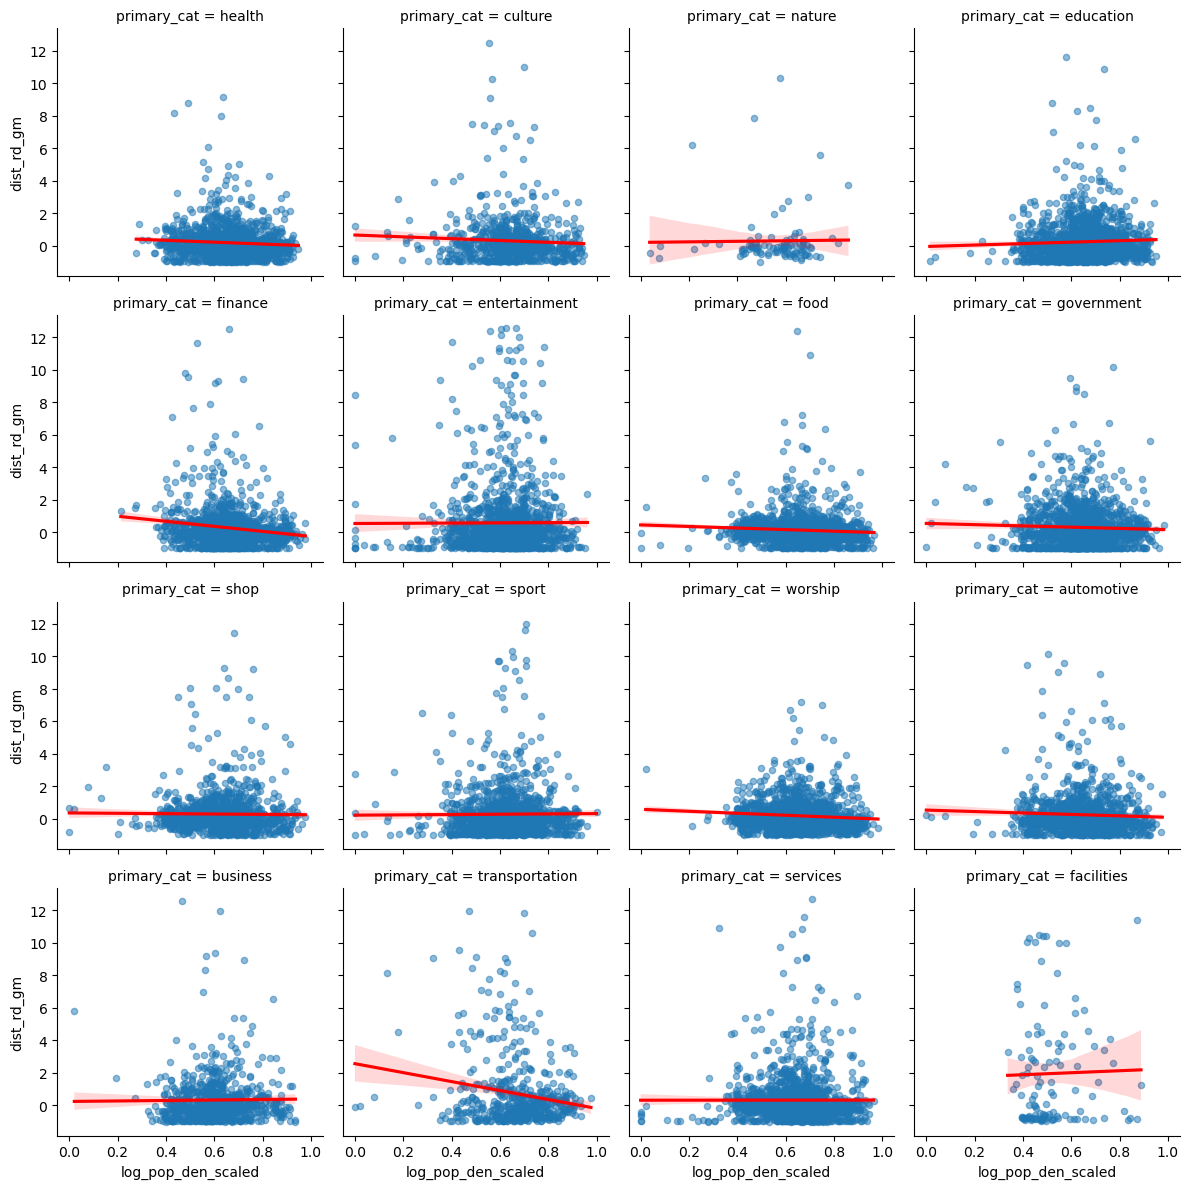

In [114]:
import seaborn as sns

q01 = tract_cat_m_gpf_p['dist_rd_gm'].quantile(0.01)
q99 = tract_cat_m_gpf_p['dist_rd_gm'].quantile(0.99)

sns.lmplot(
    data=tract_cat_m_gpf_p[(tract_cat_m_gpf_p['dist_rd_gm'] > q01) & (tract_cat_m_gpf_p['dist_rd_gm'] < q99)],
    y='dist_rd_gm',
    x='log_pop_den_scaled',
    col='primary_cat',
    col_wrap=4,
    scatter_kws={'alpha': 0.5, 's': 20},
    line_kws={'color': 'red'},
    height=3,
    aspect=1
)


In [115]:
tract_cat_m_gpf_p.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   STATEFP             18110 non-null  object  
 1   GEOID               18110 non-null  object  
 2   geometry            18110 non-null  geometry
 3   primary_cat         18110 non-null  object  
 4   n_true_match        18110 non-null  int64   
 5   median_dist         18110 non-null  float64 
 6   mean_dist           18110 non-null  float64 
 7   n_google            18110 non-null  int64   
 8   coverage            18110 non-null  float64 
 9   tot_pop_est         18110 non-null  float64 
 10  location_acc_score  18110 non-null  float64 
 11  acc_rank            18110 non-null  float64 
 12  acc_z               18110 non-null  float64 
 13  pop_rank            18110 non-null  float64 
 14  PrimaryRUCA         18028 non-null  float64 
 15  PopDensity          18028 no

In [116]:
dmin = tract_cat_m_gpf_p["dist_to_ts"].min()
dmax = tract_cat_m_gpf_p["dist_to_ts"].max()
bins = np.linspace(dmin, dmax, 21)

tract_cat_m_gpf_p["dist_bin"] = pd.cut(
    tract_cat_m_gpf_p["dist_to_ts"],
    bins=bins,
    include_lowest=True
)

def summarize_by_dist_bin(df_cat):
    df_cat = df_cat.copy()
    df_bin = (
        df_cat.groupby("dist_bin", observed=True)
              .agg(
                  total_true_match=("n_true_match", "sum"),
                  total_google=("n_google", "sum"),
                  n_tracts=("n_true_match", "size"),
                  median_dist_rd_gm=("dist_rd_gm", "median"),
              )
              .reset_index()
    )

    df_bin["coverage"] = (
        df_bin["total_true_match"] / df_bin["total_google"]
    )

    return df_bin

df_all_bins = (
    tract_cat_m_gpf_p
    .groupby("primary_cat", group_keys=True, observed=True)
    .apply(summarize_by_dist_bin)
    .reset_index()
)

df_all_bins["bin_id"] = (
    df_all_bins
    .groupby("primary_cat")
    .cumcount() + 1
)

# Overture with Dohmh City-level data

In [617]:
dohmh_res = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/DOHMH_New_York_City_Restaurant_Inspection_Results_20251227.geojson')
dohmh_res = dohmh_res.rename(columns={':id':'id',':version':'version',':created_at':'created_at',':updated_at':'updated_at','dba':'name'})
dohmh_res['updated_year'] = pd.to_datetime(dohmh_res['updated_at']).dt.year
dohmh_res["address"] = (dohmh_res["building"].astype(str) + " " + dohmh_res["street"])
# dohmh_res = dohmh_res[['id','version','name','address','updated_year','geometry']]
dohmh_res['category'] = 'Restaurant'
dohmh_res=  dohmh_res.dropna(subset=['geometry']).reset_index(drop=True)

In [620]:
dohmh_res[['name', 'address']].value_counts().head(10)

name                       address             
"U" LIKE CHINESE TAKE OUT  4926 BROADWAY           1
PADDY QUINNS               42-07 162 STREET        1
PAERDUO                    133-16 39 AVENUE        1
PADOCA BAKERY              210 EAST   67 STREET    1
                           1663 1 AVENUE           1
PADO IS BACK               171-53 46 AVENUE        1
PADMORE'S                  1223 BEDFORD AVENUE     1
PADISHAH RESTAURANT        1920 AVENUE U           1
PADI D' NYC                42 WEST   42 STREET     1
                           135 WEST   50 STREET    1
Name: count, dtype: int64

In [619]:
dohmh_res = (
    dohmh_res
    .drop_duplicates(
        subset=['name','address','updated_year','geometry']
    )
    .reset_index(drop=True)
)
dohmh_res

,id,version,created_at,updated_at,camis,name,boro,building,street,zipcode,...,bbl,nta,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_sbqj_enih,:@computed_region_92fq_4b7q,geometry,updated_year,address,category
0,row-3rda.zmw6_xp4m,rv-pdr7_f9vf.8tba,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50153196,KETEA,Queens,36-12,MAIN STREET,11354,...,4049710041,QN22,22,3,67,3,POINT (-73.83171 40.76252),2025,36-12 MAIN STREET,Restaurant
1,row-ytqa~g2vr.6a5z,rv-59qb.f9a2_ueuj,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50169800,APPLE BLOSSOM,Queens,40-05,SKILLMAN AVENUE,11104,...,4001830292,QN31,53,3,66,33,POINT (-73.92342 40.74720),2025,40-05 SKILLMAN AVENUE,Restaurant
2,row-rx7s_2p9t-iqp4,rv-tek2-4v6w_zjc6,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50176849,THE BLUE BLOSSOM,Brooklyn,135,NORTH 5 STREET,11249,...,3023350029,BK73,36,2,57,38,POINT (-73.95925 40.71694),2025,135 NORTH 5 STREET,Restaurant
3,row-bjv9.8q5f~gtur,rv-naqd~wgdf.tvjs,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50180060,GREENLAND DELI PLUS CORP,Bronx,4311,KATONAH AVENUE,10470,...,2033780057,BX62,29,5,30,40,POINT (-73.86747 40.89905),2025,4311 KATONAH AVENUE,Restaurant
4,row-fn6x.ecsd-rr8d,rv-r2u5-2k5n.i3cs,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50177809,FERMENTO,Manhattan,226,VARICK STREET,10014,...,1005280056,MN23,57,4,3,10,POINT (-74.00523 40.72913),2025,226 VARICK STREET,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29762,row-ym4t.mqkm.3x6i,rv-zbkb_xwgn-qq6y,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50177902,ARTHOUSE,Brooklyn,2717,AVENUE U,11229,...,3073320048,BK44,32,2,36,8,POINT (-73.94450 40.60014),2025,2717 AVENUE U,Restaurant
29763,row-aqni_a5n2.jh4z,rv-qhys.eupn-mnyz,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50177834,RAMEN BY RA,Manhattan,70,EAST 1 STREET,10003,...,1004430040,MN22,70,4,5,50,POINT (-73.98877 40.72341),2025,70 EAST 1 STREET,Restaurant
29764,row-4tez.e9t5~h2pz,rv-ntr4-wi27_6rec,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50172734,EARTHBAR,Manhattan,69,PRINCE STREET,10012,...,1005110001,MN24,57,4,2,32,POINT (-73.99707 40.72393),2025,69 PRINCE STREET,Restaurant
29765,row-n9j7-7v3f~i36m,rv-hd2r.v9w7~64zn,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50163793,ERNST & YOUNG - 8TH FLOOR,Manhattan,1,MANHATTAN WEST,10001,...,1007297504,MN13,12,4,6,10,POINT (-73.99713 40.75226),2025,1 MANHATTAN WEST,Restaurant


In [555]:
dohmh_res.to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/dohmh_res.geojson', driver="GeoJSON")

In [369]:
dohmh_res = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/dohmh_res.geojson', driver="GeoJSON")

In [372]:
ove_food = ["eat_and_drink","restaurant", "afghan_restaurant", "african_restaurant","ethiopian_restaurant","senegalese_restaurant","south_african_restaurant","moroccan_restaurant","nigerian_restaurant",
"american_restaurant","arabian_restaurant","belgian_restaurant","latin_american_restaurant","argentine_restaurant","belizean_restaurant","bolivian_restaurant",
"brazilian_restaurant","chilean_restaurant","colombian_restaurant","costa_rican_restaurant","cuban_restaurant","ecuadorian_restaurant","guatemalan_restaurant","honduran_restaurant","mexican_restaurant","nicaraguan_restaurant","panamanian_restaurant","paraguayan_restaurant",
"peruvian_restaurant","puerto_rican_restaurant","salvadoran_restaurant","texmex_restaurant","uruguayan_restaurant","venezuelan_restaurant","middle_eastern_restaurant","armenian_restaurant","azerbaijani_restaurant","egyptian_restaurant","georgian_restaurant","israeli_restaurant",
"kofta_restaurant","kurdish_restaurant","lebanese_restaurant","persian_iranian_restaurant","syrian_restaurant","turkish_restaurant","asian_restaurant","asian_fusion_restaurant","pan_asian_restaurant","burmese_restaurant","cambodian_restaurant","chinese_restaurant",
"dim_sum_restaurant","filipino_restaurant","indo_chinese_restaurant","indonesian_restaurant","japanese_restaurant","korean_restaurant","sushi_restaurant","laotian_restaurant","malaysian_restaurant","mongolian_restaurant","noodles_restaurant","singaporean_restaurant",
"taiwanese_restaurant","thai_restaurant","vietnamese_restaurant","hong_kong_style_cafe","australian_restaurant","austrian_restaurant","bangladeshi_restaurant","indian_restaurant","basque_restaurant","british_restaurant","eastern_european_restaurant","belarusian_restaurant","bulgarian_restaurant","romanian_restaurant","tatar_restaurant","ukrainian_restaurant","french_restaurant","cajun_and_creole_restaurant","canadian_restaurant","caribbean_restaurant",
"dominican_restaurant","haitian_restaurant","jamaican_restaurant","trinidadian_restaurant","german_restaurant","catalan_restaurant","italian_restaurant","czech_restaurant","mediterranean_restaurant","greek_restaurant","guamanian_restaurant","hawaiian_restaurant","himalayan_nepalese_restaurant","hungarian_restaurant","iberian_restaurant","irish_restaurant","jewish_restaurant","international_restaurant","european_restaurant","oriental_restaurant",
"pakistani_restaurant","polish_restaurant","polynesian_restaurant","portuguese_restaurant","russian_restaurant","scandinavian_restaurant","danish_restaurant","norwegian_restaurant","scottish_restaurant","seafood_restaurant","serbo_croatian_restaurant","slovakian_restaurant","southern_restaurant","spanish_restaurant","sri_lankan_restaurant","swiss_restaurant","uzbek_restaurant","molecular_gastronomy_restaurant","haute_cuisine_restaurant","salad_bar",
"brasserie","buffet_restaurant","barbecue_restaurant","burger_restaurant","canteen","cafeteria","cheesesteak_restaurant","chicken_restaurant","chicken_wings_restaurant","dog_meat_restaurant","dumpling_restaurant","fast_food_restaurant","fischbrotchen_restaurant","acai_bowls","fish_restaurant","fish_and_chips_restaurant","fondue_restaurant","gluten_free_restaurant","baozi_restaurant","halal_restaurant",
"bistro","health_food_restaurant","kosher_restaurant","comfort_food_restaurant","meat_restaurant","curry_sausage_restaurant","diner","diy_foods_restaurant","doner_kebab","empanadas","nasi_restaurant","flatbread_restaurant","food_court","gastropub","pizza_restaurant","pop_up_restaurant","poutinerie_restaurant","vegan_restaurant","vegetarian_restaurant","wok_restaurant",
"wrap_restaurant","piadina_restaurant","poke_restaurant","pigs_trotters_restaurant","potato_restaurant","rotisserie_chicken_restaurant","schnitzel_restaurant","soul_food","steakhouse","supper_club","tapas_bar","venison_restaurant","wild_game_meats_restaurant","falafel_restaurant","taco_restaurant","hot_dog_restaurant","live_and_raw_food_restaurant","soup_restaurant","theme_restaurant","bar_and_grill_restaurant",
"meatball_restaurant","waffle_restaurant","breakfast_and_brunch_restaurant","pancake_house","bagel_restaurant","baguettes","bar","airport_lounge","beach_bar","beer_bar","beer_garden","brewery","bubble_tea","champagne_bar","cidery","cigar_bar","cocktail_bar","dive_bar","drive_thru_bar","gay_bar",
"hookah_bar","hotel_bar","irish_pub","kombucha","lounge","milk_bar","milkshake_bar","pub","sake_bar","speakeasy","sports_bar","sugar_shack","tabac","tiki_bar","vermouth_bar","whiskey_bar","wine_bar","smoothie_juice_bar","piano_bar","cafe",
"coffee_roastery","tea_room","coffee_shop"]

In [621]:
nyc_ct = gpd.read_file('/Users/houpuli/Downloads/NYC_Borough_Boundary_5648926780594355063.geojson')
nyc_ct_geom = nyc_ct.dissolve()
nyc_ct_geom = nyc_ct_geom[['geometry']]
nyc_ove = ny_ove_msa.sjoin(nyc_ct_geom, how='inner', predicate='intersects')
nyc_ove = nyc_ove.rename(columns={'names':'name'})
nyc_ove[nyc_ove['cat_main'].isin(ove_food)]

,id,name,confidence,cat_main,cat_alt,address,operating_status,version,sources,geometry,index_right
90313,84527235-2105-4200-a842-251787f58234,TACO BELL,0.979395,taco_restaurant,NaN,12 E 125TH ST,open,4,"[ { ""property"": """", ""dataset"": ""Microsoft"", ""l...",POINT (-73.94166 40.80616),0
90317,c2a96fe5-8808-42a8-b41f-bd64cf213185,375º CHICKEN 'N FRIES,0.950063,fast_food_restaurant,"chicken_restaurant, american_restaurant",12 E 125TH ST,open,2,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.94169 40.80601),0
90318,0c77e804-68d7-4d02-8092-8fa2560b8650,PIZZA HUT EXPRESS,0.400000,fast_food_restaurant,NaN,12 E 125TH STREET,open,2,"[ { ""property"": """", ""dataset"": ""AllThePlaces"",...",POINT (-73.94168 40.80602),0
90326,9290f657-2cc0-48ec-8236-55358aadc031,CHARLIE'S PLACE,0.980676,sushi_restaurant,"japanese_restaurant, asian_restaurant",1960 MADISON AVE,open,6,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.94047 40.80616),0
90478,1b79c495-4150-47fb-873f-4d7a07876dd4,9TAILS COFFEE SHOP,0.974279,coffee_shop,cafe,34 W 126TH ST,open,5,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.94323 40.80757),0
...,...,...,...,...,...,...,...,...,...,...,...
849791,796da50f-e857-47ee-82b7-b610efd2419e,SMITHFIELD HALL NYC,0.992366,sports_bar,"bar_and_grill_restaurant, bar",138 W 25TH ST,open,6,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.99352 40.74478),0
849840,4ded47f8-a03b-4d37-8f9d-61b163cadfff,ONE STAR,0.979974,bar,"bar_and_grill_restaurant, pub",147 W 24TH ST,open,6,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.99421 40.74443),0
849864,66d55ba4-e015-4384-95ab-4e23818e3e67,PISILLO ITALIAN PANINI,0.972841,fast_food_restaurant,"sandwich_shop, delicatessen, food, restaurant",124 W 25 ST,open,4,"[ { ""property"": """", ""dataset"": ""Microsoft"", ""l...",POINT (-73.99309 40.74443),0
849866,3976f837-655e-4358-a157-d01c8e52728a,TABERU NOMU,0.973592,restaurant,"asian_restaurant, japanese_restaurant",124 W 25TH ST,open,4,"[ { ""property"": """", ""dataset"": ""meta"", ""licens...",POINT (-73.99306 40.74446),0


In [622]:
# 将 name 列全部大写
ny_ove_msa['name'] = ny_ove_msa['name'].str.upper()
# 将 address 列全部大写
ny_ove_msa['address'] = ny_ove_msa['address'].str.upper()

In [623]:
ny_c_ove = search_spatial_candidates(dohmh_res,ny_ove_msa,k=300)

In [624]:
ny_c_ove = match_by_name(ny_c_ove,ny_ove_msa,threshold=80)

In [625]:
ny_c_ove = address_score_check(ny_c_ove,ny_ove_msa, addr_col_ref = "address")

In [ ]:
# ny_c_ove.drop(columns=['cand_ids','cand_dist_m']).to_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_c_ove_restaurant.geojson', driver="GeoJSON")

<Axes: >

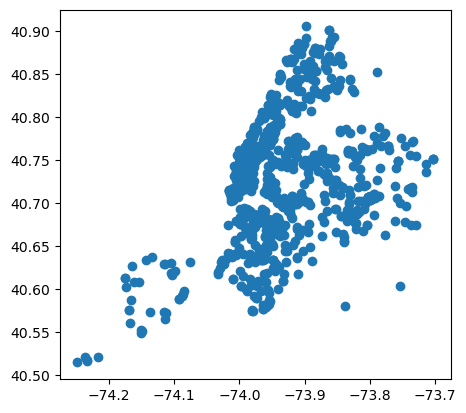

In [257]:
sampled = ny_c_ove[ny_c_ove["matched_id"].notna()].sample(
    n=1000,
    random_state=42
)
sampled.plot()

In [258]:
sampled['index'] = sampled.index

,name,address,updated_year,category,geometry,cand_ids,cand_dist_m,matched_id,name_score,location_distance,matched_name,address_score,matched_address,index
120458,TWIST IT TOP IT FROZEN YOGURT,158-18 CROSSBAY BOULEVARD,2025,Restaurant,POINT (-73.84018 40.66038),"[22f345ab-5fe4-4904-874c-4b6eeb785d6c, 86df6e1...","[33.21116322514015, 34.98341656707074, 41.3352...",86df6e16-95c1-4f95-8518-410966fa0575,100.000000,34.983417,TWIST IT TOP IT FROZEN YOGURT,84,158-18A,120458
70519,EL NUEVO SANDY RESTAURANT,2261 2 AVENUE,2025,Restaurant,POINT (-73.93771 40.79710),"[64e75dcb-e48b-40db-a40a-396790be30b8, c1e9241...","[21.831029034336247, 29.547665653148226, 34.00...",c1e92416-09e4-42b0-9a0c-37ac875bbe93,90.000000,29.547666,SANDY RESTAURANT,80,2261 2ND AVE,70519
268885,DYNASTY TASTE,77 RICHMOND HILL ROAD,2025,Restaurant,POINT (-74.16564 40.58783),"[a8465b9e-4c41-4c93-827c-27094c7230a9, c89440d...","[14.003025478106522, 36.90148492788095, 41.066...",7ad59a46-bbee-4d16-b019-6f71760ac494,100.000000,45.179411,DYNASTY TASTE,95,77 RICHMOND HILL RD,268885
245850,BK9,62 5 AVENUE,2025,Restaurant,POINT (-73.97726 40.68114),"[9fb10215-a948-43ff-b724-aefbaf2d1af6, 4991ecf...","[5.228665875027074, 9.858073223255248, 10.5774...",1657e587-0bb9-46d5-8ae3-9b3493127ae6,100.000000,10.577454,BK9,76,62 5TH AVE,245850
39881,DUNKIN,439 CRESCENT STREET,2025,Restaurant,POINT (-73.87063 40.67791),"[7055e2bf-c367-49f2-ab05-e7939a65a257, f88fa56...","[9.861250084374475, 22.093725748018574, 34.876...",f88fa565-58dc-40f4-85fa-ede7ffde0208,92.307692,22.093726,DUNKIN',88,439 CRESCENT ST,39881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20084,CAPITAL RESTAURANT,4933 BROADWAY,2025,Restaurant,POINT (-73.92160 40.86756),"[909d485b-ce77-4478-a92c-c4af0a85cb2f, 30b033a...","[13.753814420420014, 13.905455847778025, 18.19...",11278a2b-e911-4970-a07f-44304cfe3d38,94.444444,40.058032,CAPITOL RESTAURANT,100,4933 BROADWAY,20084
225939,N BAKERY,1323 AVENUE U,2025,Restaurant,POINT (-73.95798 40.59866),"[cf540405-e73f-4fdc-be7d-23a93efb22a6, 5ce474b...","[11.116939395810578, 12.846611748883246, 14.96...",3cd4fbce-c922-4c34-a26a-25bc3e0a59ea,100.000000,55.03702,N BAKERY,100,1323 AVENUE U,225939
275028,CLAUDETTE,24 5 AVENUE,2025,Restaurant,POINT (-73.99581 40.73300),"[1d3540a2-47f4-4dcf-ab04-b90384ee23c4, 7ad1793...","[3.4170482797278954, 11.807142751478192, 15.46...",b1d68d50-8c20-429c-ba76-c56ce21cbf2a,100.000000,29.5745,CLAUDETTE,76,24 5TH AVE,275028
247025,COBBLE HILL CINEMAS,265 COURT STREET,2025,Restaurant,POINT (-73.99464 40.68494),"[8f32bf19-0c67-44cd-ad0e-7502c9626eb4, fc4ee4a...","[16.312904247668715, 19.182123112283463, 19.28...",010053bd-e809-4cbd-9702-ec451d6324c1,100.000000,24.084753,COBBLE HILL CINEMAS,85,265 COURT ST,247025


In [259]:
sampled[['index','name','address','name_score','location_distance','address_score','matched_name','matched_address']].to_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_city_ove_1000_sample.csv',index=False)

In [326]:
sampled_matched = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_city_ove_1000_sample.csv')

In [327]:
sampled_matched['is_true_match'].value_counts()

is_true_match
1    860
0    140
Name: count, dtype: int64

### Traning Model

In [341]:
df = sampled_matched.copy()

In [ ]:
df['name_score'] = pd.to_numeric(df['name_score'],errors='coerce')
df['address_score'] = pd.to_numeric(df['address_score'],errors='coerce')
df['address_score'] = df['address_score'].fillna(0)
df['location_distance'] = pd.to_numeric(df['location_distance'],errors='coerce')

df['is_true_match'] = pd.to_numeric(df['is_true_match'], errors='coerce')
df['is_true_match'] = df['is_true_match'].astype(bool)

In [344]:
from sklearn.preprocessing import StandardScaler

X = df[['name_score', 'location_distance', 'address_score']]
y = df['is_true_match']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [345]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y  # keep the same proportion of True vs False in training set and test set
)

In [346]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

gb_y_pred = gb_clf.predict(X_test)
gb_y_prob = gb_clf.predict_proba(X_test)[:, 1]

gb_cr = classification_report(y_test, gb_y_pred)
gb_auc = roc_auc_score(y_test, gb_y_prob)

print(gb_cr)
print("GradientBoosting of AUC:", gb_auc)

              precision    recall  f1-score   support

       False       0.85      0.80      0.82        35
        True       0.97      0.98      0.97       215

    accuracy                           0.95       250
   macro avg       0.91      0.89      0.90       250
weighted avg       0.95      0.95      0.95       250

GradientBoosting of AUC: 0.9838538205980067


In [383]:
print(f'The first step match rate is',ny_c_ove['matched_id'].notna().sum() / len(ny_c_ove))

The first step match rate is 0.8040111532905566


In [387]:
ny_c_ove['name_score'] = pd.to_numeric(ny_c_ove['name_score'],errors='coerce')
ny_c_ove['address_score'] = pd.to_numeric(ny_c_ove['address_score'],errors='coerce')
ny_c_ove['address_score'] = ny_c_ove['address_score'].fillna(0)
ny_c_ove['location_distance'] = pd.to_numeric(ny_c_ove['location_distance'],errors='coerce')

In [391]:
mask = ny_c_ove['matched_id'].notnull()
df_pred = ny_c_ove.loc[mask].copy()

feature_cols = ['name_score', 'location_distance', 'address_score']
df_pred['address_score'] = df_pred['address_score'].fillna(0)
df_pred[feature_cols] = df_pred[feature_cols].astype(float)

X_new = scaler.transform(df_pred[feature_cols])
df_pred['true_match_prob'] = gb_clf.predict_proba(X_new)[:, 1]
df_pred['is_true_match'] = df_pred['true_match_prob'] >= 0.5

ny_c_ove.loc[mask, 'is_true_match'] = df_pred['is_true_match']
ny_c_ove.loc[mask, 'true_match_prob'] = df_pred['true_match_prob']

In [392]:
ny_c_ove['is_true_match'].value_counts()

is_true_match
True     20204
False     3729
Name: count, dtype: int64

In [395]:
print(f'The second match rate is', len(ny_c_ove[ny_c_ove['is_true_match'] == True]) / len(ny_c_ove[ny_c_ove['matched_id'].notna()]))

The second match rate is 0.8441900305018176


In [399]:
# ny_c_ove = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_c_ove.geojson', driver="GeoJSON")  

In [400]:
true_match_c_ove = ny_c_ove[(ny_c_ove['is_true_match'] == True) | (ny_c_ove['is_true_match'] == "1")]
true_match_c_ove

,name,address,updated_year,category,geometry,cand_ids,cand_dist_m,matched_id,name_score,location_distance,matched_name,address_score,matched_address,is_true_match,true_match_prob
11,THE HIGHLINE CAFE INC,368 9 AVENUE,2025,Restaurant,POINT (-73.99773 40.75141),"[a31bc240-15f8-42af-8614-3951bfd3a9e0, e2d5bfd...","[21.797506487433864, 21.797506487433864, 23.54...",a31bc240-15f8-42af-8614-3951bfd3a9e0,100.000000,21.797506,THE HIGHLINE CAFE INC,55.0,"368 9 AV, FLR GRD",True,0.987672
12,PANDA EXPRESS INC,84 COURT STREET,2025,Restaurant,POINT (-73.99161 40.69129),"[87223de5-7897-4f09-9392-b9874189c032, 486ff99...","[6.230679456943064, 12.7687769138465, 19.00770...",3fae34de-ee37-4576-ae3f-b04caa8c53a1,95.000000,32.464046,PANDA EXPRESS,100.0,84 COURT STREET,True,0.989808
14,DOMINO'S PIZZA #3692,1993 3 AVENUE,2025,Restaurant,POINT (-73.94303 40.79380),"[5401db64-f334-44de-a085-2e694ee1ae51, f6447ef...","[8.685354913608823, 17.037176059445574, 18.402...",f6447ef0-cc93-46b6-b376-d833a2904ac6,95.000000,17.037176,DOMINO'S PIZZA,80.0,1993 3RD AVE,True,0.972130
17,JOHN'S PIZZERIA,278 BLEECKER STREET,2025,Restaurant,POINT (-74.00328 40.73169),"[df11264d-61dd-49b3-a2a7-19b105ea7329, c813848...","[3.7152475715210986, 5.2496397147875165, 16.87...",19d0163b-8aed-486b-abff-7ee99d9b42b9,90.000000,23.990568,"THE ""ORIGINAL"" JOHN'S PIZZERIA",88.0,278 BLEECKER ST,True,0.995344
19,TUMI,689 9 AVENUE,2025,Restaurant,POINT (-73.99014 40.76186),"[acec8d7f-3d67-40aa-b80a-e8b516a5e5b3, 1a7080a...","[5.490309823172479, 8.731443582879278, 11.9234...",7ac82346-32c7-4843-a627-a44e94fa48cf,90.000000,33.201925,TUMI PERUVIAN RESTAURANT NYC,78.0,689 9TH AVE,True,0.948957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29745,MARGARITA ISLAND,1105 BOWERY STREET,2025,Restaurant,POINT (-73.97903 40.57473),"[542763f4-9895-4ac6-8e58-40f4421a8837, 7b48588...","[9.280320425128641, 21.468741328772307, 34.423...",81901260-c40b-4a2e-b253-cc6d6db2f638,100.000000,34.423794,MARGARITA ISLAND,87.0,1105 BOWERY ST,True,0.997564
29750,BANG BANG BANGKOK,131 GRAND STREET,2025,Restaurant,POINT (-73.96245 40.71498),"[4b69f150-c742-4305-bd27-0d4f963a58b7, 9a4721a...","[9.26231874272974, 9.987736461694745, 12.14152...",7ddbed79-7aba-4390-8745-02572538ee7c,100.000000,25.584065,BANG BANG BANGKOK,85.0,131 GRAND ST,True,0.997509
29753,'ESSEN,290 MADISON AVENUE,2025,Restaurant,POINT (-73.98000 40.75183),"[6076541c-7f35-4c71-abbf-19b37b6920d6, 41fe68f...","[5.872433372123716, 8.200950208407745, 9.37593...",87fb4162-8b4c-4c11-8d8c-d37973ddc701,81.818182,18.412894,ESSEN FOOD 40,90.0,290 MADISON AVE,True,0.998394
29757,PHO JOHN ST,45 JOHN STREET,2025,Restaurant,POINT (-74.00800 40.70923),"[424341f1-9534-4185-b30c-d91882c86ebe, 0a6080b...","[8.975718742208048, 13.41797223236371, 15.0505...",424341f1-9534-4185-b30c-d91882c86ebe,85.500000,8.975719,JOHN STREET UNITED METHODIST CHURCH,75.0,44 JOHN ST,True,0.574071


In [ ]:
# google_cat_count
ny_c_cat = ny_c_ove['category'].value_counts()
ny_c_cat = pd.DataFrame(ny_c_cat)
ny_c_cat = ny_c_cat.rename(columns={'count':'cityrest_count'})

# oveture_m_cat_count
ny_c_ove_m_cat = true_match_c_ove['category'].value_counts()
ny_c_ove_m_cat = pd.DataFrame(ny_c_ove_m_cat)
ny_c_ove_m_cat = ny_c_ove_m_cat.rename(columns={'count':'ove_count'})

df_merge = ny_c_ove_m_cat.merge(ny_c_cat, left_index=True, right_index=True, how="inner")
df_merge['ove_c_m'] = df_merge['ove_count'] / df_merge['cityrest_count']
df_merge = df_merge.reset_index()

In [464]:
us_pop_tract_acs5 = pd.read_csv('/Users/houpuli/Downloads/ACSDT5Y2023.B01003_2026-01-16T133429/ACSDT5Y2023.B01003-Data.csv')
us_pop_tract_acs5 = us_pop_tract_acs5.rename(columns={'B01003_001E':'tot_pop_est'})
us_pop_tract_acs5 = us_pop_tract_acs5.loc[1:]
us_pop_tract_acs5['GEOID'] = us_pop_tract_acs5['GEO_ID'].str[-11:]
us_pop_tract_acs5 = us_pop_tract_acs5[['GEOID','NAME','tot_pop_est']]
us_cbsa = gpd.read_file("/Users/houpuli/Downloads/Core_based_statistical_area_for_the_US_July_2023_4764927935501855778.geojson")
us_msa = us_cbsa[us_cbsa['CBSATYPE'] == 'Metropolitan Statistical Area']
msa_ny = us_msa[us_msa['CBSACODE']=='35620']
us_cbsa = gpd.read_file("/Users/houpuli/Downloads/Core_based_statistical_area_for_the_US_July_2023_4764927935501855778.geojson")
us_msa = us_cbsa[us_cbsa['CBSATYPE'] == 'Metropolitan Statistical Area']
msa_ny_b = us_msa[us_msa['CBSACODE']=='35620']

ny_s_tracts = gpd.read_file('/Users/houpuli/Downloads/tl_2023_36_tract.zip')
pa_s_tract = gpd.read_file('/Users/houpuli/Downloads/tl_2023_42_tract.zip')
ct_s_tract = gpd.read_file('/Users/houpuli/Downloads/tl_2023_09_tract.zip')
nj_s_tract = gpd.read_file('/Users/houpuli/Downloads/tl_2023_34_tract.zip')
ny_pa_ct_nj_t = gpd.GeoDataFrame(pd.concat([ny_s_tracts, pa_s_tract, ct_s_tract, nj_s_tract],ignore_index=True),crs=ny_s_tracts.crs)
ny_pa_ct_nj_t = ny_pa_ct_nj_t.to_crs(epsg=4326)

ny_msa_tracts = gpd.sjoin(ny_pa_ct_nj_t,msa_ny[['geometry']],how='inner',predicate='intersects')
ny_msa_tracts = ny_msa_tracts[['STATEFP','GEOID','geometry']]
ny_msa_tracts_pop = ny_msa_tracts.merge(us_pop_tract_acs5,on='GEOID',how='left')
ny_msa_tracts_pop = ny_msa_tracts_pop.dropna(subset=['tot_pop_est'])
ny_msa_tracts_pop['tot_pop_est'] = ny_msa_tracts_pop['tot_pop_est'].astype(float)

In [465]:
ny_c_ove_t_p = gpd.sjoin(ny_c_ove, ny_msa_tracts_pop, how='left', predicate='within')

In [466]:
cla_gdf = ny_c_ove_t_p.loc[(ny_c_ove_t_p['is_true_match'] == True) | (ny_c_ove_t_p['is_true_match'] == "1")].copy()
cla_gdf['location_distance'] = cla_gdf['location_distance'].astype(float)

tract_cat_m = (
    cla_gdf
    .groupby(['GEOID', 'category'])
    .agg(
        n_true_match=('location_distance', 'size'),
        median_dist=('location_distance', 'median'),
        mean_dist=('location_distance', 'mean')
    )
    .reset_index()
)
tract_cat_m

,GEOID,category,n_true_match,median_dist,mean_dist
0,36005000400,Restaurant,1,19.291324,19.291324
1,36005001901,Restaurant,8,27.892244,25.569810
2,36005001902,Restaurant,3,37.998792,34.155676
3,36005001903,Restaurant,2,23.067509,23.067509
4,36005002002,Restaurant,2,23.609348,23.609348
...,...,...,...,...,...
1894,36085029104,Restaurant,25,68.498259,106.708772
1895,36085029105,Restaurant,10,80.366225,95.261891
1896,36085030301,Restaurant,10,91.918455,102.580788
1897,36085030302,Restaurant,12,79.382370,71.384031


In [467]:
tract_cat_nc = ny_c_ove_t_p.groupby(['GEOID', 'category']).size().reset_index(name='n_city')

In [468]:
tract_cat_m = tract_cat_m.merge(
    tract_cat_nc,
    on=['GEOID', 'category'],
    how='left'
)

tract_cat_m['coverage'] = tract_cat_m['n_true_match'] / tract_cat_m['n_city']

tract_cat_m_gpf = ny_msa_tracts.merge(tract_cat_m, on='GEOID', how='inner')

In [469]:
tract_cat_m_gpf

,STATEFP,GEOID,geometry,category,n_true_match,median_dist,mean_dist,n_city,coverage
0,36,36081003400,"POLYGON ((-73.86630 40.68319, -73.86549 40.683...",Restaurant,6,59.030606,69.155995,6,1.000000
1,36,36081003900,"POLYGON ((-73.94330 40.76066, -73.94247 40.761...",Restaurant,4,32.162563,47.955652,6,0.666667
2,36,36081003600,"POLYGON ((-73.86410 40.68237, -73.86370 40.682...",Restaurant,1,23.098440,23.098440,1,1.000000
3,36,36081003800,"POLYGON ((-73.85280 40.68425, -73.85196 40.684...",Restaurant,4,19.158663,27.238545,8,0.500000
4,36,36081004001,"POLYGON ((-73.85113 40.68281, -73.85028 40.683...",Restaurant,8,17.191123,23.771258,9,0.888889
...,...,...,...,...,...,...,...,...,...
1894,36,36081109300,"POLYGON ((-73.78459 40.77614, -73.78441 40.776...",Restaurant,2,121.439347,121.439347,3,0.666667
1895,36,36081141700,"POLYGON ((-73.79730 40.74943, -73.79645 40.749...",Restaurant,4,22.552344,24.201746,4,1.000000
1896,36,36081006202,"POLYGON ((-73.86317 40.65828, -73.86151 40.659...",Restaurant,11,62.537839,62.180544,13,0.846154
1897,36,36061016900,"POLYGON ((-73.97644 40.78573, -73.97598 40.786...",Restaurant,39,17.430102,22.185181,49,0.795918


In [471]:
tract_cat_m_gpf_p['location_acc_score'] = 1 / (tract_cat_m_gpf_p['median_dist'] + 1) # from low to high, present the absolute accuracy by cat
tract_cat_m_gpf_p['acc_rank'] = tract_cat_m_gpf_p.groupby('category')['location_acc_score'].rank(pct=True, method='average') # from low accuracy to high, presents the releative accuracy by cat
tract_cat_m_gpf_p['acc_z'] = tract_cat_m_gpf_p.groupby('category')['location_acc_score'].transform(lambda s: (s - s.mean()) / s.std(ddof=0))

tract_cat_m_gpf_p['pop_rank'] = tract_cat_m_gpf_p.groupby('category')['tot_pop_est'].rank(pct=True, method='average') # from low accuracy to high, presents the releative populaton by cat

In [474]:
# dist_relative_deviation from the group median
tract_cat_m_gpf_p['dist_rd_gm'] = tract_cat_m_gpf_p.groupby('category')['median_dist'].transform(lambda s: (s - s.median()) / s.median())

from shapely.geometry import Point

ts_p = Point(-73.98552115962701, 40.757986758482154)
ts_gdf = gpd.GeoDataFrame(geometry=[ts_p],crs="EPSG:4326")

gdf_proj = tract_cat_m_gpf_p.to_crs(epsg=3857)
ts_proj = ts_gdf.to_crs(epsg=3857)

# polygon centroid → Times Square 距离
gdf_proj["dist_to_ts"] =  gdf_proj.geometry.centroid.distance(ts_proj.geometry.iloc[0])
tract_cat_m_gpf_p["dist_to_ts"] = gdf_proj["dist_to_ts"]

In [476]:
ruca_r = pd.read_csv('/Users/houpuli/Downloads/RUCA-codes-2020-tract.csv', encoding='latin1')
ruca_r = ruca_r[['TractFIPS20','PrimaryRUCA','PopDensity']]
ruca_r['TractFIPS20'] = ruca_r['TractFIPS20'].astype(str)
ruca_r = ruca_r.rename(columns={'TractFIPS20':'GEOID'})
conditions = [
    (ruca_r['PrimaryRUCA'] == 1),
    (ruca_r['PrimaryRUCA'].between(2, 3)),
    (ruca_r['PrimaryRUCA'].between(4, 10))
]
choices = ['urban core', 'suburban/exurban', 'small town/rural']
ruca_r['tract_type'] = np.select(conditions, choices, default='Unknown')

tract_cat_m_gpf_p = tract_cat_m_gpf_p.merge(ruca_r, on='GEOID',how='left')

In [477]:
tract_cat_m_gpf_p['log_pop'] = np.log1p(tract_cat_m_gpf_p['tot_pop_est'])
tract_cat_m_gpf_p['log_pop_den'] = np.log1p(tract_cat_m_gpf_p['PopDensity'])
tract_cat_m_gpf_p['log_median_dist'] = np.log1p(tract_cat_m_gpf_p['median_dist'])

In [489]:
df_all_bins["ring_area"] = df_all_bins["dist_bin"].apply(lambda x: np.pi * (x.right**2 - x.left**2) / 1e6).astype(float) # km2
df_all_bins['true_match_den'] = df_all_bins['total_true_match'] / df_all_bins['ring_area'] # numer/km2

# Google POI match with NYC City ground truth datast

In [39]:
ny_gplc_food = ny_gplc[ny_gplc['primary_cat'] == 'food']
nyc_ct = gpd.read_file('/Users/houpuli/Downloads/NYC_Borough_Boundary_5648926780594355063.geojson')
nyc_ct_geom = nyc_ct.dissolve()
nyc_ct_geom = nyc_ct_geom[['geometry']]
nyc_gplc_food = ny_gplc_food.sjoin(nyc_ct_geom, how='inner', predicate='intersects')

In [40]:
nyc_gplc_food['name'] = nyc_gplc_food['name'].str.upper()
nyc_gplc_food['addr_simple'] = nyc_gplc_food['addr_simple'].str.upper()

<Axes: >

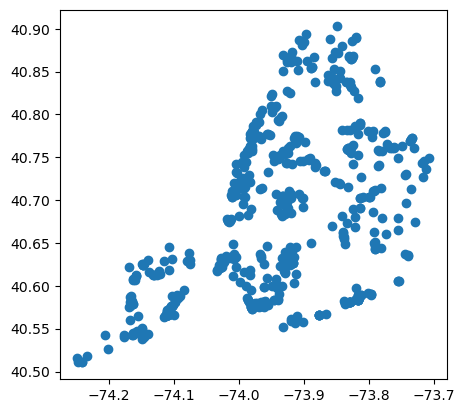

In [41]:
nyc_gplc_food.plot()

In [42]:
dohmh_res = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/update/dohmh_res.geojson', driver="GeoJSON")
dohmh_res['id'] = dohmh_res.index.astype(str)

In [43]:
dohmh_res

,id,version,name,address,updated_year,category,geometry
0,0,rv-pdr7_f9vf.8tba,KETEA,36-12 MAIN STREET,2025,Restaurant,POINT (-73.83171 40.76252)
1,1,rv-59qb.f9a2_ueuj,APPLE BLOSSOM,40-05 SKILLMAN AVENUE,2025,Restaurant,POINT (-73.92342 40.74720)
2,2,rv-tek2-4v6w_zjc6,THE BLUE BLOSSOM,135 NORTH 5 STREET,2025,Restaurant,POINT (-73.95925 40.71694)
3,3,rv-naqd~wgdf.tvjs,GREENLAND DELI PLUS CORP,4311 KATONAH AVENUE,2025,Restaurant,POINT (-73.86747 40.89905)
4,4,rv-r2u5-2k5n.i3cs,FERMENTO,226 VARICK STREET,2025,Restaurant,POINT (-74.00523 40.72913)
...,...,...,...,...,...,...,...
29762,29762,rv-zbkb_xwgn-qq6y,ARTHOUSE,2717 AVENUE U,2025,Restaurant,POINT (-73.94450 40.60014)
29763,29763,rv-qhys.eupn-mnyz,RAMEN BY RA,70 EAST 1 STREET,2025,Restaurant,POINT (-73.98877 40.72341)
29764,29764,rv-ntr4-wi27_6rec,EARTHBAR,69 PRINCE STREET,2025,Restaurant,POINT (-73.99707 40.72393)
29765,29765,rv-hd2r.v9w7~64zn,ERNST & YOUNG - 8TH FLOOR,1 MANHATTAN WEST,2025,Restaurant,POINT (-73.99713 40.75226)


In [49]:
ny_golc_c = search_spatial_candidates(nyc_gplc_food,dohmh_res,k=100)
ny_golc_c = match_by_name(ny_golc_c,dohmh_res,threshold=80)
ny_golc_c = address_score_check(ny_golc_c,dohmh_res, addr_col_ref = "addr_simple")

In [52]:
ny_golc_c = search_spatial_candidates(nyc_gplc_food,dohmh_res,k=100)
ny_golc_c = match_by_name(ny_golc_c,dohmh_res, comp_id_col='category' ,threshold=80)
ny_golc_c = address_score_check(ny_golc_c,dohmh_res, addr_col_ref = "addr_simple")

In [54]:
ny_golc_c['matched_id'].notna().sum()

533

In [633]:
ny_golc_c.drop(columns=['cand_ids','cand_dist_m'])[['name','addr_simple','name_score','location_distance','address_score','matched_name','matched_address']].to_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_golc_c.csv',index=True)

In [33]:
ny_golc_c['matched_id'].notna().sum() / len(ny_golc_c)

0.9179487179487179

In [529]:
ny_golc_c[ny_golc_c['matched_id'].notna()].drop(columns=['cand_ids','cand_dist_m'])[['name','addr_simple','name_score','location_distance','address_score','matched_name','matched_address']].to_csv('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/ny_golc_c.csv',index=True)

In [535]:
len(test[test['is_true_match'] == 1]) / len(test)

0.9040590405904059

In [639]:
CESHI = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/DOHMH_New_York_City_Restaurant_Inspection_Results_20251227.geojson')
CESHI

,:id,:version,:created_at,:updated_at,camis,dba,boro,building,street,zipcode,...,council_district,census_tract,bin,bbl,nta,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_sbqj_enih,:@computed_region_92fq_4b7q,geometry
0,row-3rda.zmw6_xp4m,rv-pdr7_f9vf.8tba,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50153196,KETEA,Queens,36-12,MAIN STREET,11354,...,20,086900,4112242,4049710041,QN22,22,3,67,3,POINT (-73.83171 40.76252)
1,row-zx8c-zkgq-3aih,rv-7k3e-jcrz_yb9s,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50107047,KING BARKA,Manhattan,2733,FREDERICK DOUGLASS BOULEVARD,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,None
2,row-ytqa~g2vr.6a5z,rv-59qb.f9a2_ueuj,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50169800,APPLE BLOSSOM,Queens,40-05,SKILLMAN AVENUE,11104,...,26,017100,4002375,4001830292,QN31,53,3,66,33,POINT (-73.92342 40.74720)
3,row-rx7s_2p9t-iqp4,rv-tek2-4v6w_zjc6,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50176849,THE BLUE BLOSSOM,Brooklyn,135,NORTH 5 STREET,11249,...,34,055300,3062195,3023350029,BK73,36,2,57,38,POINT (-73.95925 40.71694)
4,row-bjv9.8q5f~gtur,rv-naqd~wgdf.tvjs,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50180060,GREENLAND DELI PLUS CORP,Bronx,4311,KATONAH AVENUE,10470,...,11,044902,2095202,2033780057,BX62,29,5,30,40,POINT (-73.86747 40.89905)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294512,row-mer5~66zv-qvzv,rv-6xwh.7x8m-8f9u,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50049338,MALVA PIZZERIA,Brooklyn,1806,CHURCH AVENUE,11226,...,40,051002,3117087,3050990002,BK42,60,2,43,11,POINT (-73.96290 40.64949)
294513,row-jdzv_93fy.2dm6,rv-mih7-jnp7-2y3k,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,41329499,PEACHES,Brooklyn,393,LEWIS AVENUE,11233,...,36,029700,3047065,3016750001,BK61,69,2,52,49,POINT (-73.93483 40.68191)
294514,row-4ytz.dcxd-tc89,rv-eruc_btxf.3663,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50059059,ORALE TACOS,Queens,23-23,30 AVENUE,11102,...,22,007100,4006264,4005480011,QN71,39,3,72,4,POINT (-73.92604 40.76907)
294515,row-m32e_adwq-2rbq,rv-2sev-3nqt~g7sc,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,41579661,DUNKIN,Bronx,3421,EAST TREMONT AVENUE,10465,...,13,016400,2076429,2054190114,BX52,43,5,28,12,POINT (-73.82793 40.83266)


## Rough Match Rate in MSA Between Overture and Google

In [35]:
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree

def search_spatial_candidates(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    k: int = 100,
    max_dist: float = 1000, 
    id_col: str = "id",
    crs_for_distance: int = 3857,
):
    """
    Attach k nearest compared POI ids & distances to reference_gdf.

    Returns
    -------
    GeoDataFrame with two new columns:
    - cand_ids   : list of compared ids
    - cand_dist_m: list of distances (meters)
    """

    ref_proj = reference_gdf.to_crs(crs_for_distance)
    cmp_proj = compared_gdf.to_crs(crs_for_distance)

    ref_xy = np.column_stack([ref_proj.geometry.x, ref_proj.geometry.y])
    cmp_xy = np.column_stack([cmp_proj.geometry.x, cmp_proj.geometry.y])

    tree = cKDTree(cmp_xy)
    k_eff = min(k, len(compared_gdf))

    dist, idx = tree.query(ref_xy, k=k_eff)

    if k_eff == 1:
        dist = dist.reshape(-1, 1)
        idx = idx.reshape(-1, 1)

    cmp_ids = compared_gdf[id_col].to_numpy()

    cand_ids = []
    cand_dists = []

    for row_idx, row_dist in zip(idx, dist):
        ids = []
        dists = []

        for j, d in zip(row_idx, row_dist):
            if d <= max_dist:
                ids.append(cmp_ids[j])
                dists.append(d)

        cand_ids.append(ids)
        cand_dists.append(dists)

    result = reference_gdf.copy()
    result["cand_ids"] = cand_ids
    result["cand_dist_m"] = cand_dists

    return result

In [36]:
FOOD_WORDS = {
    "RESTAURANT","RESTURANT","RESTARAUNT",
    "CAFE","CAFÉ","COFFEE","BAR","BISTRO","GRILL",
    "KITCHEN","DINER","EATERY","STEAKHOUSE",
    "SEAFOOD","BUFFET","BBQ","PIZZA","SUSHI","RAMEN",
    "NOODLE","NOODLES","BURGER","BURGERS","TACO","TACOS",
    "CHICKEN","WINGS","BAKERY","DELI","DELICATESSEN",
    "COURT","FOOD","EXPRESS","HOUSE","SHOP"
}

PLACE_WORDS = {
    "HALL","CENTER","CENTRE","PLAZA","MARKET","MALL",
    "GARDEN","GARDENS","PARK","SQUARE","TOWER","TOWERS",
    "STATION","TERMINAL","BUILDING","GALLERY","THEATER","SCHOOL","COURT","INN",
    "HOTEL","MOTEL","INN","SUITES","SUITE",
    "SPA","SALON","STUDIO","CENTER","CENTRE",
    "CLUB","LOUNGE","STATION","STOP"
}

LEGAL_WORDS = {
    "LLC","INC","CORP","CORPORATION","CO","COMPANY",
    "LTD","LIMITED","GROUP","HOLDINGS","OFFICE"
}

GRAMMAR = {
    "THE","OF","AT","AND","FOR","IN","ON","BY","WITH","TO","FROM"
}

NON_PRIMARY_TOKENS = FOOD_WORDS | PLACE_WORDS | LEGAL_WORDS | GRAMMAR

In [37]:
from rapidfuzz import process, fuzz
import pandas as pd
import re
import unicodedata


def clean_name(s):
    if not isinstance(s, str):
        return ""

    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c)) # 1. unicode normalize (remove accents)
    s = s.upper() # 2. uppercase
    s = re.sub(r"\([^)]*\)", "", s) 
    s = re.sub(r"\b'S\b", "", s) # new change
    s = re.sub(r"\bS\b", "", s) # new change
    s = s.encode("ascii", errors="ignore").decode() # 4. remove emoji / non ascii
    s = re.sub(r"[^\w\s]", " ", s) # 5. replace special chars with space
    s = re.sub(r"\s+", " ", s) # 6. collapse spaces

    return s.strip()

def extract_prinmary_str(name):

    tokens = name.split()
    core = [t for t in tokens if t not in NON_PRIMARY_TOKENS]
    # if len(core) < 2:
    #     return name
    # return " ".join(core)
    if len(core) == 1 and len(core[0]) < 3:
        return name
    if core:
        return " ".join(core)
    return name

def match_by_name(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    re_name_col: str = "name",
    comp_name_col: str = "name",
    id_col: str = "id",
    threshold: int = 80,
):
    """
    Perform WRatio name matching within spatial candidates.

    Returns
    -------
    GeoDataFrame with:
    - matched_id_name
    - name_score
    """

    # clean names for matching
    id_to_name_clean = compared_gdf.set_index(id_col)[comp_name_col].apply(clean_name).apply(extract_prinmary_str).to_dict()
    # raw names for storage
    id_to_name_raw = compared_gdf.set_index(id_col)[comp_name_col].to_dict()

    matched_ids = []
    scores = []
    loc_dists = []
    matched_names = []

    for _, row in reference_gdf.iterrows():
        query = extract_prinmary_str(clean_name(row.get(re_name_col)))

        if not isinstance(query, str) or not row["cand_ids"]:
            matched_ids.append(pd.NA)
            scores.append(pd.NA)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)
            continue

        cand_names = [id_to_name_clean.get(cid, "") for cid in row["cand_ids"]]

        match, wr, pos = process.extractOne(
            query,
            cand_names,
            scorer=fuzz.WRatio
        )

        name = cand_names[pos]
        pr = fuzz.partial_ratio(query, name) 
        ts = fuzz.token_sort_ratio(query, name)
        tset = fuzz.token_set_ratio(query, name)

        score = max(wr, pr, ts, tset) # updates score

        if score >= threshold:
            matched_ids.append(row["cand_ids"][pos])
            scores.append(score)
            loc_dists.append(row["cand_dist_m"][pos])
            matched_names.append(id_to_name_raw.get(row["cand_ids"][pos]))
        else:
            matched_ids.append(pd.NA)
            scores.append(score)
            loc_dists.append(pd.NA)
            matched_names.append(pd.NA)

    result = reference_gdf.copy()
    result["matched_id"] = matched_ids
    result["name_score"] = scores
    result["location_distance"] = loc_dists
    result["matched_name"] = matched_names

    return result

In [38]:
import pandas as pd
import geopandas as gpd
from rapidfuzz import fuzz
import re
import unicodedata

def clean_name(s):
    if not isinstance(s, str):
        return ""

    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c)) # 1. unicode normalize (remove accents)
    s = s.upper() # 2. uppercase
    s = re.sub(r"\([^)]*\)", "", s) 
    s = s.encode("ascii", errors="ignore").decode() # 4. remove emoji / non ascii
    s = re.sub(r"[^\w\s]", " ", s) # 5. replace special chars with space
    s = re.sub(r"\s+", " ", s) # 6. collapse spaces

    return s.strip()

def address_score_check(
    reference_gdf: gpd.GeoDataFrame,
    compared_gdf: gpd.GeoDataFrame,
    addr_col_ref: str = "addr_simple",
    addr_col_cmp: str = "address",
    matched_id_col: str = "matched_id",
    id_col: str = "id",
    out_col: str = "address_score",
    out_addr_col: str = "matched_address", 
):
    """
    Compute address similarity score (0-100) for already-matched rows.

    Only rows with non-null `matched_id_col` will be scored.
    Others will have NaN.

    Returns
    -------
    GeoDataFrame with a new column `out_col`.
    """

    # map: compared id -> compared address
    id_to_addr_clean = compared_gdf.set_index(id_col)[addr_col_cmp].apply(clean_name).to_dict()
    id_to_addr_raw = compared_gdf.set_index(id_col)[addr_col_cmp].to_dict()



    scores = []
    matched_addrs = []

    for _, row in reference_gdf.iterrows():
        matched_id = row.get(matched_id_col)

        # no matched id -> no score
        if pd.isna(matched_id):
            scores.append(pd.NA)
            matched_addrs.append(pd.NA)
            continue

        addr_ref = clean_name(row.get(addr_col_ref))
        addr_cmp = id_to_addr_clean.get(matched_id)

        if isinstance(addr_cmp, str) and addr_cmp.strip():
            matched_addrs.append(id_to_addr_raw.get(matched_id))
        else:
            matched_addrs.append(pd.NA)

        # missing address on either side -> no score
        if not isinstance(addr_ref, str) or not addr_ref.strip():
            scores.append(pd.NA)
            continue
        if not isinstance(addr_cmp, str) or not addr_cmp.strip():
            scores.append(pd.NA)
            continue

        wr = fuzz.WRatio(addr_ref, addr_cmp)
        pr = fuzz.partial_ratio(addr_ref, addr_cmp)
        ts = fuzz.token_sort_ratio(addr_ref, addr_cmp)
        tset = fuzz.token_set_ratio(addr_ref, addr_cmp)

        scores.append(int(max(wr, pr, ts, tset)))

    result = reference_gdf.copy()
    result[out_col] = scores
    result[out_addr_col] = matched_addrs
    return result

## Data collection

In [156]:
dohmh_res = gpd.read_file('/Users/houpuli/Redlining Lab Dropbox/HOUPU LI/POI research/nyc_city/DOHMH_New_York_City_Restaurant_Inspection_Results_20251227.geojson')

In [157]:
dohmh_res

,:id,:version,:created_at,:updated_at,camis,dba,boro,building,street,zipcode,...,council_district,census_tract,bin,bbl,nta,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_sbqj_enih,:@computed_region_92fq_4b7q,geometry
0,row-3rda.zmw6_xp4m,rv-pdr7_f9vf.8tba,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50153196,KETEA,Queens,36-12,MAIN STREET,11354,...,20,086900,4112242,4049710041,QN22,22,3,67,3,POINT (-73.83171 40.76252)
1,row-zx8c-zkgq-3aih,rv-7k3e-jcrz_yb9s,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50107047,KING BARKA,Manhattan,2733,FREDERICK DOUGLASS BOULEVARD,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,None
2,row-ytqa~g2vr.6a5z,rv-59qb.f9a2_ueuj,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50169800,APPLE BLOSSOM,Queens,40-05,SKILLMAN AVENUE,11104,...,26,017100,4002375,4001830292,QN31,53,3,66,33,POINT (-73.92342 40.74720)
3,row-rx7s_2p9t-iqp4,rv-tek2-4v6w_zjc6,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50176849,THE BLUE BLOSSOM,Brooklyn,135,NORTH 5 STREET,11249,...,34,055300,3062195,3023350029,BK73,36,2,57,38,POINT (-73.95925 40.71694)
4,row-bjv9.8q5f~gtur,rv-naqd~wgdf.tvjs,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:04:03.556000+00:00,50180060,GREENLAND DELI PLUS CORP,Bronx,4311,KATONAH AVENUE,10470,...,11,044902,2095202,2033780057,BX62,29,5,30,40,POINT (-73.86747 40.89905)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294512,row-mer5~66zv-qvzv,rv-6xwh.7x8m-8f9u,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50049338,MALVA PIZZERIA,Brooklyn,1806,CHURCH AVENUE,11226,...,40,051002,3117087,3050990002,BK42,60,2,43,11,POINT (-73.96290 40.64949)
294513,row-jdzv_93fy.2dm6,rv-mih7-jnp7-2y3k,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,41329499,PEACHES,Brooklyn,393,LEWIS AVENUE,11233,...,36,029700,3047065,3016750001,BK61,69,2,52,49,POINT (-73.93483 40.68191)
294514,row-4ytz.dcxd-tc89,rv-eruc_btxf.3663,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,50059059,ORALE TACOS,Queens,23-23,30 AVENUE,11102,...,22,007100,4006264,4005480011,QN71,39,3,72,4,POINT (-73.92604 40.76907)
294515,row-m32e_adwq-2rbq,rv-2sev-3nqt~g7sc,2025-12-26 23:03:04.320000+00:00,2025-12-26 23:05:58.023000+00:00,41579661,DUNKIN,Bronx,3421,EAST TREMONT AVENUE,10465,...,13,016400,2076429,2054190114,BX52,43,5,28,12,POINT (-73.82793 40.83266)


In [123]:
from shapely.geometry import Point

ts_p = Point(-73.98552115962701, 40.757986758482154)
ts_gdf = gpd.GeoDataFrame(geometry=[ts_p],crs="EPSG:4326")

gdf_proj = tract_cat_m_gpf_p.to_crs(epsg=3857)
ts_proj = ts_gdf.to_crs(epsg=3857)

# polygon centroid → Times Square 距离
gdf_proj["dist_to_ts"] =  gdf_proj.geometry.centroid.distance(ts_proj.geometry.iloc[0])
tract_cat_m_gpf_p["dist_to_ts"] = gdf_proj["dist_to_ts"]

In [139]:
ny_msa_tracts.to_file('/Users/houpuli/Downloads/ny_msa_tracts.geojson',driver='GeoJSON')